In [1]:
import numpy as np
import pandas as pd
import zipfile as zp
from pathlib import Path
from gensim.utils import check_output
from sklearn.preprocessing import normalize
from scipy.special import softmax
import shutil
from subprocess import check_output
import torch
from tqdm import tqdm
import colored
import itertools
import matplotlib.pyplot as plt

In [2]:
def printgr(text):
    print(colored.stylize(text, colored.fg('green')))

In [3]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

In [4]:
cd /export/usuarios_ml4ds/lbartolome/topicmodeler

/export/usuarios_ml4ds/lbartolome/topicmodeler


In [5]:
from src.topicmodeling.neural_models.pytorchavitm.datasets.bow_dataset import BOWDataset
from src.topicmodeling.neural_models.pytorchavitm.avitm_network.avitm import AVITM
from src.topicmodeling.neural_models.pytorchavitm.utils.data_preparation import prepare_dataset

In [6]:
modelsdir = Path("/export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test")

## **1. Creation of synthetic corpus functions**


---

In [7]:
def rotateArray(arr, n, d):
    temp = []
    i = 0
    while (i < d):
        temp.append(arr[i])
        i = i + 1
    i = 0
    while (d < n):
        arr[i] = arr[d]
        i = i + 1
        d = d + 1
    arr[:] = arr[: i] + temp
    return arr

In [8]:
def generateSynthetic(just_inf, gen_docs, vocab_size, n_topics, beta, alpha, n_docs,
                      n_docs_inf, n_docs_global_inf, nwords, alg, n_nodes,
                      frozen_topics, prior_frozen, own_topics, prior_nofrozen):
    
    if just_inf:
        n_total_docs = n_docs_global_inf
    else:
        n_total_docs = n_docs + n_docs_inf

    # Step 1 - generation of topics
    topic_vectors = np.random.dirichlet(vocab_size*[beta], n_topics)
    
    # Step 2 - generation of document topic proportions
    doc_topics_all = []
    for i in np.arange(n_nodes):
        doc_topics = np.random.dirichlet(prior_frozen + prior_nofrozen, n_total_docs)
        prior_nofrozen = rotateArray(prior_nofrozen, len(prior_nofrozen), own_topics)
        doc_topics_all.append(doc_topics)
        
    # Step 3 - Document generation
    documents_all = []
    # z_all = []
    
    if gen_docs:
        for i in np.arange(n_nodes):
            print("Generating document words for node ", str(i))
            documents = [] # Document words
            #z = [] # Assignments
            for docid in tqdm(np.arange(n_total_docs)):
                doc_len = np.random.randint(low=nwords[0], high=nwords[1])
                this_doc_words = []
                #this_doc_assigns = []
                for wd_idx in np.arange(doc_len):

                    tpc = np.nonzero(np.random.multinomial(1, doc_topics_all[i][docid]))[0][0]
                    #this_doc_assigns.append(tpc)
                    if alg == "lda":
                        word = np.nonzero(np.random.multinomial(1, topic_vectors[tpc]))[0][0]
                    else: #prodlda
                        pval = np.power(topic_vectors[tpc], doc_topics_all[i][docid][tpc])
                        weights = torch.tensor(pval, dtype=torch.float) # create a tensor of weights
                        word = torch.multinomial(weights, 1).numpy()[0]
                        #pval = normalize(pval[:,np.newaxis], norm='l1', axis=0).ravel()
                        #word = np.nonzero(np.random.multinomial(1, b))[0][0]
                    this_doc_words.append('wd'+str(word))
                #z.append(this_doc_assigns)
                documents.append(this_doc_words)
            documents_all.append(documents)
            #z_all.append(z)
    
    return topic_vectors, doc_topics_all, documents_all

## **2. Training and evaluation functions**

---

In [9]:
def create_model_folder(modelname, modelsdir):
    
    # Create model folder and save model training configuration
    modeldir = modelsdir.joinpath(modelname)
    
    if modeldir.exists():

        # Remove current backup folder, if it exists
        old_model_dir = Path(str(modeldir) + '_old/')
        if old_model_dir.exists():
            shutil.rmtree(old_model_dir)

        # Copy current model folder to the backup folder.
        shutil.move(modeldir, old_model_dir)
        print(f'-- -- Creating backup of existing model in {old_model_dir}')

    modeldir.mkdir()
    configFile = modeldir.joinpath('trainconfig.json')
    
    return modeldir, configFile

In [10]:
def convert_topic_word_to_init_size(vocab_size, model, model_type,
                                    ntopics, id2token, all_words):
    """It converts the topic-word distribution matrix obtained from the training of a model into a matrix with the dimensions of the original topic-word distribution, assigning zeros to those words that are not present in the corpus. 
    It is only of use in case we are training a model over a synthetic dataset, so as to later compare the performance of the attained model in what regards to the similarity between the original and the trained model.

    Args:
        * vocab_size (int):       Size of the synethic'data vocabulary.
        * model (AVITM/CTM):      Model whose topic-word matrix is being transformed.
        * model_type (str):       Type of the trained model (e.g. AVITM)
        * ntopics (int):          Number of topics of the trained model.
        * id2token (List[tuple]): Mappings with the content of the document-term matrix.
        * all_words (List[str]):  List of all the words of the vocabulary of size vocab_size.

    Returns:
        * ndarray: Normalized transormed topic-word distribution.
    """
    if model_type == "avitm":
        w_t_distrib = np.zeros((ntopics, vocab_size), dtype=np.float64)
        wd = model.get_topic_word_distribution()
        for i in np.arange(ntopics):
            for idx, word in id2token.items():
                for j in np.arange(len(all_words)):
                    if all_words[j] == word:
                        w_t_distrib[i, j] = wd[i][idx]
                        break
        normalized_array = normalize(w_t_distrib,axis=1,norm='l1')
        return normalized_array
    else:
        print("Method not impleemnted for the selected model type")
        return None

In [11]:
def train_avitm(modelname, modelsdir, corpus):
    
    # Create model folder
    modeldir, configFile = create_model_folder(modelname, modelsdir)
    
    # Create corpus in ProdLDA format (BoWDataset)
    train_data, val_data, input_size, id2token, docs_train, cv = prepare_dataset(corpus)
    idx2token = train_data.idx2token
    
    #cv = CountVectorizer(input='content', lowercase=True, stop_words='english', binary=False)
    #docs = [" ".join(corpus[i]) for i in np.arange(len(corpus))]
    #train_bow = cv.fit_transform(docs).toarray()
    #idx2token = cv.get_feature_names_out()
    #train_dataset = BOWDataset(train_bow, idx2token)
    #input_size = len(idx2token)
    #id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}
    
    avitm = AVITM(logger=None,
              input_size=input_size,
              n_components=n_topics,
              model_type="prodLDA",
              hidden_sizes=(100, 100),
              activation='softplus',
              dropout=0.2,
              learn_priors=True,
              batch_size=64,
              lr=2e-3,
              momentum=0.99,
              solver='adam',
              num_epochs=100,
              reduce_on_plateau=False,
              topic_prior_mean=0.0,
              topic_prior_variance=None,
              num_samples=20,
              num_data_loader_workers=0,
              verbose=True)
    avitm.fit(train_data,val_data)
    
    return modeldir, avitm, cv, id2token, idx2token

In [12]:
def eval_betas(beta, topic_vectors):
    print('Tópicos (equivalentes) evaluados correctamente:')
    score = np.sum(np.max(np.sqrt(beta).dot(np.sqrt(topic_vectors.T)), axis=0))
    printgr(score)
    return score

In [13]:
def eval_thetas(thetas_theoretical, thetas_actual, n_docs):
    sim_mat_theoretical = np.sqrt(thetas_theoretical).dot(np.sqrt(thetas_theoretical.T))
    sim_mat_actual = np.sqrt(thetas_actual).dot(np.sqrt(thetas_actual.T))
    print('Difference in evaluation of doc similarity:')
    score = np.sum(np.abs(sim_mat_theoretical - sim_mat_actual))/n_docs
    printgr(score)
    return score

## **3. Actual training and evaluation**

---

In [14]:
n_nodes = 5

In [15]:
1e-1

0.1

In [16]:
1e-2

0.01

In [17]:
# Topic modeling settings
vocab_size = 5000
n_topics = 50
beta = 0.08
alpha = 5/n_topics
n_docs = 1000
n_docs_inf = 1000
n_docs_global_inf = 1000#int(n_docs / n_nodes)
nwords = (150, 250) #Min and max lengths of the documents
alg = "lda" #"prod"

tm_settings = {
    "vocab_size": vocab_size,
    "n_topics": n_topics,
    "beta": beta,
    "alpha": alpha,
    "n_docs": n_docs,
    "n_docs_inf": n_docs_inf,
    "n_docs_global_inf": n_docs_global_inf,
    "nwords": nwords,
    "alg": alg
}

In [18]:
# Centralized settings

frozen_topics = 5
prior_frozen = frozen_topics * [alpha]
own_topics = int((n_topics-frozen_topics)/n_nodes)
prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

centralized_settings = {
    "n_nodes": n_nodes,
    "frozen_topics": frozen_topics,
    "prior_frozen": prior_frozen,
    "own_topics": own_topics,
    "prior_nofrozen": prior_nofrozen
}

In [19]:
frozen_topics_list = [5,10,15,40]

sim_betas_centralized = []
sim_thetas_centralized = []
sim_betas_non_colab = []
sim_thetas_non_colab = []
sim_thetas_baseline = []

for frozen_topics in frozen_topics_list:
    print("Executing for frozen topics ", str(frozen_topics))
    
    # Recalculate centralized settings
    prior_frozen = frozen_topics * [alpha]
    own_topics = int((n_topics-frozen_topics)/n_nodes)
    prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

    centralized_settings = {
        "n_nodes": n_nodes,
        "frozen_topics": frozen_topics,
        "prior_frozen": prior_frozen,
        "own_topics": own_topics,
        "prior_nofrozen": prior_nofrozen
    }
    
    # Baseline doc-topics generation
    topic_vectors, doc_topics_all, _ = generateSynthetic(True, False, **tm_settings, **centralized_settings)

    for i in range(len(doc_topics_all)):
        if i == 0:
            thetas_bas = doc_topics_all[i]
        else:
            thetas_bas = np.concatenate((thetas_bas,doc_topics_all[i]))
    print("Shape of thetas_bas", str(thetas_bas.shape))
    
    # Generate documents
    topic_vectors, doc_topics_all, documents_all = generateSynthetic(False, True, **tm_settings, **centralized_settings)
    
    # Generate inference corpus and its docs_topics
    inf = [doc for docs_node in documents_all for doc in docs_node[n_docs:(n_docs+n_docs_global_inf)]]
    print("Length of the inference corpus ", str(len(inf)))

    for i in range(len(doc_topics_all)):
        if i == 0:
            inf_doc_topics = doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)]
        else:
            inf_doc_topics = np.concatenate((inf_doc_topics,doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)])) 
    print("Shape of inf_doc_topics", str(inf_doc_topics.shape))
    
    ########################
    # Centralized training #
    ########################
    print("CENTRALIZED")
    # Define corpus
    corpus = [doc for docs_node in documents_all for doc in docs_node[0:n_docs]]
    print("Size of centralized corpus ", str(len(corpus)))

    # Train model 
    modelname = "prod_centralized"
    modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)
    
    # Get betas
    betas = avitm.get_topic_word_distribution()
    all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
    betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                            model=avitm,
                                            model_type="avitm",
                                            ntopics=n_topics,
                                            id2token=id2token,
                                            all_words=all_words)

    # Get thetas
    #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))[0:n_docs,:]
    #thetas_theoretical = doc_topics_all[0][0:n_docs]

    # Eval betas and thetas
    betas_31 = eval_betas(betas, topic_vectors)
    #thetas_31 = eval_thetas(thetas_theoretical, thetas, len(thetas))
    sim_betas_centralized.append(betas_31)
    
    # Inference
    # Get inferred thetas
    docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    thetas_inf = np.asarray(avitm.get_doc_topic_distribution(val_data))
    thetas_theoretical = inf_doc_topics

    # Eval thetas
    thetas_312 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
    sim_thetas_centralized.append(thetas_312)
    
    #############################
    # Non-colaborative training #
    #############################
    betas_nodes = []
    thetas_nodes = []
    for node in range(n_nodes):
        print("NON-COLLABORATIVE of node ", str(node))
        # Define corpus
        corpus = documents_all[node][0:n_docs]
        print("Size of non-collaborative corpus ", str(len(corpus)))

        # Train model 
        modelname = "prodlda_node"
        modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

        # Get betas
        betas = avitm.get_topic_word_distribution()
        all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
        betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                                model=avitm,
                                                model_type="avitm",
                                                ntopics=n_topics,
                                                id2token=id2token,
                                                all_words=all_words)

        # Get thetas
        #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))
        #thetas_theoretical = doc_topics_all[0][0:n_docs]


        # Eval betas and thetas
        betas_32 = eval_betas(betas, topic_vectors)
        betas_nodes.append(betas_32)

        #thetas_32 = eval_thetas(thetas_theoretical, thetas, len(thetas))

        # Inference
        # Get inferred thetas
        docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
        val_bow = cv.transform(docs_val_conv)
        val_bow = val_bow.toarray()
        val_data = BOWDataset(val_bow, idx2token)

        thetas_inf = np.asarray(avitm.get_doc_topic_distribution(val_data))

        thetas_theoretical = inf_doc_topics

        # Eval thetas
        thetas_322 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
        thetas_nodes.append(thetas_322)
    
    avg1 = sum(betas_nodes)/n_nodes
    avg2 = sum(thetas_nodes)/n_nodes
    sim_betas_non_colab.append(avg1)
    print("Nodes averages betas and thetas inf: ", str(avg1), str(avg2))
    sim_thetas_non_colab.append(avg2)
    
    ########################
    #       Baseline       #
    ########################
    print("BASELINE")
    thetas_theoretical = thetas_inf
    thetas_baseline = eval_thetas(thetas_theoretical, thetas_bas, len(thetas_bas))
    sim_thetas_baseline.append(thetas_baseline)

Executing for frozen topics  5
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:00<00:00, 32.93it/s]


Generating document words for node  1


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:00<00:00, 32.89it/s]


Generating document words for node  2


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:00<00:00, 32.84it/s]


Generating document words for node  3


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.61it/s]


Generating document words for node  4


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.68it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.24s/it][2022-10-09 09:08:24,399] [avitm.py] [INFO] Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1715.987078125	Time: 0:00:01.026204
Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1799.8032666666666	Time: 0:00:01.026204: : 1it [00:02,  1.24s/it]                           

Validation loss decreased (inf --> 1715.987078).  Saving model ...


Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1799.8032666666666	Time: 0:00:01.026204: : 2it [00:03,  1.82s/it][2022-10-09 09:08:26,432] [avitm.py] [INFO] Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1725.71333125	Time: 0:00:00.822878
Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1761.1272052083334	Time: 0:00:00.822878: : 2it [00:04,  1.82s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1761.1272052083334	Time: 0:00:00.822878: : 3it [00:05,  1.91s/it][2022-10-09 09:08:28,493] [avitm.py] [INFO] Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1711.070053125	Time: 0:00:00.864553
Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1723.3395760416668	Time: 0:00:00.864553: : 3it [00:06,  1.91s/it]                           

Validation loss decreased (1715.987078 --> 1711.070053).  Saving model ...


Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1723.3395760416668	Time: 0:00:00.864553: : 4it [00:07,  1.97s/it][2022-10-09 09:08:30,491] [avitm.py] [INFO] Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1694.931071875	Time: 0:00:00.799657
Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1701.4729760416667	Time: 0:00:00.799657: : 4it [00:08,  1.97s/it]                           

Validation loss decreased (1711.070053 --> 1694.931072).  Saving model ...


Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1701.4729760416667	Time: 0:00:00.799657: : 5it [00:09,  1.99s/it][2022-10-09 09:08:32,558] [avitm.py] [INFO] Epoch: [5/100]	Samples: [1250/125000]	Validation Loss: 1684.9183625	Time: 0:00:00.833133
Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1687.217221875	Time: 0:00:00.833133: : 5it [00:10,  1.99s/it]                         

Validation loss decreased (1694.931072 --> 1684.918363).  Saving model ...


Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1687.217221875	Time: 0:00:00.833133: : 6it [00:11,  2.02s/it][2022-10-09 09:08:34,656] [avitm.py] [INFO] Epoch: [6/100]	Samples: [1250/125000]	Validation Loss: 1675.260990625	Time: 0:00:00.865336
Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1675.5587708333333	Time: 0:00:00.865336: : 6it [00:12,  2.02s/it]                           

Validation loss decreased (1684.918363 --> 1675.260991).  Saving model ...


Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1675.5587708333333	Time: 0:00:00.865336: : 7it [00:13,  2.04s/it][2022-10-09 09:08:36,687] [avitm.py] [INFO] Epoch: [7/100]	Samples: [1250/125000]	Validation Loss: 1668.482025	Time: 0:00:00.817177
Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1665.41804375	Time: 0:00:00.817177: : 7it [00:14,  2.04s/it]                        

Validation loss decreased (1675.260991 --> 1668.482025).  Saving model ...


Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1665.41804375	Time: 0:00:00.817177: : 8it [00:15,  2.06s/it][2022-10-09 09:08:38,790] [avitm.py] [INFO] Epoch: [8/100]	Samples: [1250/125000]	Validation Loss: 1661.897896875	Time: 0:00:00.821157
Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1657.0951697916666	Time: 0:00:00.821157: : 8it [00:16,  2.06s/it]                           

Validation loss decreased (1668.482025 --> 1661.897897).  Saving model ...


Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1657.0951697916666	Time: 0:00:00.821157: : 9it [00:17,  2.08s/it][2022-10-09 09:08:40,977] [avitm.py] [INFO] Epoch: [9/100]	Samples: [1250/125000]	Validation Loss: 1655.590190625	Time: 0:00:00.880183
Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1650.1408385416667	Time: 0:00:00.880183: : 9it [00:18,  2.08s/it]                           

Validation loss decreased (1661.897897 --> 1655.590191).  Saving model ...


Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1650.1408385416667	Time: 0:00:00.880183: : 10it [00:20,  2.10s/it][2022-10-09 09:08:43,124] [avitm.py] [INFO] Epoch: [10/100]	Samples: [1250/125000]	Validation Loss: 1651.618309375	Time: 0:00:00.886395
Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1645.605671875	Time: 0:00:00.886395: : 10it [00:20,  2.10s/it]                           

Validation loss decreased (1655.590191 --> 1651.618309).  Saving model ...


Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1645.605671875	Time: 0:00:00.886395: : 11it [00:22,  2.11s/it][2022-10-09 09:08:45,224] [avitm.py] [INFO] Epoch: [11/100]	Samples: [1250/125000]	Validation Loss: 1647.02984375	Time: 0:00:00.843178
Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1637.944959375	Time: 0:00:00.843178: : 11it [00:23,  2.11s/it]                          

Validation loss decreased (1651.618309 --> 1647.029844).  Saving model ...


Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1637.944959375	Time: 0:00:00.843178: : 12it [00:24,  2.11s/it][2022-10-09 09:08:47,348] [avitm.py] [INFO] Epoch: [12/100]	Samples: [1250/125000]	Validation Loss: 1641.109409375	Time: 0:00:00.857943
Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1634.4113958333332	Time: 0:00:00.857943: : 12it [00:25,  2.11s/it]                           

Validation loss decreased (1647.029844 --> 1641.109409).  Saving model ...


Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1634.4113958333332	Time: 0:00:00.857943: : 13it [00:26,  2.13s/it][2022-10-09 09:08:49,528] [avitm.py] [INFO] Epoch: [13/100]	Samples: [1250/125000]	Validation Loss: 1639.7903375	Time: 0:00:00.874966
Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1630.3307927083333	Time: 0:00:00.874966: : 13it [00:27,  2.13s/it]                         

Validation loss decreased (1641.109409 --> 1639.790338).  Saving model ...


Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1630.3307927083333	Time: 0:00:00.874966: : 14it [00:28,  2.13s/it][2022-10-09 09:08:51,668] [avitm.py] [INFO] Epoch: [14/100]	Samples: [1250/125000]	Validation Loss: 1637.21175625	Time: 0:00:00.871854
Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1626.683715625	Time: 0:00:00.871854: : 14it [00:29,  2.13s/it]                          

Validation loss decreased (1639.790338 --> 1637.211756).  Saving model ...


Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1626.683715625	Time: 0:00:00.871854: : 15it [00:30,  2.14s/it][2022-10-09 09:08:53,835] [avitm.py] [INFO] Epoch: [15/100]	Samples: [1250/125000]	Validation Loss: 1632.283021875	Time: 0:00:00.889819
Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1623.8893479166666	Time: 0:00:00.889819: : 15it [00:31,  2.14s/it]                           

Validation loss decreased (1637.211756 --> 1632.283022).  Saving model ...


Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1623.8893479166666	Time: 0:00:00.889819: : 16it [00:32,  2.15s/it][2022-10-09 09:08:56,015] [avitm.py] [INFO] Epoch: [16/100]	Samples: [1250/125000]	Validation Loss: 1631.657221875	Time: 0:00:00.900381
Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1621.589984375	Time: 0:00:00.900381: : 16it [00:33,  2.15s/it]                           

Validation loss decreased (1632.283022 --> 1631.657222).  Saving model ...


Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1621.589984375	Time: 0:00:00.900381: : 17it [00:35,  2.16s/it][2022-10-09 09:08:58,196] [avitm.py] [INFO] Epoch: [17/100]	Samples: [1250/125000]	Validation Loss: 1630.296834375	Time: 0:00:00.891292
Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1619.56681875	Time: 0:00:00.891292: : 17it [00:36,  2.16s/it]                           

Validation loss decreased (1631.657222 --> 1630.296834).  Saving model ...


Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1619.56681875	Time: 0:00:00.891292: : 18it [00:37,  2.16s/it][2022-10-09 09:09:00,308] [avitm.py] [INFO] Epoch: [18/100]	Samples: [1250/125000]	Validation Loss: 1629.171890625	Time: 0:00:00.853247
Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1618.27381875	Time: 0:00:00.853247: : 18it [00:38,  2.16s/it]                           

Validation loss decreased (1630.296834 --> 1629.171891).  Saving model ...


Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1618.27381875	Time: 0:00:00.853247: : 19it [00:39,  2.15s/it][2022-10-09 09:09:02,450] [avitm.py] [INFO] Epoch: [19/100]	Samples: [1250/125000]	Validation Loss: 1627.3474	Time: 0:00:00.869822
Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1614.8617041666666	Time: 0:00:00.869822: : 19it [00:40,  2.15s/it]                      

Validation loss decreased (1629.171891 --> 1627.347400).  Saving model ...


Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1614.8617041666666	Time: 0:00:00.869822: : 20it [00:41,  2.16s/it][2022-10-09 09:09:04,689] [avitm.py] [INFO] Epoch: [20/100]	Samples: [1250/125000]	Validation Loss: 1625.04733125	Time: 0:00:00.912632
Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1614.6149458333334	Time: 0:00:00.912632: : 20it [00:42,  2.16s/it]                          

Validation loss decreased (1627.347400 --> 1625.047331).  Saving model ...


Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1614.6149458333334	Time: 0:00:00.912632: : 21it [00:43,  2.18s/it][2022-10-09 09:09:06,852] [avitm.py] [INFO] Epoch: [21/100]	Samples: [1250/125000]	Validation Loss: 1624.44375	Time: 0:00:00.869448
Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1613.954803125	Time: 0:00:00.869448: : 21it [00:44,  2.18s/it]                       

Validation loss decreased (1625.047331 --> 1624.443750).  Saving model ...


Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1613.954803125	Time: 0:00:00.869448: : 22it [00:46,  2.17s/it][2022-10-09 09:09:09,000] [avitm.py] [INFO] Epoch: [22/100]	Samples: [1250/125000]	Validation Loss: 1623.51363125	Time: 0:00:00.856029
Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1611.832478125	Time: 0:00:00.856029: : 22it [00:46,  2.17s/it]                          

Validation loss decreased (1624.443750 --> 1623.513631).  Saving model ...


Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1611.832478125	Time: 0:00:00.856029: : 23it [00:48,  2.18s/it][2022-10-09 09:09:11,219] [avitm.py] [INFO] Epoch: [23/100]	Samples: [1250/125000]	Validation Loss: 1623.5068875	Time: 0:00:00.884453
Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1609.4610895833334	Time: 0:00:00.884453: : 23it [00:49,  2.18s/it]                         

Validation loss decreased (1623.513631 --> 1623.506887).  Saving model ...


Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1609.4610895833334	Time: 0:00:00.884453: : 24it [00:50,  2.17s/it][2022-10-09 09:09:13,410] [avitm.py] [INFO] Epoch: [24/100]	Samples: [1250/125000]	Validation Loss: 1620.346475	Time: 0:00:00.912167
Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1608.6659489583333	Time: 0:00:00.912167: : 24it [00:51,  2.17s/it]                        

Validation loss decreased (1623.506887 --> 1620.346475).  Saving model ...


Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1608.6659489583333	Time: 0:00:00.912167: : 25it [00:52,  2.19s/it][2022-10-09 09:09:15,639] [avitm.py] [INFO] Epoch: [25/100]	Samples: [1250/125000]	Validation Loss: 1619.25394375	Time: 0:00:00.903232
Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1606.5481052083333	Time: 0:00:00.903232: : 25it [00:53,  2.19s/it]                          

Validation loss decreased (1620.346475 --> 1619.253944).  Saving model ...


Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1606.5481052083333	Time: 0:00:00.903232: : 26it [00:54,  2.19s/it][2022-10-09 09:09:17,847] [avitm.py] [INFO] Epoch: [26/100]	Samples: [1250/125000]	Validation Loss: 1618.08020625	Time: 0:00:00.917074
Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1605.4300052083333	Time: 0:00:00.917074: : 26it [00:55,  2.19s/it]                          

Validation loss decreased (1619.253944 --> 1618.080206).  Saving model ...


Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1605.4300052083333	Time: 0:00:00.917074: : 27it [00:57,  2.20s/it][2022-10-09 09:09:20,019] [avitm.py] [INFO] Epoch: [27/100]	Samples: [1250/125000]	Validation Loss: 1615.97369375	Time: 0:00:00.876688
Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1603.91451875	Time: 0:00:00.876688: : 27it [00:57,  2.20s/it]                          

Validation loss decreased (1618.080206 --> 1615.973694).  Saving model ...


Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1603.91451875	Time: 0:00:00.876688: : 28it [00:59,  2.19s/it][2022-10-09 09:09:22,241] [avitm.py] [INFO] Epoch: [28/100]	Samples: [1250/125000]	Validation Loss: 1615.340678125	Time: 0:00:00.920019
Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1603.9834520833333	Time: 0:00:00.920019: : 28it [01:00,  2.19s/it]                           

Validation loss decreased (1615.973694 --> 1615.340678).  Saving model ...


Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1603.9834520833333	Time: 0:00:00.920019: : 29it [01:01,  2.20s/it][2022-10-09 09:09:24,497] [avitm.py] [INFO] Epoch: [29/100]	Samples: [1250/125000]	Validation Loss: 1614.790375	Time: 0:00:00.943938
Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1603.3507145833332	Time: 0:00:00.943938: : 29it [01:02,  2.20s/it]                        

Validation loss decreased (1615.340678 --> 1614.790375).  Saving model ...


Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1603.3507145833332	Time: 0:00:00.943938: : 30it [01:03,  2.21s/it][2022-10-09 09:09:26,684] [avitm.py] [INFO] Epoch: [30/100]	Samples: [1250/125000]	Validation Loss: 1612.708265625	Time: 0:00:00.894359
Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1602.8872489583334	Time: 0:00:00.894359: : 30it [01:04,  2.21s/it]                           

Validation loss decreased (1614.790375 --> 1612.708266).  Saving model ...


Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1602.8872489583334	Time: 0:00:00.894359: : 31it [01:05,  2.22s/it][2022-10-09 09:09:28,930] [avitm.py] [INFO] Epoch: [31/100]	Samples: [1250/125000]	Validation Loss: 1612.8668125	Time: 0:00:00.912936
Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1601.7000583333333	Time: 0:00:00.912936: : 31it [01:06,  2.22s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1601.7000583333333	Time: 0:00:00.912936: : 32it [01:08,  2.21s/it][2022-10-09 09:09:31,168] [avitm.py] [INFO] Epoch: [32/100]	Samples: [1250/125000]	Validation Loss: 1610.56383125	Time: 0:00:00.942888
Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1600.720096875	Time: 0:00:00.942888: : 32it [01:09,  2.21s/it]                          

Validation loss decreased (1612.708266 --> 1610.563831).  Saving model ...


Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1600.720096875	Time: 0:00:00.942888: : 33it [01:10,  2.22s/it][2022-10-09 09:09:33,404] [avitm.py] [INFO] Epoch: [33/100]	Samples: [1250/125000]	Validation Loss: 1610.1764375	Time: 0:00:00.935025
Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1599.9490135416668	Time: 0:00:00.935025: : 33it [01:11,  2.22s/it]                         

Validation loss decreased (1610.563831 --> 1610.176438).  Saving model ...


Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1599.9490135416668	Time: 0:00:00.935025: : 34it [01:12,  2.22s/it][2022-10-09 09:09:35,603] [avitm.py] [INFO] Epoch: [34/100]	Samples: [1250/125000]	Validation Loss: 1609.73791875	Time: 0:00:00.912090
Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1599.3743364583333	Time: 0:00:00.912090: : 34it [01:13,  2.22s/it]                          

Validation loss decreased (1610.176438 --> 1609.737919).  Saving model ...


Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1599.3743364583333	Time: 0:00:00.912090: : 35it [01:14,  2.23s/it][2022-10-09 09:09:37,868] [avitm.py] [INFO] Epoch: [35/100]	Samples: [1250/125000]	Validation Loss: 1609.06609375	Time: 0:00:00.944269
Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1598.3183854166666	Time: 0:00:00.944269: : 35it [01:15,  2.23s/it]                          

Validation loss decreased (1609.737919 --> 1609.066094).  Saving model ...


Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1598.3183854166666	Time: 0:00:00.944269: : 36it [01:17,  2.22s/it][2022-10-09 09:09:40,078] [avitm.py] [INFO] Epoch: [36/100]	Samples: [1250/125000]	Validation Loss: 1609.8142625	Time: 0:00:00.935549
Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1597.5405229166668	Time: 0:00:00.935549: : 36it [01:17,  2.22s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1597.5405229166668	Time: 0:00:00.935549: : 37it [01:19,  2.23s/it][2022-10-09 09:09:42,321] [avitm.py] [INFO] Epoch: [37/100]	Samples: [1250/125000]	Validation Loss: 1608.478540625	Time: 0:00:00.927826
Epoch: [37/100]	 Seen Samples: [138750/375000]	Train Loss: 1597.75705625	Time: 0:00:00.927826: : 37it [01:20,  2.23s/it]                           

Validation loss decreased (1609.066094 --> 1608.478541).  Saving model ...


Epoch: [37/100]	 Seen Samples: [138750/375000]	Train Loss: 1597.75705625	Time: 0:00:00.927826: : 38it [01:21,  2.23s/it][2022-10-09 09:09:44,539] [avitm.py] [INFO] Epoch: [38/100]	Samples: [1250/125000]	Validation Loss: 1608.164696875	Time: 0:00:00.917863
Epoch: [38/100]	 Seen Samples: [142500/375000]	Train Loss: 1596.267428125	Time: 0:00:00.917863: : 38it [01:22,  2.23s/it]                           

Validation loss decreased (1608.478541 --> 1608.164697).  Saving model ...


Epoch: [38/100]	 Seen Samples: [142500/375000]	Train Loss: 1596.267428125	Time: 0:00:00.917863: : 39it [01:23,  2.23s/it][2022-10-09 09:09:46,746] [avitm.py] [INFO] Epoch: [39/100]	Samples: [1250/125000]	Validation Loss: 1607.296534375	Time: 0:00:00.906839
Epoch: [39/100]	 Seen Samples: [146250/375000]	Train Loss: 1594.81594375	Time: 0:00:00.906839: : 39it [01:24,  2.23s/it]                           

Validation loss decreased (1608.164697 --> 1607.296534).  Saving model ...


Epoch: [39/100]	 Seen Samples: [146250/375000]	Train Loss: 1594.81594375	Time: 0:00:00.906839: : 40it [01:25,  2.24s/it][2022-10-09 09:09:49,049] [avitm.py] [INFO] Epoch: [40/100]	Samples: [1250/125000]	Validation Loss: 1607.0440125	Time: 0:00:00.936734
Epoch: [40/100]	 Seen Samples: [150000/375000]	Train Loss: 1595.6537114583334	Time: 0:00:00.936734: : 40it [01:26,  2.24s/it]                         

Validation loss decreased (1607.296534 --> 1607.044013).  Saving model ...


Epoch: [40/100]	 Seen Samples: [150000/375000]	Train Loss: 1595.6537114583334	Time: 0:00:00.936734: : 41it [01:28,  2.24s/it][2022-10-09 09:09:51,308] [avitm.py] [INFO] Epoch: [41/100]	Samples: [1250/125000]	Validation Loss: 1606.8896875	Time: 0:00:00.948207
Epoch: [41/100]	 Seen Samples: [153750/375000]	Train Loss: 1595.5523125	Time: 0:00:00.948207: : 41it [01:29,  2.24s/it]                         

Validation loss decreased (1607.044013 --> 1606.889688).  Saving model ...


Epoch: [41/100]	 Seen Samples: [153750/375000]	Train Loss: 1595.5523125	Time: 0:00:00.948207: : 42it [01:30,  2.25s/it][2022-10-09 09:09:53,542] [avitm.py] [INFO] Epoch: [42/100]	Samples: [1250/125000]	Validation Loss: 1606.9009875	Time: 0:00:00.921221
Epoch: [42/100]	 Seen Samples: [157500/375000]	Train Loss: 1593.6945104166666	Time: 0:00:00.921221: : 42it [01:31,  2.25s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [42/100]	 Seen Samples: [157500/375000]	Train Loss: 1593.6945104166666	Time: 0:00:00.921221: : 43it [01:32,  2.25s/it][2022-10-09 09:09:55,834] [avitm.py] [INFO] Epoch: [43/100]	Samples: [1250/125000]	Validation Loss: 1604.85644375	Time: 0:00:00.945746
Epoch: [43/100]	 Seen Samples: [161250/375000]	Train Loss: 1592.7714020833334	Time: 0:00:00.945746: : 43it [01:33,  2.25s/it]                          

Validation loss decreased (1606.889688 --> 1604.856444).  Saving model ...


Epoch: [43/100]	 Seen Samples: [161250/375000]	Train Loss: 1592.7714020833334	Time: 0:00:00.945746: : 44it [01:35,  2.26s/it][2022-10-09 09:09:58,078] [avitm.py] [INFO] Epoch: [44/100]	Samples: [1250/125000]	Validation Loss: 1606.0595875	Time: 0:00:00.922921
Epoch: [44/100]	 Seen Samples: [165000/375000]	Train Loss: 1593.31556875	Time: 0:00:00.922921: : 44it [01:35,  2.26s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [44/100]	 Seen Samples: [165000/375000]	Train Loss: 1593.31556875	Time: 0:00:00.922921: : 45it [01:37,  2.25s/it][2022-10-09 09:10:00,311] [avitm.py] [INFO] Epoch: [45/100]	Samples: [1250/125000]	Validation Loss: 1605.762221875	Time: 0:00:00.924997
Epoch: [45/100]	 Seen Samples: [168750/375000]	Train Loss: 1592.5037447916666	Time: 0:00:00.924997: : 45it [01:38,  2.25s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [45/100]	 Seen Samples: [168750/375000]	Train Loss: 1592.5037447916666	Time: 0:00:00.924997: : 46it [01:39,  2.24s/it][2022-10-09 09:10:02,561] [avitm.py] [INFO] Epoch: [46/100]	Samples: [1250/125000]	Validation Loss: 1604.8981625	Time: 0:00:00.943122
Epoch: [46/100]	 Seen Samples: [172500/375000]	Train Loss: 1592.7409135416667	Time: 0:00:00.943122: : 46it [01:40,  2.24s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [46/100]	 Seen Samples: [172500/375000]	Train Loss: 1592.7409135416667	Time: 0:00:00.943122: : 47it [01:41,  2.25s/it][2022-10-09 09:10:04,815] [avitm.py] [INFO] Epoch: [47/100]	Samples: [1250/125000]	Validation Loss: 1603.438946875	Time: 0:00:00.946334
Epoch: [47/100]	 Seen Samples: [176250/375000]	Train Loss: 1591.7347875	Time: 0:00:00.946334: : 47it [01:42,  2.25s/it]                           

Validation loss decreased (1604.856444 --> 1603.438947).  Saving model ...


Epoch: [47/100]	 Seen Samples: [176250/375000]	Train Loss: 1591.7347875	Time: 0:00:00.946334: : 48it [01:43,  2.25s/it][2022-10-09 09:10:07,019] [avitm.py] [INFO] Epoch: [48/100]	Samples: [1250/125000]	Validation Loss: 1604.6774375	Time: 0:00:00.890008
Epoch: [48/100]	 Seen Samples: [180000/375000]	Train Loss: 1591.730928125	Time: 0:00:00.890008: : 48it [01:44,  2.25s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [48/100]	 Seen Samples: [180000/375000]	Train Loss: 1591.730928125	Time: 0:00:00.890008: : 49it [01:46,  2.24s/it][2022-10-09 09:10:09,244] [avitm.py] [INFO] Epoch: [49/100]	Samples: [1250/125000]	Validation Loss: 1603.2902	Time: 0:00:00.899896
Epoch: [49/100]	 Seen Samples: [183750/375000]	Train Loss: 1590.8953260416667	Time: 0:00:00.899896: : 49it [01:47,  2.24s/it]                      

Validation loss decreased (1603.438947 --> 1603.290200).  Saving model ...


Epoch: [49/100]	 Seen Samples: [183750/375000]	Train Loss: 1590.8953260416667	Time: 0:00:00.899896: : 50it [01:48,  2.23s/it][2022-10-09 09:10:11,472] [avitm.py] [INFO] Epoch: [50/100]	Samples: [1250/125000]	Validation Loss: 1604.93508125	Time: 0:00:00.928748
Epoch: [50/100]	 Seen Samples: [187500/375000]	Train Loss: 1590.9459708333334	Time: 0:00:00.928748: : 50it [01:49,  2.23s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [50/100]	 Seen Samples: [187500/375000]	Train Loss: 1590.9459708333334	Time: 0:00:00.928748: : 51it [01:50,  2.23s/it][2022-10-09 09:10:13,720] [avitm.py] [INFO] Epoch: [51/100]	Samples: [1250/125000]	Validation Loss: 1603.64293125	Time: 0:00:00.935863
Epoch: [51/100]	 Seen Samples: [191250/375000]	Train Loss: 1590.88129375	Time: 0:00:00.935863: : 51it [01:51,  2.23s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [51/100]	 Seen Samples: [191250/375000]	Train Loss: 1590.88129375	Time: 0:00:00.935863: : 52it [01:52,  2.24s/it][2022-10-09 09:10:15,958] [avitm.py] [INFO] Epoch: [52/100]	Samples: [1250/125000]	Validation Loss: 1603.27529375	Time: 0:00:00.924482
Epoch: [52/100]	 Seen Samples: [195000/375000]	Train Loss: 1590.1540614583334	Time: 0:00:00.924482: : 52it [01:53,  2.24s/it]                          

Validation loss decreased (1603.290200 --> 1603.275294).  Saving model ...


Epoch: [52/100]	 Seen Samples: [195000/375000]	Train Loss: 1590.1540614583334	Time: 0:00:00.924482: : 53it [01:55,  2.25s/it][2022-10-09 09:10:18,247] [avitm.py] [INFO] Epoch: [53/100]	Samples: [1250/125000]	Validation Loss: 1602.00901875	Time: 0:00:00.945767
Epoch: [53/100]	 Seen Samples: [198750/375000]	Train Loss: 1589.528453125	Time: 0:00:00.945767: : 53it [01:56,  2.25s/it]                          

Validation loss decreased (1603.275294 --> 1602.009019).  Saving model ...


Epoch: [53/100]	 Seen Samples: [198750/375000]	Train Loss: 1589.528453125	Time: 0:00:00.945767: : 54it [01:57,  2.26s/it][2022-10-09 09:10:20,509] [avitm.py] [INFO] Epoch: [54/100]	Samples: [1250/125000]	Validation Loss: 1602.72911875	Time: 0:00:00.925391
Epoch: [54/100]	 Seen Samples: [202500/375000]	Train Loss: 1590.4555104166666	Time: 0:00:00.925391: : 54it [01:58,  2.26s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [54/100]	 Seen Samples: [202500/375000]	Train Loss: 1590.4555104166666	Time: 0:00:00.925391: : 55it [01:59,  2.25s/it][2022-10-09 09:10:22,743] [avitm.py] [INFO] Epoch: [55/100]	Samples: [1250/125000]	Validation Loss: 1603.663134375	Time: 0:00:00.913331
Epoch: [55/100]	 Seen Samples: [206250/375000]	Train Loss: 1588.8903270833334	Time: 0:00:00.913331: : 55it [02:00,  2.25s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [55/100]	 Seen Samples: [206250/375000]	Train Loss: 1588.8903270833334	Time: 0:00:00.913331: : 56it [02:01,  2.25s/it][2022-10-09 09:10:24,986] [avitm.py] [INFO] Epoch: [56/100]	Samples: [1250/125000]	Validation Loss: 1602.3474375	Time: 0:00:00.901656
Epoch: [56/100]	 Seen Samples: [210000/375000]	Train Loss: 1590.379825	Time: 0:00:00.901656: : 56it [02:02,  2.25s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [56/100]	 Seen Samples: [210000/375000]	Train Loss: 1590.379825	Time: 0:00:00.901656: : 57it [02:04,  2.23s/it][2022-10-09 09:10:27,213] [avitm.py] [INFO] Epoch: [57/100]	Samples: [1250/125000]	Validation Loss: 1602.017765625	Time: 0:00:00.940771
Epoch: [57/100]	 Seen Samples: [213750/375000]	Train Loss: 1589.3603197916666	Time: 0:00:00.940771: : 57it [02:05,  2.23s/it]                           

EarlyStopping counter: 4 out of 5


Epoch: [57/100]	 Seen Samples: [213750/375000]	Train Loss: 1589.3603197916666	Time: 0:00:00.940771: : 58it [02:06,  2.25s/it][2022-10-09 09:10:29,490] [avitm.py] [INFO] Epoch: [58/100]	Samples: [1250/125000]	Validation Loss: 1601.334065625	Time: 0:00:00.936928
Epoch: [58/100]	 Seen Samples: [217500/375000]	Train Loss: 1590.17503125	Time: 0:00:00.936928: : 58it [02:07,  2.25s/it]                           

Validation loss decreased (1602.009019 --> 1601.334066).  Saving model ...


Epoch: [58/100]	 Seen Samples: [217500/375000]	Train Loss: 1590.17503125	Time: 0:00:00.936928: : 59it [02:08,  2.26s/it][2022-10-09 09:10:31,749] [avitm.py] [INFO] Epoch: [59/100]	Samples: [1250/125000]	Validation Loss: 1601.123640625	Time: 0:00:00.925049
Epoch: [59/100]	 Seen Samples: [221250/375000]	Train Loss: 1588.4496958333334	Time: 0:00:00.925049: : 59it [02:09,  2.26s/it]                           

Validation loss decreased (1601.334066 --> 1601.123641).  Saving model ...


Epoch: [59/100]	 Seen Samples: [221250/375000]	Train Loss: 1588.4496958333334	Time: 0:00:00.925049: : 60it [02:11,  2.27s/it][2022-10-09 09:10:34,078] [avitm.py] [INFO] Epoch: [60/100]	Samples: [1250/125000]	Validation Loss: 1600.39738125	Time: 0:00:00.935933
Epoch: [60/100]	 Seen Samples: [225000/375000]	Train Loss: 1589.4684197916667	Time: 0:00:00.935933: : 60it [02:11,  2.27s/it]                          

Validation loss decreased (1601.123641 --> 1600.397381).  Saving model ...


Epoch: [60/100]	 Seen Samples: [225000/375000]	Train Loss: 1589.4684197916667	Time: 0:00:00.935933: : 61it [02:13,  2.27s/it][2022-10-09 09:10:36,365] [avitm.py] [INFO] Epoch: [61/100]	Samples: [1250/125000]	Validation Loss: 1601.9973375	Time: 0:00:00.945880
Epoch: [61/100]	 Seen Samples: [228750/375000]	Train Loss: 1589.191428125	Time: 0:00:00.945880: : 61it [02:14,  2.27s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [61/100]	 Seen Samples: [228750/375000]	Train Loss: 1589.191428125	Time: 0:00:00.945880: : 62it [02:15,  2.27s/it][2022-10-09 09:10:38,631] [avitm.py] [INFO] Epoch: [62/100]	Samples: [1250/125000]	Validation Loss: 1602.399684375	Time: 0:00:00.939688
Epoch: [62/100]	 Seen Samples: [232500/375000]	Train Loss: 1588.4913489583334	Time: 0:00:00.939688: : 62it [02:16,  2.27s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [62/100]	 Seen Samples: [232500/375000]	Train Loss: 1588.4913489583334	Time: 0:00:00.939688: : 63it [02:17,  2.27s/it][2022-10-09 09:10:40,882] [avitm.py] [INFO] Epoch: [63/100]	Samples: [1250/125000]	Validation Loss: 1601.9536375	Time: 0:00:00.913805
Epoch: [63/100]	 Seen Samples: [236250/375000]	Train Loss: 1587.146571875	Time: 0:00:00.913805: : 63it [02:18,  2.27s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [63/100]	 Seen Samples: [236250/375000]	Train Loss: 1587.146571875	Time: 0:00:00.913805: : 64it [02:20,  2.26s/it][2022-10-09 09:10:43,123] [avitm.py] [INFO] Epoch: [64/100]	Samples: [1250/125000]	Validation Loss: 1599.84838125	Time: 0:00:00.926786
Epoch: [64/100]	 Seen Samples: [240000/375000]	Train Loss: 1587.7657677083334	Time: 0:00:00.926786: : 64it [02:20,  2.26s/it]                          

Validation loss decreased (1600.397381 --> 1599.848381).  Saving model ...


Epoch: [64/100]	 Seen Samples: [240000/375000]	Train Loss: 1587.7657677083334	Time: 0:00:00.926786: : 65it [02:22,  2.26s/it][2022-10-09 09:10:45,373] [avitm.py] [INFO] Epoch: [65/100]	Samples: [1250/125000]	Validation Loss: 1600.878659375	Time: 0:00:00.922990
Epoch: [65/100]	 Seen Samples: [243750/375000]	Train Loss: 1587.9315135416666	Time: 0:00:00.922990: : 65it [02:23,  2.26s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [65/100]	 Seen Samples: [243750/375000]	Train Loss: 1587.9315135416666	Time: 0:00:00.922990: : 66it [02:24,  2.26s/it][2022-10-09 09:10:47,589] [avitm.py] [INFO] Epoch: [66/100]	Samples: [1250/125000]	Validation Loss: 1599.95899375	Time: 0:00:00.890157
Epoch: [66/100]	 Seen Samples: [247500/375000]	Train Loss: 1586.4488416666666	Time: 0:00:00.890157: : 66it [02:25,  2.26s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [66/100]	 Seen Samples: [247500/375000]	Train Loss: 1586.4488416666666	Time: 0:00:00.890157: : 67it [02:26,  2.24s/it][2022-10-09 09:10:49,844] [avitm.py] [INFO] Epoch: [67/100]	Samples: [1250/125000]	Validation Loss: 1600.9166125	Time: 0:00:00.943775
Epoch: [67/100]	 Seen Samples: [251250/375000]	Train Loss: 1587.6236947916666	Time: 0:00:00.943775: : 67it [02:27,  2.24s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [67/100]	 Seen Samples: [251250/375000]	Train Loss: 1587.6236947916666	Time: 0:00:00.943775: : 68it [02:29,  2.25s/it][2022-10-09 09:10:52,077] [avitm.py] [INFO] Epoch: [68/100]	Samples: [1250/125000]	Validation Loss: 1599.581175	Time: 0:00:00.913082
Epoch: [68/100]	 Seen Samples: [255000/375000]	Train Loss: 1586.5907833333333	Time: 0:00:00.913082: : 68it [02:29,  2.25s/it]                        

Validation loss decreased (1599.848381 --> 1599.581175).  Saving model ...


Epoch: [68/100]	 Seen Samples: [255000/375000]	Train Loss: 1586.5907833333333	Time: 0:00:00.913082: : 69it [02:31,  2.24s/it][2022-10-09 09:10:54,356] [avitm.py] [INFO] Epoch: [69/100]	Samples: [1250/125000]	Validation Loss: 1600.87744375	Time: 0:00:00.955201
Epoch: [69/100]	 Seen Samples: [258750/375000]	Train Loss: 1589.2617677083333	Time: 0:00:00.955201: : 69it [02:32,  2.24s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [69/100]	 Seen Samples: [258750/375000]	Train Loss: 1589.2617677083333	Time: 0:00:00.955201: : 70it [02:33,  2.31s/it][2022-10-09 09:10:56,759] [avitm.py] [INFO] Epoch: [70/100]	Samples: [1250/125000]	Validation Loss: 1600.1592625	Time: 0:00:00.907878
Epoch: [70/100]	 Seen Samples: [262500/375000]	Train Loss: 1586.0784958333334	Time: 0:00:00.907878: : 70it [02:34,  2.31s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [70/100]	 Seen Samples: [262500/375000]	Train Loss: 1586.0784958333334	Time: 0:00:00.907878: : 71it [02:35,  2.28s/it][2022-10-09 09:10:59,012] [avitm.py] [INFO] Epoch: [71/100]	Samples: [1250/125000]	Validation Loss: 1600.314171875	Time: 0:00:00.931804
Epoch: [71/100]	 Seen Samples: [266250/375000]	Train Loss: 1585.8340854166668	Time: 0:00:00.931804: : 71it [02:36,  2.28s/it]                           

EarlyStopping counter: 3 out of 5


Epoch: [71/100]	 Seen Samples: [266250/375000]	Train Loss: 1585.8340854166668	Time: 0:00:00.931804: : 72it [02:38,  2.27s/it][2022-10-09 09:11:01,267] [avitm.py] [INFO] Epoch: [72/100]	Samples: [1250/125000]	Validation Loss: 1601.44504375	Time: 0:00:00.933952
Epoch: [72/100]	 Seen Samples: [270000/375000]	Train Loss: 1586.4476947916667	Time: 0:00:00.933952: : 72it [02:39,  2.27s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [72/100]	 Seen Samples: [270000/375000]	Train Loss: 1586.4476947916667	Time: 0:00:00.933952: : 73it [02:40,  2.28s/it][2022-10-09 09:11:03,551] [avitm.py] [INFO] Epoch: [73/100]	Samples: [1250/125000]	Validation Loss: 1599.687221875	Time: 0:00:00.936933
Epoch: [73/100]	 Seen Samples: [273750/375000]	Train Loss: 1588.7281697916667	Valid Loss: 1599.687221875	Time: 0:00:00.936933: : 73it [02:41,  2.28s/it][2022-10-09 09:11:03,553] [avitm.py] [INFO] Early stopping
Epoch: [73/100]	 Seen Samples: [273750/375000]	Train Loss: 1588.7281697916667	Valid Loss: 1599.687221875	Time: 0:00:00.936933: : 73it [02:41,  2.21s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.03s/it]


Tópicos (equivalentes) evaluados correctamente:
22.666737688704796


Sampling: [20/20]: : 20it [00:22,  1.15s/it]


Difference in evaluation of doc similarity:
2463.721041749838
NON-COLLABORATIVE of node  0
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.06s/it][2022-10-09 09:12:59,734] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1686.984125	Time: 0:00:00.923989
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1813.5603333333333	Time: 0:00:00.923989: : 1it [00:01,  1.06s/it]                        

Validation loss decreased (inf --> 1686.984125).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1813.5603333333333	Time: 0:00:00.923989: : 2it [00:03,  1.59s/it][2022-10-09 09:13:01,711] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1687.4421875	Time: 0:00:00.936740
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1808.689375	Time: 0:00:00.936740: : 2it [00:03,  1.59s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1808.689375	Time: 0:00:00.936740: : 3it [00:04,  1.76s/it][2022-10-09 09:13:03,661] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1688.78134375	Time: 0:00:00.931900
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1797.9058958333333	Time: 0:00:00.931900: : 3it [00:05,  1.76s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1797.9058958333333	Time: 0:00:00.931900: : 4it [00:06,  1.84s/it][2022-10-09 09:13:05,641] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1690.67709375	Time: 0:00:00.943224
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1789.5391979166666	Time: 0:00:00.943224: : 4it [00:07,  1.84s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1789.5391979166666	Time: 0:00:00.943224: : 5it [00:08,  1.89s/it][2022-10-09 09:13:07,588] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1690.3445	Time: 0:00:00.925031
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1772.2868125	Time: 0:00:00.925031: : 5it [00:09,  1.89s/it]                      

EarlyStopping counter: 4 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1772.2868125	Time: 0:00:00.925031: : 6it [00:10,  1.91s/it][2022-10-09 09:13:09,565] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1687.177875	Time: 0:00:00.935609
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1759.1641666666667	Valid Loss: 1687.177875	Time: 0:00:00.935609: : 6it [00:11,  1.91s/it][2022-10-09 09:13:09,567] [avitm.py] [INFO] Early stopping
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1759.1641666666667	Valid Loss: 1687.177875	Time: 0:00:00.935609: : 6it [00:11,  1.97s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:18,  1.08it/s]


Tópicos (equivalentes) evaluados correctamente:
22.37750413071266


Sampling: [20/20]: : 20it [00:22,  1.15s/it]


Difference in evaluation of doc similarity:
3784.0963623388393
NON-COLLABORATIVE of node  1
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.06s/it][2022-10-09 09:15:03,394] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1699.01584375	Time: 0:00:00.944416
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1801.0367916666667	Time: 0:00:00.944416: : 1it [00:02,  1.06s/it]                          

Validation loss decreased (inf --> 1699.015844).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1801.0367916666667	Time: 0:00:00.944416: : 2it [00:03,  1.62s/it][2022-10-09 09:15:05,403] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1698.8076875	Time: 0:00:00.938135
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1796.0885416666667	Time: 0:00:00.938135: : 2it [00:04,  1.62s/it]                         

Validation loss decreased (1699.015844 --> 1698.807687).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1796.0885416666667	Time: 0:00:00.938135: : 3it [00:05,  1.79s/it][2022-10-09 09:15:07,377] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1701.2378125	Time: 0:00:00.922225
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1786.0172291666668	Time: 0:00:00.922225: : 3it [00:05,  1.79s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1786.0172291666668	Time: 0:00:00.922225: : 4it [00:07,  1.86s/it][2022-10-09 09:15:09,367] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1702.24	Time: 0:00:00.939405
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1774.9624375	Time: 0:00:00.939405: : 4it [00:07,  1.86s/it]                    

EarlyStopping counter: 2 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1774.9624375	Time: 0:00:00.939405: : 5it [00:09,  1.92s/it][2022-10-09 09:15:11,372] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1701.69409375	Time: 0:00:00.935550
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1756.754375	Time: 0:00:00.935550: : 5it [00:09,  1.92s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1756.754375	Time: 0:00:00.935550: : 6it [00:11,  1.95s/it][2022-10-09 09:15:13,386] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1699.06196875	Time: 0:00:00.945949
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1741.3176354166667	Time: 0:00:00.945949: : 6it [00:12,  1.95s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1741.3176354166667	Time: 0:00:00.945949: : 7it [00:13,  1.96s/it][2022-10-09 09:15:15,536] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1696.69821875	Time: 0:00:01.097740
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1729.3708645833333	Time: 0:00:01.097740: : 7it [00:14,  1.96s/it]                          

Validation loss decreased (1698.807687 --> 1696.698219).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1729.3708645833333	Time: 0:00:01.097740: : 8it [00:15,  2.02s/it][2022-10-09 09:15:17,523] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1690.39878125	Time: 0:00:00.938463
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1713.2001041666667	Time: 0:00:00.938463: : 8it [00:16,  2.02s/it]                          

Validation loss decreased (1696.698219 --> 1690.398781).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1713.2001041666667	Time: 0:00:00.938463: : 9it [00:17,  2.02s/it][2022-10-09 09:15:19,534] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1680.95025	Time: 0:00:00.935995
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1700.8984270833334	Time: 0:00:00.935995: : 9it [00:18,  2.02s/it]                       

Validation loss decreased (1690.398781 --> 1680.950250).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1700.8984270833334	Time: 0:00:00.935995: : 10it [00:19,  2.01s/it][2022-10-09 09:15:21,523] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1678.222375	Time: 0:00:00.935215
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1688.4993333333334	Time: 0:00:00.935215: : 10it [00:20,  2.01s/it]                        

Validation loss decreased (1680.950250 --> 1678.222375).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1688.4993333333334	Time: 0:00:00.935215: : 11it [00:21,  2.01s/it][2022-10-09 09:15:23,548] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1672.16328125	Time: 0:00:00.943585
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1679.5213645833333	Time: 0:00:00.943585: : 11it [00:22,  2.01s/it]                          

Validation loss decreased (1678.222375 --> 1672.163281).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1679.5213645833333	Time: 0:00:00.943585: : 12it [00:23,  2.01s/it][2022-10-09 09:15:25,565] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1664.2575	Time: 0:00:00.959854
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1673.5519791666666	Time: 0:00:00.959854: : 12it [00:24,  2.01s/it]                      

Validation loss decreased (1672.163281 --> 1664.257500).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1673.5519791666666	Time: 0:00:00.959854: : 13it [00:25,  2.01s/it][2022-10-09 09:15:27,548] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1665.633875	Time: 0:00:00.924211
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1666.3868645833334	Time: 0:00:00.924211: : 13it [00:26,  2.01s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1666.3868645833334	Time: 0:00:00.924211: : 14it [00:27,  2.01s/it][2022-10-09 09:15:29,552] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1656.3866875	Time: 0:00:00.933125
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1658.6059166666666	Time: 0:00:00.933125: : 14it [00:28,  2.01s/it]                         

Validation loss decreased (1664.257500 --> 1656.386688).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1658.6059166666666	Time: 0:00:00.933125: : 15it [00:29,  2.00s/it][2022-10-09 09:15:31,540] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1655.300125	Time: 0:00:00.944368
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1654.71565625	Time: 0:00:00.944368: : 15it [00:30,  2.00s/it]                        

Validation loss decreased (1656.386688 --> 1655.300125).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1654.71565625	Time: 0:00:00.944368: : 16it [00:31,  2.00s/it][2022-10-09 09:15:33,528] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1650.45196875	Time: 0:00:00.938413
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1646.4208854166666	Time: 0:00:00.938413: : 16it [00:32,  2.00s/it]                          

Validation loss decreased (1655.300125 --> 1650.451969).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1646.4208854166666	Time: 0:00:00.938413: : 17it [00:33,  1.99s/it][2022-10-09 09:15:35,539] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1645.7634375	Time: 0:00:00.958847
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1642.3063229166667	Time: 0:00:00.958847: : 17it [00:34,  1.99s/it]                         

Validation loss decreased (1650.451969 --> 1645.763438).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1642.3063229166667	Time: 0:00:00.958847: : 18it [00:35,  2.00s/it][2022-10-09 09:15:37,538] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1643.88203125	Time: 0:00:00.954507
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1637.1961354166667	Time: 0:00:00.954507: : 18it [00:36,  2.00s/it]                          

Validation loss decreased (1645.763438 --> 1643.882031).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1637.1961354166667	Time: 0:00:00.954507: : 19it [00:37,  2.00s/it][2022-10-09 09:15:39,544] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1640.85125	Time: 0:00:00.950093
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1636.7094166666666	Time: 0:00:00.950093: : 19it [00:38,  2.00s/it]                       

Validation loss decreased (1643.882031 --> 1640.851250).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1636.7094166666666	Time: 0:00:00.950093: : 20it [00:39,  2.00s/it][2022-10-09 09:15:41,552] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1639.3076875	Time: 0:00:00.953232
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1627.4856875	Time: 0:00:00.953232: : 20it [00:40,  2.00s/it]                         

Validation loss decreased (1640.851250 --> 1639.307687).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1627.4856875	Time: 0:00:00.953232: : 21it [00:41,  2.00s/it][2022-10-09 09:15:43,544] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1635.97109375	Time: 0:00:00.941528
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1626.2946666666667	Time: 0:00:00.941528: : 21it [00:42,  2.00s/it]                          

Validation loss decreased (1639.307687 --> 1635.971094).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1626.2946666666667	Time: 0:00:00.941528: : 22it [00:43,  2.00s/it][2022-10-09 09:15:45,560] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1634.1071875	Time: 0:00:00.964699
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1624.5229375	Time: 0:00:00.964699: : 22it [00:44,  2.00s/it]                         

Validation loss decreased (1635.971094 --> 1634.107188).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1624.5229375	Time: 0:00:00.964699: : 23it [00:45,  2.01s/it][2022-10-09 09:15:47,550] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1629.39103125	Time: 0:00:00.936930
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1618.72253125	Time: 0:00:00.936930: : 23it [00:46,  2.01s/it]                          

Validation loss decreased (1634.107188 --> 1629.391031).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1618.72253125	Time: 0:00:00.936930: : 24it [00:47,  2.00s/it][2022-10-09 09:15:49,535] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1628.7405	Time: 0:00:00.929946
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1617.9340520833334	Time: 0:00:00.929946: : 24it [00:48,  2.00s/it]                      

Validation loss decreased (1629.391031 --> 1628.740500).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1617.9340520833334	Time: 0:00:00.929946: : 25it [00:49,  1.99s/it][2022-10-09 09:15:51,523] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1627.825375	Time: 0:00:00.940834
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1614.7750625	Time: 0:00:00.940834: : 25it [00:50,  1.99s/it]                        

Validation loss decreased (1628.740500 --> 1627.825375).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1614.7750625	Time: 0:00:00.940834: : 26it [00:51,  1.99s/it][2022-10-09 09:15:53,498] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1626.95825	Time: 0:00:00.929239
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1612.0240625	Time: 0:00:00.929239: : 26it [00:52,  1.99s/it]                       

Validation loss decreased (1627.825375 --> 1626.958250).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1612.0240625	Time: 0:00:00.929239: : 27it [00:53,  1.99s/it][2022-10-09 09:15:55,505] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1625.8186875	Time: 0:00:00.945490
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1608.0983020833332	Time: 0:00:00.945490: : 27it [00:54,  1.99s/it]                         

Validation loss decreased (1626.958250 --> 1625.818687).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1608.0983020833332	Time: 0:00:00.945490: : 28it [00:55,  2.00s/it][2022-10-09 09:15:57,529] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1624.699125	Time: 0:00:00.965552
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1606.2071770833334	Time: 0:00:00.965552: : 28it [00:56,  2.00s/it]                        

Validation loss decreased (1625.818687 --> 1624.699125).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1606.2071770833334	Time: 0:00:00.965552: : 29it [00:57,  2.01s/it][2022-10-09 09:15:59,553] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1627.62853125	Time: 0:00:00.953712
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1606.3392083333333	Time: 0:00:00.953712: : 29it [00:58,  2.01s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1606.3392083333333	Time: 0:00:00.953712: : 30it [00:59,  2.02s/it][2022-10-09 09:16:01,585] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1620.57159375	Time: 0:00:00.951968
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1601.5653958333332	Time: 0:00:00.951968: : 30it [01:00,  2.02s/it]                          

Validation loss decreased (1624.699125 --> 1620.571594).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1601.5653958333332	Time: 0:00:00.951968: : 31it [01:01,  2.02s/it][2022-10-09 09:16:03,585] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1623.70490625	Time: 0:00:00.931301
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1598.55065625	Time: 0:00:00.931301: : 31it [01:02,  2.02s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1598.55065625	Time: 0:00:00.931301: : 32it [01:03,  2.00s/it][2022-10-09 09:16:05,579] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1622.61184375	Time: 0:00:00.950145
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1594.4613645833333	Time: 0:00:00.950145: : 32it [01:04,  2.00s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1594.4613645833333	Time: 0:00:00.950145: : 33it [01:05,  2.00s/it][2022-10-09 09:16:07,579] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1622.94853125	Time: 0:00:00.952018
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1597.2700104166668	Time: 0:00:00.952018: : 33it [01:06,  2.00s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1597.2700104166668	Time: 0:00:00.952018: : 34it [01:07,  2.01s/it][2022-10-09 09:16:09,580] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1620.0830625	Time: 0:00:00.937495
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1593.9421666666667	Time: 0:00:00.937495: : 34it [01:08,  2.01s/it]                         

Validation loss decreased (1620.571594 --> 1620.083063).  Saving model ...


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1593.9421666666667	Time: 0:00:00.937495: : 35it [01:09,  2.00s/it][2022-10-09 09:16:11,600] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1616.123	Time: 0:00:00.959869
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1591.8204791666667	Time: 0:00:00.959869: : 35it [01:10,  2.00s/it]                     

Validation loss decreased (1620.083063 --> 1616.123000).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1591.8204791666667	Time: 0:00:00.959869: : 36it [01:11,  2.01s/it][2022-10-09 09:16:13,607] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1615.2181875	Time: 0:00:00.934940
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1595.0899166666666	Time: 0:00:00.934940: : 36it [01:12,  2.01s/it]                         

Validation loss decreased (1616.123000 --> 1615.218188).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1595.0899166666666	Time: 0:00:00.934940: : 37it [01:13,  2.01s/it][2022-10-09 09:16:15,631] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1618.36346875	Time: 0:00:00.960598
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1589.8804375	Time: 0:00:00.960598: : 37it [01:14,  2.01s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1589.8804375	Time: 0:00:00.960598: : 38it [01:15,  2.01s/it][2022-10-09 09:16:17,604] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1614.4726875	Time: 0:00:00.925018
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1591.6834375	Time: 0:00:00.925018: : 38it [01:16,  2.01s/it]                         

Validation loss decreased (1615.218188 --> 1614.472687).  Saving model ...


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1591.6834375	Time: 0:00:00.925018: : 39it [01:17,  1.99s/it][2022-10-09 09:16:19,573] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1616.272	Time: 0:00:00.930465
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1591.5769791666667	Time: 0:00:00.930465: : 39it [01:18,  1.99s/it]                     

EarlyStopping counter: 1 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1591.5769791666667	Time: 0:00:00.930465: : 40it [01:19,  1.99s/it][2022-10-09 09:16:21,551] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1616.95478125	Time: 0:00:00.941846
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1586.8267708333333	Time: 0:00:00.941846: : 40it [01:20,  1.99s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1586.8267708333333	Time: 0:00:00.941846: : 41it [01:21,  1.99s/it][2022-10-09 09:16:23,554] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1613.0609375	Time: 0:00:00.952499
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1586.69425	Time: 0:00:00.952499: : 41it [01:22,  1.99s/it]                         

Validation loss decreased (1614.472687 --> 1613.060937).  Saving model ...


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1586.69425	Time: 0:00:00.952499: : 42it [01:23,  1.99s/it][2022-10-09 09:16:25,538] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1612.511	Time: 0:00:00.941723
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1587.4975104166667	Time: 0:00:00.941723: : 42it [01:24,  1.99s/it]                     

Validation loss decreased (1613.060937 --> 1612.511000).  Saving model ...


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1587.4975104166667	Time: 0:00:00.941723: : 43it [01:25,  2.00s/it][2022-10-09 09:16:27,557] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1615.63775	Time: 0:00:00.941950
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1584.4853958333333	Time: 0:00:00.941950: : 43it [01:26,  2.00s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1584.4853958333333	Time: 0:00:00.941950: : 44it [01:27,  2.00s/it][2022-10-09 09:16:29,563] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1615.45828125	Time: 0:00:00.946832
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1580.1879791666668	Time: 0:00:00.946832: : 44it [01:28,  2.00s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1580.1879791666668	Time: 0:00:00.946832: : 45it [01:29,  2.00s/it][2022-10-09 09:16:31,572] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1612.9250625	Time: 0:00:00.949827
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1583.34471875	Time: 0:00:00.949827: : 45it [01:30,  2.00s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1583.34471875	Time: 0:00:00.949827: : 46it [01:31,  2.00s/it][2022-10-09 09:16:33,566] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1615.61965625	Time: 0:00:00.938114
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1583.1287708333334	Time: 0:00:00.938114: : 46it [01:32,  2.00s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1583.1287708333334	Time: 0:00:00.938114: : 47it [01:33,  2.00s/it][2022-10-09 09:16:35,557] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1614.2051875	Time: 0:00:00.933747
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1582.1605625	Valid Loss: 1614.2051875	Time: 0:00:00.933747: : 47it [01:34,  2.00s/it][2022-10-09 09:16:35,558] [avitm.py] [INFO] Early stopping
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1582.1605625	Valid Loss: 1614.2051875	Time: 0:00:00.933747: : 47it [01:34,  2.00s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:18,  1.07it/s]


Tópicos (equivalentes) evaluados correctamente:
22.342174995145424


Sampling: [20/20]: : 20it [00:23,  1.16s/it]


Difference in evaluation of doc similarity:
3463.004594407075
NON-COLLABORATIVE of node  2
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.03s/it][2022-10-09 09:18:29,771] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1698.4735625	Time: 0:00:00.942457
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1800.25434375	Time: 0:00:00.942457: : 1it [00:01,  1.03s/it]                         

Validation loss decreased (inf --> 1698.473563).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1800.25434375	Time: 0:00:00.942457: : 2it [00:03,  1.60s/it][2022-10-09 09:18:31,761] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1698.75340625	Time: 0:00:00.942195
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1792.3870416666666	Time: 0:00:00.942195: : 2it [00:03,  1.60s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1792.3870416666666	Time: 0:00:00.942195: : 3it [00:05,  1.77s/it][2022-10-09 09:18:33,751] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1701.3948125	Time: 0:00:00.945206
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1784.2594895833333	Time: 0:00:00.945206: : 3it [00:05,  1.77s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1784.2594895833333	Time: 0:00:00.945206: : 4it [00:06,  1.86s/it][2022-10-09 09:18:35,875] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1703.621875	Time: 0:00:01.085506
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1768.6505520833334	Time: 0:00:01.085506: : 4it [00:08,  1.86s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1768.6505520833334	Time: 0:00:01.085506: : 5it [00:09,  1.95s/it][2022-10-09 09:18:37,856] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1702.06678125	Time: 0:00:00.939514
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1751.6873020833334	Time: 0:00:00.939514: : 5it [00:10,  1.95s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1751.6873020833334	Time: 0:00:00.939514: : 6it [00:11,  1.97s/it][2022-10-09 09:18:39,842] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1697.79453125	Time: 0:00:00.936787
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1738.61490625	Time: 0:00:00.936787: : 6it [00:12,  1.97s/it]                          

Validation loss decreased (1698.473563 --> 1697.794531).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1738.61490625	Time: 0:00:00.936787: : 7it [00:13,  1.98s/it][2022-10-09 09:18:41,842] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1693.2131875	Time: 0:00:00.934331
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1725.1744895833333	Time: 0:00:00.934331: : 7it [00:14,  1.98s/it]                         

Validation loss decreased (1697.794531 --> 1693.213188).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1725.1744895833333	Time: 0:00:00.934331: : 8it [00:15,  1.98s/it][2022-10-09 09:18:43,826] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1690.127125	Time: 0:00:00.945973
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1709.5453229166667	Time: 0:00:00.945973: : 8it [00:16,  1.98s/it]                        

Validation loss decreased (1693.213188 --> 1690.127125).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1709.5453229166667	Time: 0:00:00.945973: : 9it [00:17,  1.99s/it][2022-10-09 09:18:45,842] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1683.4931875	Time: 0:00:00.953220
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1697.2904479166666	Time: 0:00:00.953220: : 9it [00:18,  1.99s/it]                         

Validation loss decreased (1690.127125 --> 1683.493187).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1697.2904479166666	Time: 0:00:00.953220: : 10it [00:19,  1.99s/it][2022-10-09 09:18:47,812] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1677.585	Time: 0:00:00.922221
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1692.2705104166666	Time: 0:00:00.922221: : 10it [00:20,  1.99s/it]                     

Validation loss decreased (1683.493187 --> 1677.585000).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1692.2705104166666	Time: 0:00:00.922221: : 11it [00:21,  1.98s/it][2022-10-09 09:18:49,807] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1669.7661875	Time: 0:00:00.954894
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1679.8664270833333	Time: 0:00:00.954894: : 11it [00:22,  1.98s/it]                         

Validation loss decreased (1677.585000 --> 1669.766187).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1679.8664270833333	Time: 0:00:00.954894: : 12it [00:23,  1.99s/it][2022-10-09 09:18:51,782] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1664.878375	Time: 0:00:00.929555
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1673.5606770833333	Time: 0:00:00.929555: : 12it [00:23,  1.99s/it]                        

Validation loss decreased (1669.766187 --> 1664.878375).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1673.5606770833333	Time: 0:00:00.929555: : 13it [00:25,  1.99s/it][2022-10-09 09:18:53,796] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1657.4715625	Time: 0:00:00.956780
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1665.9332291666667	Time: 0:00:00.956780: : 13it [00:26,  1.99s/it]                         

Validation loss decreased (1664.878375 --> 1657.471562).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1665.9332291666667	Time: 0:00:00.956780: : 14it [00:27,  1.99s/it][2022-10-09 09:18:55,762] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1657.07884375	Time: 0:00:00.927804
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1658.7718125	Time: 0:00:00.927804: : 14it [00:27,  1.99s/it]                          

Validation loss decreased (1657.471562 --> 1657.078844).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1658.7718125	Time: 0:00:00.927804: : 15it [00:29,  1.99s/it][2022-10-09 09:18:57,763] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1649.02103125	Time: 0:00:00.947650
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1654.2440625	Time: 0:00:00.947650: : 15it [00:29,  1.99s/it]                          

Validation loss decreased (1657.078844 --> 1649.021031).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1654.2440625	Time: 0:00:00.947650: : 16it [00:31,  1.99s/it][2022-10-09 09:18:59,754] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1645.68740625	Time: 0:00:00.939703
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1649.8162604166666	Time: 0:00:00.939703: : 16it [00:31,  1.99s/it]                          

Validation loss decreased (1649.021031 --> 1645.687406).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1649.8162604166666	Time: 0:00:00.939703: : 17it [00:32,  1.99s/it][2022-10-09 09:19:01,736] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1644.85003125	Time: 0:00:00.949149
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1645.5731770833333	Time: 0:00:00.949149: : 17it [00:33,  1.99s/it]                          

Validation loss decreased (1645.687406 --> 1644.850031).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1645.5731770833333	Time: 0:00:00.949149: : 18it [00:34,  1.99s/it][2022-10-09 09:19:03,724] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1639.90534375	Time: 0:00:00.943624
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1638.3531145833333	Time: 0:00:00.943624: : 18it [00:35,  1.99s/it]                          

Validation loss decreased (1644.850031 --> 1639.905344).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1638.3531145833333	Time: 0:00:00.943624: : 19it [00:36,  1.99s/it][2022-10-09 09:19:05,713] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1634.7383125	Time: 0:00:00.949373
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1634.9088958333334	Time: 0:00:00.949373: : 19it [00:37,  1.99s/it]                         

Validation loss decreased (1639.905344 --> 1634.738312).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1634.9088958333334	Time: 0:00:00.949373: : 20it [00:38,  1.99s/it][2022-10-09 09:19:07,693] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1634.7024375	Time: 0:00:00.933674
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1633.30696875	Time: 0:00:00.933674: : 20it [00:39,  1.99s/it]                         

Validation loss decreased (1634.738312 --> 1634.702438).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1633.30696875	Time: 0:00:00.933674: : 21it [00:40,  1.98s/it][2022-10-09 09:19:09,663] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1628.5608125	Time: 0:00:00.941870
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1629.4669166666667	Time: 0:00:00.941870: : 21it [00:41,  1.98s/it]                         

Validation loss decreased (1634.702438 --> 1628.560813).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1629.4669166666667	Time: 0:00:00.941870: : 22it [00:42,  1.98s/it][2022-10-09 09:19:11,659] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1631.4518125	Time: 0:00:00.946816
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1626.5353958333333	Time: 0:00:00.946816: : 22it [00:43,  1.98s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1626.5353958333333	Time: 0:00:00.946816: : 23it [00:44,  1.99s/it][2022-10-09 09:19:13,665] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1627.3185	Time: 0:00:00.937070
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1621.8171875	Time: 0:00:00.937070: : 23it [00:45,  1.99s/it]                      

Validation loss decreased (1628.560813 --> 1627.318500).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1621.8171875	Time: 0:00:00.937070: : 24it [00:46,  1.99s/it][2022-10-09 09:19:15,658] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1626.0360625	Time: 0:00:00.941071
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1619.34546875	Time: 0:00:00.941071: : 24it [00:47,  1.99s/it]                         

Validation loss decreased (1627.318500 --> 1626.036063).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1619.34546875	Time: 0:00:00.941071: : 25it [00:48,  2.00s/it][2022-10-09 09:19:17,654] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1623.37878125	Time: 0:00:00.930007
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1615.2726666666667	Time: 0:00:00.930007: : 25it [00:49,  2.00s/it]                          

Validation loss decreased (1626.036063 --> 1623.378781).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1615.2726666666667	Time: 0:00:00.930007: : 26it [00:50,  1.99s/it][2022-10-09 09:19:19,613] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1621.6536875	Time: 0:00:00.927646
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1611.6999479166666	Time: 0:00:00.927646: : 26it [00:51,  1.99s/it]                         

Validation loss decreased (1623.378781 --> 1621.653687).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1611.6999479166666	Time: 0:00:00.927646: : 27it [00:52,  1.98s/it][2022-10-09 09:19:21,593] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1622.06953125	Time: 0:00:00.941267
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1608.3550833333334	Time: 0:00:00.941267: : 27it [00:53,  1.98s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1608.3550833333334	Time: 0:00:00.941267: : 28it [00:54,  1.98s/it][2022-10-09 09:19:23,575] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1618.2408125	Time: 0:00:00.937289
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1609.9013541666666	Time: 0:00:00.937289: : 28it [00:55,  1.98s/it]                         

Validation loss decreased (1621.653687 --> 1618.240812).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1609.9013541666666	Time: 0:00:00.937289: : 29it [00:56,  1.98s/it][2022-10-09 09:19:25,554] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1613.92728125	Time: 0:00:00.935930
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1604.9502916666668	Time: 0:00:00.935930: : 29it [00:57,  1.98s/it]                          

Validation loss decreased (1618.240812 --> 1613.927281).  Saving model ...


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1604.9502916666668	Time: 0:00:00.935930: : 30it [00:58,  1.99s/it][2022-10-09 09:19:27,553] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1614.91178125	Time: 0:00:00.940719
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1604.8599895833333	Time: 0:00:00.940719: : 30it [00:59,  1.99s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1604.8599895833333	Time: 0:00:00.940719: : 31it [01:00,  1.98s/it][2022-10-09 09:19:29,528] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1611.524	Time: 0:00:00.934744
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1605.3772291666667	Time: 0:00:00.934744: : 31it [01:01,  1.98s/it]                     

Validation loss decreased (1613.927281 --> 1611.524000).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1605.3772291666667	Time: 0:00:00.934744: : 32it [01:02,  1.98s/it][2022-10-09 09:19:31,499] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1614.01109375	Time: 0:00:00.939757
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1601.6139791666667	Time: 0:00:00.939757: : 32it [01:03,  1.98s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1601.6139791666667	Time: 0:00:00.939757: : 33it [01:04,  1.98s/it][2022-10-09 09:19:33,482] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1608.74053125	Time: 0:00:00.945419
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1599.4151458333333	Time: 0:00:00.945419: : 33it [01:05,  1.98s/it]                          

Validation loss decreased (1611.524000 --> 1608.740531).  Saving model ...


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1599.4151458333333	Time: 0:00:00.945419: : 34it [01:06,  1.98s/it][2022-10-09 09:19:35,466] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1609.4725625	Time: 0:00:00.938098
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1600.1991354166666	Time: 0:00:00.938098: : 34it [01:07,  1.98s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1600.1991354166666	Time: 0:00:00.938098: : 35it [01:08,  1.98s/it][2022-10-09 09:19:37,436] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1608.83396875	Time: 0:00:00.936955
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1593.5039791666666	Time: 0:00:00.936955: : 35it [01:09,  1.98s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1593.5039791666666	Time: 0:00:00.936955: : 36it [01:10,  1.98s/it][2022-10-09 09:19:39,435] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1608.27446875	Time: 0:00:00.946890
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1596.2027083333332	Time: 0:00:00.946890: : 36it [01:11,  1.98s/it]                          

Validation loss decreased (1608.740531 --> 1608.274469).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1596.2027083333332	Time: 0:00:00.946890: : 37it [01:12,  1.98s/it][2022-10-09 09:19:41,428] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1605.5075	Time: 0:00:00.948767
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1590.5865416666666	Time: 0:00:00.948767: : 37it [01:13,  1.98s/it]                      

Validation loss decreased (1608.274469 --> 1605.507500).  Saving model ...


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1590.5865416666666	Time: 0:00:00.948767: : 38it [01:14,  1.99s/it][2022-10-09 09:19:43,414] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1609.95721875	Time: 0:00:00.938704
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1593.2491145833333	Time: 0:00:00.938704: : 38it [01:15,  1.99s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1593.2491145833333	Time: 0:00:00.938704: : 39it [01:16,  1.98s/it][2022-10-09 09:19:45,389] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1606.78478125	Time: 0:00:00.938211
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1590.9745208333334	Time: 0:00:00.938211: : 39it [01:17,  1.98s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1590.9745208333334	Time: 0:00:00.938211: : 40it [01:18,  1.99s/it][2022-10-09 09:19:47,402] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1607.4014375	Time: 0:00:00.957212
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1590.5741354166666	Time: 0:00:00.957212: : 40it [01:19,  1.99s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1590.5741354166666	Time: 0:00:00.957212: : 41it [01:20,  2.00s/it][2022-10-09 09:19:49,407] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1605.762625	Time: 0:00:00.948086
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1587.7095208333333	Time: 0:00:00.948086: : 41it [01:21,  2.00s/it]                        

EarlyStopping counter: 4 out of 5


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1587.7095208333333	Time: 0:00:00.948086: : 42it [01:22,  1.99s/it][2022-10-09 09:19:51,368] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1605.37103125	Time: 0:00:00.926732
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1587.0198645833334	Time: 0:00:00.926732: : 42it [01:23,  1.99s/it]                          

Validation loss decreased (1605.507500 --> 1605.371031).  Saving model ...


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1587.0198645833334	Time: 0:00:00.926732: : 43it [01:24,  1.98s/it][2022-10-09 09:19:53,324] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1604.67459375	Time: 0:00:00.927890
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1586.2939270833333	Time: 0:00:00.927890: : 43it [01:25,  1.98s/it]                          

Validation loss decreased (1605.371031 --> 1604.674594).  Saving model ...


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1586.2939270833333	Time: 0:00:00.927890: : 44it [01:26,  1.97s/it][2022-10-09 09:19:55,305] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1605.19015625	Time: 0:00:00.950180
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1584.0752395833333	Time: 0:00:00.950180: : 44it [01:27,  1.97s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1584.0752395833333	Time: 0:00:00.950180: : 45it [01:28,  1.98s/it][2022-10-09 09:19:57,266] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1605.0520625	Time: 0:00:00.925670
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1583.2366354166666	Time: 0:00:00.925670: : 45it [01:29,  1.98s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1583.2366354166666	Time: 0:00:00.925670: : 46it [01:30,  1.97s/it][2022-10-09 09:19:59,396] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1605.23959375	Time: 0:00:01.100658
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1582.9574479166668	Time: 0:00:01.100658: : 46it [01:31,  1.97s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1582.9574479166668	Time: 0:00:01.100658: : 47it [01:32,  2.02s/it][2022-10-09 09:20:01,383] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1603.55290625	Time: 0:00:00.937772
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1581.3421041666666	Time: 0:00:00.937772: : 47it [01:33,  2.02s/it]                          

Validation loss decreased (1604.674594 --> 1603.552906).  Saving model ...


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1581.3421041666666	Time: 0:00:00.937772: : 48it [01:34,  2.02s/it][2022-10-09 09:20:03,403] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1603.12778125	Time: 0:00:00.946196
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1582.0738125	Time: 0:00:00.946196: : 48it [01:35,  2.02s/it]                          

Validation loss decreased (1603.552906 --> 1603.127781).  Saving model ...


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1582.0738125	Time: 0:00:00.946196: : 49it [01:36,  2.01s/it][2022-10-09 09:20:05,407] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1604.1669375	Time: 0:00:00.956315
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1579.4985625	Time: 0:00:00.956315: : 49it [01:37,  2.01s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1579.4985625	Time: 0:00:00.956315: : 50it [01:38,  2.01s/it][2022-10-09 09:20:07,404] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1601.1031875	Time: 0:00:00.937458
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1584.2508125	Time: 0:00:00.937458: : 50it [01:39,  2.01s/it]                         

Validation loss decreased (1603.127781 --> 1601.103188).  Saving model ...


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1584.2508125	Time: 0:00:00.937458: : 51it [01:40,  2.00s/it][2022-10-09 09:20:09,386] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1601.92578125	Time: 0:00:00.951303
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1578.5004583333334	Time: 0:00:00.951303: : 51it [01:41,  2.00s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1578.5004583333334	Time: 0:00:00.951303: : 52it [01:42,  2.00s/it][2022-10-09 09:20:11,389] [avitm.py] [INFO] Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1602.95315625	Time: 0:00:00.944923
Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1577.74140625	Time: 0:00:00.944923: : 52it [01:43,  2.00s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1577.74140625	Time: 0:00:00.944923: : 53it [01:44,  2.00s/it][2022-10-09 09:20:13,373] [avitm.py] [INFO] Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1601.37778125	Time: 0:00:00.938505
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1577.63140625	Time: 0:00:00.938505: : 53it [01:45,  2.00s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1577.63140625	Time: 0:00:00.938505: : 54it [01:46,  1.99s/it][2022-10-09 09:20:15,359] [avitm.py] [INFO] Epoch: [54/100]	Samples: [250/25000]	Validation Loss: 1604.1946875	Time: 0:00:00.941720
Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1579.0440729166667	Time: 0:00:00.941720: : 54it [01:47,  1.99s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1579.0440729166667	Time: 0:00:00.941720: : 55it [01:48,  1.99s/it][2022-10-09 09:20:17,344] [avitm.py] [INFO] Epoch: [55/100]	Samples: [250/25000]	Validation Loss: 1600.14165625	Time: 0:00:00.940841
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1577.9225833333333	Time: 0:00:00.940841: : 55it [01:49,  1.99s/it]                          

Validation loss decreased (1601.103188 --> 1600.141656).  Saving model ...


Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1577.9225833333333	Time: 0:00:00.940841: : 56it [01:50,  1.99s/it][2022-10-09 09:20:19,350] [avitm.py] [INFO] Epoch: [56/100]	Samples: [250/25000]	Validation Loss: 1600.08175	Time: 0:00:00.947956
Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1577.1584479166668	Time: 0:00:00.947956: : 56it [01:51,  1.99s/it]                       

Validation loss decreased (1600.141656 --> 1600.081750).  Saving model ...


Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1577.1584479166668	Time: 0:00:00.947956: : 57it [01:52,  2.00s/it][2022-10-09 09:20:21,359] [avitm.py] [INFO] Epoch: [57/100]	Samples: [250/25000]	Validation Loss: 1598.98403125	Time: 0:00:00.946037
Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1578.5461041666667	Time: 0:00:00.946037: : 57it [01:53,  2.00s/it]                          

Validation loss decreased (1600.081750 --> 1598.984031).  Saving model ...


Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1578.5461041666667	Time: 0:00:00.946037: : 58it [01:54,  2.00s/it][2022-10-09 09:20:23,349] [avitm.py] [INFO] Epoch: [58/100]	Samples: [250/25000]	Validation Loss: 1599.60959375	Time: 0:00:00.940488
Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1578.5024791666667	Time: 0:00:00.940488: : 58it [01:55,  2.00s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1578.5024791666667	Time: 0:00:00.940488: : 59it [01:56,  1.99s/it][2022-10-09 09:20:25,312] [avitm.py] [INFO] Epoch: [59/100]	Samples: [250/25000]	Validation Loss: 1600.13434375	Time: 0:00:00.933397
Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1576.7893854166666	Time: 0:00:00.933397: : 59it [01:57,  1.99s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1576.7893854166666	Time: 0:00:00.933397: : 60it [01:58,  1.99s/it][2022-10-09 09:20:27,299] [avitm.py] [INFO] Epoch: [60/100]	Samples: [250/25000]	Validation Loss: 1599.424875	Time: 0:00:00.940080
Epoch: [60/100]	 Seen Samples: [45000/75000]	Train Loss: 1573.84503125	Time: 0:00:00.940080: : 60it [01:59,  1.99s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [60/100]	 Seen Samples: [45000/75000]	Train Loss: 1573.84503125	Time: 0:00:00.940080: : 61it [02:00,  1.99s/it][2022-10-09 09:20:29,309] [avitm.py] [INFO] Epoch: [61/100]	Samples: [250/25000]	Validation Loss: 1599.8235625	Time: 0:00:00.948750
Epoch: [61/100]	 Seen Samples: [45750/75000]	Train Loss: 1576.2932604166667	Time: 0:00:00.948750: : 61it [02:01,  1.99s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [61/100]	 Seen Samples: [45750/75000]	Train Loss: 1576.2932604166667	Time: 0:00:00.948750: : 62it [02:02,  2.00s/it][2022-10-09 09:20:31,324] [avitm.py] [INFO] Epoch: [62/100]	Samples: [250/25000]	Validation Loss: 1599.86153125	Time: 0:00:00.935259
Epoch: [62/100]	 Seen Samples: [46500/75000]	Train Loss: 1574.5769166666666	Valid Loss: 1599.86153125	Time: 0:00:00.935259: : 62it [02:03,  2.00s/it][2022-10-09 09:20:31,327] [avitm.py] [INFO] Early stopping
Epoch: [62/100]	 Seen Samples: [46500/75000]	Train Loss: 1574.5769166666666	Valid Loss: 1599.86153125	Time: 0:00:00.935259: : 62it [02:03,  1.99s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:18,  1.07it/s]


Tópicos (equivalentes) evaluados correctamente:
22.408049822905493


Sampling: [20/20]: : 20it [00:23,  1.17s/it]


Difference in evaluation of doc similarity:
3504.708513667085
NON-COLLABORATIVE of node  3
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.07s/it][2022-10-09 09:22:26,218] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1699.89809375	Time: 0:00:00.968565
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1806.2423958333334	Time: 0:00:00.968565: : 1it [00:02,  1.07s/it]                          

Validation loss decreased (inf --> 1699.898094).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1806.2423958333334	Time: 0:00:00.968565: : 2it [00:03,  1.63s/it][2022-10-09 09:22:28,211] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1700.2015	Time: 0:00:00.943320
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1802.2816354166666	Time: 0:00:00.943320: : 2it [00:04,  1.63s/it]                      

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1802.2816354166666	Time: 0:00:00.943320: : 3it [00:05,  1.80s/it][2022-10-09 09:22:30,216] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1701.26065625	Time: 0:00:00.941143
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1792.0462916666668	Time: 0:00:00.941143: : 3it [00:06,  1.80s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1792.0462916666668	Time: 0:00:00.941143: : 4it [00:07,  1.88s/it][2022-10-09 09:22:32,231] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1702.49646875	Time: 0:00:00.953834
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1781.9143125	Time: 0:00:00.953834: : 4it [00:08,  1.88s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1781.9143125	Time: 0:00:00.953834: : 5it [00:09,  1.93s/it][2022-10-09 09:22:34,258] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1702.93171875	Time: 0:00:00.963614
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1765.909	Time: 0:00:00.963614: : 5it [00:10,  1.93s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1765.909	Time: 0:00:00.963614: : 6it [00:11,  1.97s/it][2022-10-09 09:22:36,279] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1696.476125	Time: 0:00:00.950064
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1749.3033541666666	Time: 0:00:00.950064: : 6it [00:12,  1.97s/it]                        

Validation loss decreased (1699.898094 --> 1696.476125).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1749.3033541666666	Time: 0:00:00.950064: : 7it [00:13,  1.98s/it][2022-10-09 09:22:38,294] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1695.55865625	Time: 0:00:00.953903
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1735.16915625	Time: 0:00:00.953903: : 7it [00:14,  1.98s/it]                          

Validation loss decreased (1696.476125 --> 1695.558656).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1735.16915625	Time: 0:00:00.953903: : 8it [00:15,  1.99s/it][2022-10-09 09:22:40,309] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1690.717375	Time: 0:00:00.953667
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1719.3876354166666	Time: 0:00:00.953667: : 8it [00:16,  1.99s/it]                        

Validation loss decreased (1695.558656 --> 1690.717375).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1719.3876354166666	Time: 0:00:00.953667: : 9it [00:17,  2.00s/it][2022-10-09 09:22:42,329] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1684.8509375	Time: 0:00:00.955937
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1709.0292604166666	Time: 0:00:00.955937: : 9it [00:18,  2.00s/it]                         

Validation loss decreased (1690.717375 --> 1684.850938).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1709.0292604166666	Time: 0:00:00.955937: : 10it [00:19,  2.01s/it][2022-10-09 09:22:44,513] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1678.13390625	Time: 0:00:01.106307
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1699.5826979166666	Time: 0:00:01.106307: : 10it [00:20,  2.01s/it]                          

Validation loss decreased (1684.850938 --> 1678.133906).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1699.5826979166666	Time: 0:00:01.106307: : 11it [00:21,  2.06s/it][2022-10-09 09:22:46,526] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1671.66725	Time: 0:00:00.940618
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1687.1664270833332	Time: 0:00:00.940618: : 11it [00:22,  2.06s/it]                       

Validation loss decreased (1678.133906 --> 1671.667250).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1687.1664270833332	Time: 0:00:00.940618: : 12it [00:23,  2.04s/it][2022-10-09 09:22:48,532] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1665.9218125	Time: 0:00:00.944876
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1678.1226354166668	Time: 0:00:00.944876: : 12it [00:24,  2.04s/it]                         

Validation loss decreased (1671.667250 --> 1665.921812).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1678.1226354166668	Time: 0:00:00.944876: : 13it [00:25,  2.03s/it][2022-10-09 09:22:50,550] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1659.27265625	Time: 0:00:00.962187
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1667.4780729166666	Time: 0:00:00.962187: : 13it [00:26,  2.03s/it]                          

Validation loss decreased (1665.921812 --> 1659.272656).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1667.4780729166666	Time: 0:00:00.962187: : 14it [00:27,  2.03s/it][2022-10-09 09:22:52,579] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1656.52353125	Time: 0:00:00.968974
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1665.8980104166667	Time: 0:00:00.968974: : 14it [00:28,  2.03s/it]                          

Validation loss decreased (1659.272656 --> 1656.523531).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1665.8980104166667	Time: 0:00:00.968974: : 15it [00:29,  2.03s/it][2022-10-09 09:22:54,589] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1652.82525	Time: 0:00:00.941894
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1659.736125	Time: 0:00:00.941894: : 15it [00:30,  2.03s/it]                       

Validation loss decreased (1656.523531 --> 1652.825250).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1659.736125	Time: 0:00:00.941894: : 16it [00:31,  2.02s/it][2022-10-09 09:22:56,600] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1649.7096875	Time: 0:00:00.947604
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1652.4881666666668	Time: 0:00:00.947604: : 16it [00:32,  2.02s/it]                         

Validation loss decreased (1652.825250 --> 1649.709687).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1652.4881666666668	Time: 0:00:00.947604: : 17it [00:33,  2.02s/it][2022-10-09 09:22:58,611] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1646.0214375	Time: 0:00:00.947960
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1644.4141979166666	Time: 0:00:00.947960: : 17it [00:34,  2.02s/it]                         

Validation loss decreased (1649.709687 --> 1646.021438).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1644.4141979166666	Time: 0:00:00.947960: : 18it [00:35,  2.02s/it][2022-10-09 09:23:00,648] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1643.0110625	Time: 0:00:00.963037
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1643.8893229166667	Time: 0:00:00.963037: : 18it [00:36,  2.02s/it]                         

Validation loss decreased (1646.021438 --> 1643.011062).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1643.8893229166667	Time: 0:00:00.963037: : 19it [00:37,  2.02s/it][2022-10-09 09:23:02,671] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1642.08828125	Time: 0:00:00.951301
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1637.658625	Time: 0:00:00.951301: : 19it [00:38,  2.02s/it]                          

Validation loss decreased (1643.011062 --> 1642.088281).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1637.658625	Time: 0:00:00.951301: : 20it [00:39,  2.02s/it][2022-10-09 09:23:04,699] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1633.85440625	Time: 0:00:00.963130
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1633.6529479166666	Time: 0:00:00.963130: : 20it [00:40,  2.02s/it]                          

Validation loss decreased (1642.088281 --> 1633.854406).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1633.6529479166666	Time: 0:00:00.963130: : 21it [00:41,  2.02s/it][2022-10-09 09:23:06,715] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1636.57746875	Time: 0:00:00.950987
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1629.2381770833333	Time: 0:00:00.950987: : 21it [00:42,  2.02s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1629.2381770833333	Time: 0:00:00.950987: : 22it [00:43,  2.03s/it][2022-10-09 09:23:08,758] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1634.45021875	Time: 0:00:00.953536
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1623.0066875	Time: 0:00:00.953536: : 22it [00:44,  2.03s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1623.0066875	Time: 0:00:00.953536: : 23it [00:45,  2.03s/it][2022-10-09 09:23:10,783] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1628.64034375	Time: 0:00:00.951186
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1620.9390833333334	Time: 0:00:00.951186: : 23it [00:46,  2.03s/it]                          

Validation loss decreased (1633.854406 --> 1628.640344).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1620.9390833333334	Time: 0:00:00.951186: : 24it [00:47,  2.03s/it][2022-10-09 09:23:12,812] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1629.90703125	Time: 0:00:00.955500
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1619.6645520833333	Time: 0:00:00.955500: : 24it [00:48,  2.03s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1619.6645520833333	Time: 0:00:00.955500: : 25it [00:49,  2.02s/it][2022-10-09 09:23:14,824] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1627.25728125	Time: 0:00:00.954832
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1616.9030104166666	Time: 0:00:00.954832: : 25it [00:50,  2.02s/it]                          

Validation loss decreased (1628.640344 --> 1627.257281).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1616.9030104166666	Time: 0:00:00.954832: : 26it [00:51,  2.02s/it][2022-10-09 09:23:16,839] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1623.14903125	Time: 0:00:00.953232
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1615.2434583333334	Time: 0:00:00.953232: : 26it [00:52,  2.02s/it]                          

Validation loss decreased (1627.257281 --> 1623.149031).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1615.2434583333334	Time: 0:00:00.953232: : 27it [00:53,  2.02s/it][2022-10-09 09:23:18,858] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1622.597125	Time: 0:00:00.954431
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1615.0223645833332	Time: 0:00:00.954431: : 27it [00:54,  2.02s/it]                        

Validation loss decreased (1623.149031 --> 1622.597125).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1615.0223645833332	Time: 0:00:00.954431: : 28it [00:55,  2.02s/it][2022-10-09 09:23:20,889] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1619.9585	Time: 0:00:00.959723
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1609.3050520833333	Time: 0:00:00.959723: : 28it [00:56,  2.02s/it]                      

Validation loss decreased (1622.597125 --> 1619.958500).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1609.3050520833333	Time: 0:00:00.959723: : 29it [00:57,  2.02s/it][2022-10-09 09:23:22,913] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1621.19159375	Time: 0:00:00.958687
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1606.6578125	Time: 0:00:00.958687: : 29it [00:58,  2.02s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1606.6578125	Time: 0:00:00.958687: : 30it [00:59,  2.02s/it][2022-10-09 09:23:24,934] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1619.1795	Time: 0:00:00.952760
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1602.0378854166668	Time: 0:00:00.952760: : 30it [01:00,  2.02s/it]                      

Validation loss decreased (1619.958500 --> 1619.179500).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1602.0378854166668	Time: 0:00:00.952760: : 31it [01:01,  2.02s/it][2022-10-09 09:23:26,972] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1618.857875	Time: 0:00:00.974150
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1605.5410208333333	Time: 0:00:00.974150: : 31it [01:02,  2.02s/it]                        

Validation loss decreased (1619.179500 --> 1618.857875).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1605.5410208333333	Time: 0:00:00.974150: : 32it [01:03,  2.02s/it][2022-10-09 09:23:28,985] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1619.54190625	Time: 0:00:00.955700
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1601.7406458333332	Time: 0:00:00.955700: : 32it [01:04,  2.02s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1601.7406458333332	Time: 0:00:00.955700: : 33it [01:05,  2.02s/it][2022-10-09 09:23:31,002] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1615.9754375	Time: 0:00:00.950997
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1603.1407291666667	Time: 0:00:00.950997: : 33it [01:06,  2.02s/it]                         

Validation loss decreased (1618.857875 --> 1615.975437).  Saving model ...


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1603.1407291666667	Time: 0:00:00.950997: : 34it [01:07,  2.02s/it][2022-10-09 09:23:33,016] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1617.7236875	Time: 0:00:00.951447
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1601.7584270833333	Time: 0:00:00.951447: : 34it [01:08,  2.02s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1601.7584270833333	Time: 0:00:00.951447: : 35it [01:09,  2.02s/it][2022-10-09 09:23:35,035] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1613.15375	Time: 0:00:00.950572
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1597.3473958333334	Time: 0:00:00.950572: : 35it [01:10,  2.02s/it]                       

Validation loss decreased (1615.975437 --> 1613.153750).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1597.3473958333334	Time: 0:00:00.950572: : 36it [01:11,  2.02s/it][2022-10-09 09:23:37,053] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1616.235625	Time: 0:00:00.960014
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1594.2349270833333	Time: 0:00:00.960014: : 36it [01:12,  2.02s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1594.2349270833333	Time: 0:00:00.960014: : 37it [01:13,  2.02s/it][2022-10-09 09:23:39,056] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1613.94934375	Time: 0:00:00.945013
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1593.2369895833333	Time: 0:00:00.945013: : 37it [01:14,  2.02s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1593.2369895833333	Time: 0:00:00.945013: : 38it [01:15,  2.02s/it][2022-10-09 09:23:41,092] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1616.53096875	Time: 0:00:00.969318
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1593.8417604166666	Time: 0:00:00.969318: : 38it [01:16,  2.02s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1593.8417604166666	Time: 0:00:00.969318: : 39it [01:17,  2.02s/it][2022-10-09 09:23:43,118] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1614.43003125	Time: 0:00:00.965960
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1590.9153125	Time: 0:00:00.965960: : 39it [01:18,  2.02s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1590.9153125	Time: 0:00:00.965960: : 40it [01:20,  2.03s/it][2022-10-09 09:23:45,156] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1613.20178125	Time: 0:00:00.965866
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1591.2478229166666	Valid Loss: 1613.20178125	Time: 0:00:00.965866: : 40it [01:20,  2.03s/it][2022-10-09 09:23:45,158] [avitm.py] [INFO] Early stopping
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1591.2478229166666	Valid Loss: 1613.20178125	Time: 0:00:00.965866: : 40it [01:20,  2.02s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:19,  1.05it/s]


Tópicos (equivalentes) evaluados correctamente:
22.315685653841932


Sampling: [20/20]: : 20it [00:23,  1.18s/it]


Difference in evaluation of doc similarity:
3475.9543732051425
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.08s/it][2022-10-09 09:25:40,124] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1690.485125	Time: 0:00:00.965049
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1801.6177395833333	Time: 0:00:00.965049: : 1it [00:02,  1.08s/it]                        

Validation loss decreased (inf --> 1690.485125).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1801.6177395833333	Time: 0:00:00.965049: : 2it [00:03,  1.64s/it][2022-10-09 09:25:42,160] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1691.0956875	Time: 0:00:00.961487
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1795.3963229166666	Time: 0:00:00.961487: : 2it [00:04,  1.64s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1795.3963229166666	Time: 0:00:00.961487: : 3it [00:05,  1.83s/it][2022-10-09 09:25:44,192] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1691.78803125	Time: 0:00:00.951515
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1787.3026354166666	Time: 0:00:00.951515: : 3it [00:06,  1.83s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1787.3026354166666	Time: 0:00:00.951515: : 4it [00:07,  1.90s/it][2022-10-09 09:25:46,222] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1692.18125	Time: 0:00:00.972783
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1776.2715208333334	Time: 0:00:00.972783: : 4it [00:08,  1.90s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1776.2715208333334	Time: 0:00:00.972783: : 5it [00:09,  1.95s/it][2022-10-09 09:25:48,255] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1691.28303125	Time: 0:00:00.965411
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1761.3203541666667	Time: 0:00:00.965411: : 5it [00:10,  1.95s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1761.3203541666667	Time: 0:00:00.965411: : 6it [00:11,  1.98s/it][2022-10-09 09:25:50,291] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1689.6479375	Time: 0:00:00.956715
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1747.1600208333334	Time: 0:00:00.956715: : 6it [00:12,  1.98s/it]                         

Validation loss decreased (1690.485125 --> 1689.647937).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1747.1600208333334	Time: 0:00:00.956715: : 7it [00:13,  2.00s/it][2022-10-09 09:25:52,308] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1685.58365625	Time: 0:00:00.944435
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1728.15825	Time: 0:00:00.944435: : 7it [00:14,  2.00s/it]                          

Validation loss decreased (1689.647937 --> 1685.583656).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1728.15825	Time: 0:00:00.944435: : 8it [00:15,  2.00s/it][2022-10-09 09:25:54,320] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1682.84634375	Time: 0:00:00.945120
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1719.83371875	Time: 0:00:00.945120: : 8it [00:16,  2.00s/it]                          

Validation loss decreased (1685.583656 --> 1682.846344).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1719.83371875	Time: 0:00:00.945120: : 9it [00:17,  2.01s/it][2022-10-09 09:25:56,344] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1675.2190625	Time: 0:00:00.953232
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1706.2481041666667	Time: 0:00:00.953232: : 9it [00:18,  2.01s/it]                         

Validation loss decreased (1682.846344 --> 1675.219063).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1706.2481041666667	Time: 0:00:00.953232: : 10it [00:19,  2.01s/it][2022-10-09 09:25:58,350] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1669.45359375	Time: 0:00:00.947894
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1691.0306145833333	Time: 0:00:00.947894: : 10it [00:20,  2.01s/it]                          

Validation loss decreased (1675.219063 --> 1669.453594).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1691.0306145833333	Time: 0:00:00.947894: : 11it [00:21,  2.01s/it][2022-10-09 09:26:00,379] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1661.3113125	Time: 0:00:00.953117
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1682.2333125	Time: 0:00:00.953117: : 11it [00:22,  2.01s/it]                         

Validation loss decreased (1669.453594 --> 1661.311312).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1682.2333125	Time: 0:00:00.953117: : 12it [00:23,  2.01s/it][2022-10-09 09:26:02,399] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1657.132125	Time: 0:00:00.955722
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1676.6599375	Time: 0:00:00.955722: : 12it [00:24,  2.01s/it]                        

Validation loss decreased (1661.311312 --> 1657.132125).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1676.6599375	Time: 0:00:00.955722: : 13it [00:25,  2.01s/it][2022-10-09 09:26:04,411] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1651.35303125	Time: 0:00:00.951385
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1671.0034270833332	Time: 0:00:00.951385: : 13it [00:26,  2.01s/it]                          

Validation loss decreased (1657.132125 --> 1651.353031).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1671.0034270833332	Time: 0:00:00.951385: : 14it [00:27,  2.01s/it][2022-10-09 09:26:06,431] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1647.492	Time: 0:00:00.956939
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1657.8890208333332	Time: 0:00:00.956939: : 14it [00:28,  2.01s/it]                     

Validation loss decreased (1651.353031 --> 1647.492000).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1657.8890208333332	Time: 0:00:00.956939: : 15it [00:29,  2.03s/it][2022-10-09 09:26:08,490] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1641.3536875	Time: 0:00:00.964601
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1650.7497604166667	Time: 0:00:00.964601: : 15it [00:30,  2.03s/it]                         

Validation loss decreased (1647.492000 --> 1641.353687).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1650.7497604166667	Time: 0:00:00.964601: : 16it [00:31,  2.03s/it][2022-10-09 09:26:10,518] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1637.60171875	Time: 0:00:00.957653
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1645.77009375	Time: 0:00:00.957653: : 16it [00:32,  2.03s/it]                          

Validation loss decreased (1641.353687 --> 1637.601719).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1645.77009375	Time: 0:00:00.957653: : 17it [00:33,  2.03s/it][2022-10-09 09:26:12,550] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1632.74790625	Time: 0:00:00.954449
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1644.048375	Time: 0:00:00.954449: : 17it [00:34,  2.03s/it]                          

Validation loss decreased (1637.601719 --> 1632.747906).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1644.048375	Time: 0:00:00.954449: : 18it [00:35,  2.03s/it][2022-10-09 09:26:14,578] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1627.82175	Time: 0:00:00.957498
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1637.107125	Time: 0:00:00.957498: : 18it [00:36,  2.03s/it]                       

Validation loss decreased (1632.747906 --> 1627.821750).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1637.107125	Time: 0:00:00.957498: : 19it [00:37,  2.03s/it][2022-10-09 09:26:16,612] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1626.4839375	Time: 0:00:00.963936
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1632.9999479166668	Time: 0:00:00.963936: : 19it [00:38,  2.03s/it]                         

Validation loss decreased (1627.821750 --> 1626.483937).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1632.9999479166668	Time: 0:00:00.963936: : 20it [00:39,  2.03s/it][2022-10-09 09:26:18,642] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1621.96209375	Time: 0:00:00.959090
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1632.4225	Time: 0:00:00.959090: : 20it [00:40,  2.03s/it]                          

Validation loss decreased (1626.483937 --> 1621.962094).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1632.4225	Time: 0:00:00.959090: : 21it [00:41,  2.03s/it][2022-10-09 09:26:20,700] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1619.47971875	Time: 0:00:00.984650
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1622.8662083333334	Time: 0:00:00.984650: : 21it [00:42,  2.03s/it]                          

Validation loss decreased (1621.962094 --> 1619.479719).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1622.8662083333334	Time: 0:00:00.984650: : 22it [00:43,  2.04s/it][2022-10-09 09:26:22,732] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1619.62225	Time: 0:00:00.963557
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1618.507375	Time: 0:00:00.963557: : 22it [00:44,  2.04s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1618.507375	Time: 0:00:00.963557: : 23it [00:45,  2.03s/it][2022-10-09 09:26:24,761] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1617.58840625	Time: 0:00:00.965581
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1617.1628125	Time: 0:00:00.965581: : 23it [00:46,  2.03s/it]                          

Validation loss decreased (1619.479719 --> 1617.588406).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1617.1628125	Time: 0:00:00.965581: : 24it [00:47,  2.03s/it][2022-10-09 09:26:26,760] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1615.4884375	Time: 0:00:00.941752
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1612.3943333333334	Time: 0:00:00.941752: : 24it [00:48,  2.03s/it]                         

Validation loss decreased (1617.588406 --> 1615.488437).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1612.3943333333334	Time: 0:00:00.941752: : 25it [00:49,  2.02s/it][2022-10-09 09:26:28,781] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1613.5135625	Time: 0:00:00.962064
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1611.9031354166666	Time: 0:00:00.962064: : 25it [00:50,  2.02s/it]                         

Validation loss decreased (1615.488437 --> 1613.513563).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1611.9031354166666	Time: 0:00:00.962064: : 26it [00:51,  2.02s/it][2022-10-09 09:26:30,805] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1612.3709375	Time: 0:00:00.970063
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1610.881375	Time: 0:00:00.970063: : 26it [00:52,  2.02s/it]                         

Validation loss decreased (1613.513563 --> 1612.370938).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1610.881375	Time: 0:00:00.970063: : 27it [00:53,  2.02s/it][2022-10-09 09:26:32,819] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1609.69453125	Time: 0:00:00.952945
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1603.4566458333334	Time: 0:00:00.952945: : 27it [00:54,  2.02s/it]                          

Validation loss decreased (1612.370938 --> 1609.694531).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1603.4566458333334	Time: 0:00:00.952945: : 28it [00:55,  2.02s/it][2022-10-09 09:26:34,835] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1607.67128125	Time: 0:00:00.960103
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1602.4705416666666	Time: 0:00:00.960103: : 28it [00:56,  2.02s/it]                          

Validation loss decreased (1609.694531 --> 1607.671281).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1602.4705416666666	Time: 0:00:00.960103: : 29it [00:57,  2.02s/it][2022-10-09 09:26:36,868] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1607.93590625	Time: 0:00:00.966757
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1602.8746666666666	Time: 0:00:00.966757: : 29it [00:58,  2.02s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1602.8746666666666	Time: 0:00:00.966757: : 30it [00:59,  2.03s/it][2022-10-09 09:26:38,904] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1608.4716875	Time: 0:00:00.958562
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1600.0427083333334	Time: 0:00:00.958562: : 30it [01:00,  2.03s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1600.0427083333334	Time: 0:00:00.958562: : 31it [01:01,  2.03s/it][2022-10-09 09:26:40,959] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1606.55884375	Time: 0:00:00.964024
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1596.5556354166667	Time: 0:00:00.964024: : 31it [01:02,  2.03s/it]                          

Validation loss decreased (1607.671281 --> 1606.558844).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1596.5556354166667	Time: 0:00:00.964024: : 32it [01:03,  2.03s/it][2022-10-09 09:26:42,985] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1603.3671875	Time: 0:00:00.958609
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1599.3937083333333	Time: 0:00:00.958609: : 32it [01:04,  2.03s/it]                         

Validation loss decreased (1606.558844 --> 1603.367188).  Saving model ...


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1599.3937083333333	Time: 0:00:00.958609: : 33it [01:05,  2.03s/it][2022-10-09 09:26:45,018] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1601.71234375	Time: 0:00:00.961601
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1594.3467916666666	Time: 0:00:00.961601: : 33it [01:06,  2.03s/it]                          

Validation loss decreased (1603.367188 --> 1601.712344).  Saving model ...


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1594.3467916666666	Time: 0:00:00.961601: : 34it [01:08,  2.03s/it][2022-10-09 09:26:47,044] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1603.19253125	Time: 0:00:00.955217
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1592.8801770833334	Time: 0:00:00.955217: : 34it [01:08,  2.03s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1592.8801770833334	Time: 0:00:00.955217: : 35it [01:10,  2.03s/it][2022-10-09 09:26:49,079] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1602.99134375	Time: 0:00:00.967124
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1591.6843854166666	Time: 0:00:00.967124: : 35it [01:11,  2.03s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1591.6843854166666	Time: 0:00:00.967124: : 36it [01:12,  2.03s/it][2022-10-09 09:26:51,118] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1601.82765625	Time: 0:00:00.971363
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1590.4861458333332	Time: 0:00:00.971363: : 36it [01:13,  2.03s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1590.4861458333332	Time: 0:00:00.971363: : 37it [01:14,  2.04s/it][2022-10-09 09:26:53,155] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1601.39709375	Time: 0:00:00.958016
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1589.6424375	Time: 0:00:00.958016: : 37it [01:15,  2.04s/it]                          

Validation loss decreased (1601.712344 --> 1601.397094).  Saving model ...


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1589.6424375	Time: 0:00:00.958016: : 38it [01:16,  2.03s/it][2022-10-09 09:26:55,182] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1605.5640625	Time: 0:00:00.962056
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1586.350875	Time: 0:00:00.962056: : 38it [01:17,  2.03s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1586.350875	Time: 0:00:00.962056: : 39it [01:18,  2.03s/it][2022-10-09 09:26:57,207] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1599.58684375	Time: 0:00:00.949176
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1587.8038645833333	Time: 0:00:00.949176: : 39it [01:19,  2.03s/it]                          

Validation loss decreased (1601.397094 --> 1599.586844).  Saving model ...


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1587.8038645833333	Time: 0:00:00.949176: : 40it [01:20,  2.03s/it][2022-10-09 09:26:59,243] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1600.19834375	Time: 0:00:00.956095
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1586.9993645833333	Time: 0:00:00.956095: : 40it [01:21,  2.03s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1586.9993645833333	Time: 0:00:00.956095: : 41it [01:22,  2.03s/it][2022-10-09 09:27:01,275] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1601.064125	Time: 0:00:00.963141
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1585.0114895833333	Time: 0:00:00.963141: : 41it [01:23,  2.03s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1585.0114895833333	Time: 0:00:00.963141: : 42it [01:24,  2.03s/it][2022-10-09 09:27:03,301] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1597.014625	Time: 0:00:00.964737
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1584.81121875	Time: 0:00:00.964737: : 42it [01:25,  2.03s/it]                        

Validation loss decreased (1599.586844 --> 1597.014625).  Saving model ...


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1584.81121875	Time: 0:00:00.964737: : 43it [01:26,  2.03s/it][2022-10-09 09:27:05,338] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1597.4788125	Time: 0:00:00.969465
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1583.26671875	Time: 0:00:00.969465: : 43it [01:27,  2.03s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1583.26671875	Time: 0:00:00.969465: : 44it [01:28,  2.03s/it][2022-10-09 09:27:07,371] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1598.6214375	Time: 0:00:00.968573
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1583.9078333333334	Time: 0:00:00.968573: : 44it [01:29,  2.03s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1583.9078333333334	Time: 0:00:00.968573: : 45it [01:30,  2.03s/it][2022-10-09 09:27:09,399] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1598.921875	Time: 0:00:00.971757
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1584.08753125	Time: 0:00:00.971757: : 45it [01:31,  2.03s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1584.08753125	Time: 0:00:00.971757: : 46it [01:32,  2.03s/it][2022-10-09 09:27:11,448] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1597.56746875	Time: 0:00:00.972885
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1579.2517708333332	Time: 0:00:00.972885: : 46it [01:33,  2.03s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1579.2517708333332	Time: 0:00:00.972885: : 47it [01:34,  2.04s/it][2022-10-09 09:27:13,486] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1598.91684375	Time: 0:00:00.973164
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1581.01153125	Valid Loss: 1598.91684375	Time: 0:00:00.973164: : 47it [01:35,  2.04s/it][2022-10-09 09:27:13,488] [avitm.py] [INFO] Early stopping
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1581.01153125	Valid Loss: 1598.91684375	Time: 0:00:00.973164: : 47it [01:35,  2.03s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:19,  1.04it/s]


Tópicos (equivalentes) evaluados correctamente:
22.371363516706705


Sampling: [20/20]: : 20it [00:23,  1.19s/it]


Difference in evaluation of doc similarity:
3474.1087242070676
Nodes averages betas and thetas inf:  22.362955623862444 3540.3745135650415
BASELINE
Difference in evaluation of doc similarity:
3496.864311503984
Executing for frozen topics  10
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.35it/s]


Generating document words for node  1


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.06it/s]


Generating document words for node  2


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.56it/s]


Generating document words for node  3


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.22it/s]


Generating document words for node  4


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.27it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.44s/it][2022-10-09 09:34:00,650] [avitm.py] [INFO] Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1706.326259375	Time: 0:00:01.059971
Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1811.2912729166667	Time: 0:00:01.059971: : 1it [00:02,  1.44s/it]                           

Validation loss decreased (inf --> 1706.326259).  Saving model ...


Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1811.2912729166667	Time: 0:00:01.059971: : 2it [00:03,  2.06s/it][2022-10-09 09:34:03,145] [avitm.py] [INFO] Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1721.84988125	Time: 0:00:01.064169
Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1781.2874479166667	Time: 0:00:01.064169: : 2it [00:04,  2.06s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1781.2874479166667	Time: 0:00:01.064169: : 3it [00:06,  2.26s/it][2022-10-09 09:34:05,646] [avitm.py] [INFO] Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1709.135975	Time: 0:00:01.054163
Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1747.136728125	Time: 0:00:01.054163: : 3it [00:07,  2.26s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1747.136728125	Time: 0:00:01.054163: : 4it [00:08,  2.35s/it][2022-10-09 09:34:08,148] [avitm.py] [INFO] Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1694.99679375	Time: 0:00:01.064185
Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1720.7799072916666	Time: 0:00:01.064185: : 4it [00:09,  2.35s/it]                          

Validation loss decreased (1706.326259 --> 1694.996794).  Saving model ...


Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1720.7799072916666	Time: 0:00:01.064185: : 5it [00:11,  2.43s/it][2022-10-09 09:34:10,714] [avitm.py] [INFO] Epoch: [5/100]	Samples: [1250/125000]	Validation Loss: 1684.32721875	Time: 0:00:01.064399
Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1703.0263854166667	Time: 0:00:01.064399: : 5it [00:12,  2.43s/it]                          

Validation loss decreased (1694.996794 --> 1684.327219).  Saving model ...


Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1703.0263854166667	Time: 0:00:01.064399: : 6it [00:14,  2.46s/it][2022-10-09 09:34:13,230] [avitm.py] [INFO] Epoch: [6/100]	Samples: [1250/125000]	Validation Loss: 1676.9212375	Time: 0:00:01.059021
Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1691.3784166666667	Time: 0:00:01.059021: : 6it [00:15,  2.46s/it]                         

Validation loss decreased (1684.327219 --> 1676.921237).  Saving model ...


Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1691.3784166666667	Time: 0:00:01.059021: : 7it [00:16,  2.47s/it][2022-10-09 09:34:15,712] [avitm.py] [INFO] Epoch: [7/100]	Samples: [1250/125000]	Validation Loss: 1673.1936	Time: 0:00:01.054309
Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1684.7152083333333	Time: 0:00:01.054309: : 7it [00:17,  2.47s/it]                      

Validation loss decreased (1676.921237 --> 1673.193600).  Saving model ...


Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1684.7152083333333	Time: 0:00:01.054309: : 8it [00:18,  2.48s/it][2022-10-09 09:34:18,213] [avitm.py] [INFO] Epoch: [8/100]	Samples: [1250/125000]	Validation Loss: 1669.9748	Time: 0:00:01.065122
Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1677.8826052083334	Time: 0:00:01.065122: : 8it [00:20,  2.48s/it]                      

Validation loss decreased (1673.193600 --> 1669.974800).  Saving model ...


Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1677.8826052083334	Time: 0:00:01.065122: : 9it [00:21,  2.49s/it][2022-10-09 09:34:20,719] [avitm.py] [INFO] Epoch: [9/100]	Samples: [1250/125000]	Validation Loss: 1666.90620625	Time: 0:00:01.061896
Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1674.0114708333333	Time: 0:00:01.061896: : 9it [00:22,  2.49s/it]                          

Validation loss decreased (1669.974800 --> 1666.906206).  Saving model ...


Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1674.0114708333333	Time: 0:00:01.061896: : 10it [00:23,  2.49s/it][2022-10-09 09:34:23,205] [avitm.py] [INFO] Epoch: [10/100]	Samples: [1250/125000]	Validation Loss: 1664.32828125	Time: 0:00:01.055897
Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1669.59225625	Time: 0:00:01.055897: : 10it [00:25,  2.49s/it]                          

Validation loss decreased (1666.906206 --> 1664.328281).  Saving model ...


Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1669.59225625	Time: 0:00:01.055897: : 11it [00:26,  2.50s/it][2022-10-09 09:34:25,715] [avitm.py] [INFO] Epoch: [11/100]	Samples: [1250/125000]	Validation Loss: 1661.287378125	Time: 0:00:01.052859
Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1665.388075	Time: 0:00:01.052859: : 11it [00:27,  2.50s/it]                           

Validation loss decreased (1664.328281 --> 1661.287378).  Saving model ...


Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1665.388075	Time: 0:00:01.052859: : 12it [00:29,  2.50s/it][2022-10-09 09:34:28,212] [avitm.py] [INFO] Epoch: [12/100]	Samples: [1250/125000]	Validation Loss: 1659.667715625	Time: 0:00:01.055366
Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1663.20231875	Time: 0:00:01.055366: : 12it [00:30,  2.50s/it]                           

Validation loss decreased (1661.287378 --> 1659.667716).  Saving model ...


Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1663.20231875	Time: 0:00:01.055366: : 13it [00:31,  2.49s/it][2022-10-09 09:34:30,701] [avitm.py] [INFO] Epoch: [13/100]	Samples: [1250/125000]	Validation Loss: 1655.62710625	Time: 0:00:01.055816
Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1659.8936770833334	Time: 0:00:01.055816: : 13it [00:32,  2.49s/it]                          

Validation loss decreased (1659.667716 --> 1655.627106).  Saving model ...


Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1659.8936770833334	Time: 0:00:01.055816: : 14it [00:33,  2.49s/it][2022-10-09 09:34:33,197] [avitm.py] [INFO] Epoch: [14/100]	Samples: [1250/125000]	Validation Loss: 1654.80688125	Time: 0:00:01.056887
Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1657.0215572916666	Time: 0:00:01.056887: : 14it [00:35,  2.49s/it]                          

Validation loss decreased (1655.627106 --> 1654.806881).  Saving model ...


Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1657.0215572916666	Time: 0:00:01.056887: : 15it [00:36,  2.50s/it][2022-10-09 09:34:35,707] [avitm.py] [INFO] Epoch: [15/100]	Samples: [1250/125000]	Validation Loss: 1652.223796875	Time: 0:00:01.061470
Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1655.4615979166667	Time: 0:00:01.061470: : 15it [00:37,  2.50s/it]                           

Validation loss decreased (1654.806881 --> 1652.223797).  Saving model ...


Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1655.4615979166667	Time: 0:00:01.061470: : 16it [00:39,  2.55s/it][2022-10-09 09:34:38,383] [avitm.py] [INFO] Epoch: [16/100]	Samples: [1250/125000]	Validation Loss: 1649.764215625	Time: 0:00:01.057080
Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1651.7543104166666	Time: 0:00:01.057080: : 16it [00:40,  2.55s/it]                           

Validation loss decreased (1652.223797 --> 1649.764216).  Saving model ...


Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1651.7543104166666	Time: 0:00:01.057080: : 17it [00:41,  2.55s/it][2022-10-09 09:34:40,926] [avitm.py] [INFO] Epoch: [17/100]	Samples: [1250/125000]	Validation Loss: 1649.670875	Time: 0:00:01.052046
Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1650.5793916666667	Time: 0:00:01.052046: : 17it [00:42,  2.55s/it]                        

Validation loss decreased (1649.764216 --> 1649.670875).  Saving model ...


Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1650.5793916666667	Time: 0:00:01.052046: : 18it [00:44,  2.53s/it][2022-10-09 09:34:43,414] [avitm.py] [INFO] Epoch: [18/100]	Samples: [1250/125000]	Validation Loss: 1648.419840625	Time: 0:00:01.059798
Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1648.6887854166666	Time: 0:00:01.059798: : 18it [00:45,  2.53s/it]                           

Validation loss decreased (1649.670875 --> 1648.419841).  Saving model ...


Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1648.6887854166666	Time: 0:00:01.059798: : 19it [00:46,  2.52s/it][2022-10-09 09:34:45,914] [avitm.py] [INFO] Epoch: [19/100]	Samples: [1250/125000]	Validation Loss: 1644.50495625	Time: 0:00:01.062794
Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1646.9995833333332	Time: 0:00:01.062794: : 19it [00:47,  2.52s/it]                          

Validation loss decreased (1648.419841 --> 1644.504956).  Saving model ...


Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1646.9995833333332	Time: 0:00:01.062794: : 20it [00:49,  2.51s/it][2022-10-09 09:34:48,396] [avitm.py] [INFO] Epoch: [20/100]	Samples: [1250/125000]	Validation Loss: 1643.417196875	Time: 0:00:01.055841
Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1645.2085645833333	Time: 0:00:01.055841: : 20it [00:50,  2.51s/it]                           

Validation loss decreased (1644.504956 --> 1643.417197).  Saving model ...


Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1645.2085645833333	Time: 0:00:01.055841: : 21it [00:51,  2.50s/it][2022-10-09 09:34:50,890] [avitm.py] [INFO] Epoch: [21/100]	Samples: [1250/125000]	Validation Loss: 1643.479734375	Time: 0:00:01.060747
Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1642.254875	Time: 0:00:01.060747: : 21it [00:52,  2.50s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1642.254875	Time: 0:00:01.060747: : 22it [00:54,  2.50s/it][2022-10-09 09:34:53,379] [avitm.py] [INFO] Epoch: [22/100]	Samples: [1250/125000]	Validation Loss: 1640.775259375	Time: 0:00:01.057106
Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1640.8661614583334	Time: 0:00:01.057106: : 22it [00:55,  2.50s/it]                           

Validation loss decreased (1643.417197 --> 1640.775259).  Saving model ...


Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1640.8661614583334	Time: 0:00:01.057106: : 23it [00:56,  2.50s/it][2022-10-09 09:34:55,883] [avitm.py] [INFO] Epoch: [23/100]	Samples: [1250/125000]	Validation Loss: 1639.7392125	Time: 0:00:01.056816
Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1641.3860416666666	Time: 0:00:01.056816: : 23it [00:57,  2.50s/it]                         

Validation loss decreased (1640.775259 --> 1639.739212).  Saving model ...


Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1641.3860416666666	Time: 0:00:01.056816: : 24it [00:59,  2.50s/it][2022-10-09 09:34:58,392] [avitm.py] [INFO] Epoch: [24/100]	Samples: [1250/125000]	Validation Loss: 1637.565984375	Time: 0:00:01.059099
Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1638.0247333333334	Time: 0:00:01.059099: : 24it [01:00,  2.50s/it]                           

Validation loss decreased (1639.739212 --> 1637.565984).  Saving model ...


Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1638.0247333333334	Time: 0:00:01.059099: : 25it [01:01,  2.50s/it][2022-10-09 09:35:00,880] [avitm.py] [INFO] Epoch: [25/100]	Samples: [1250/125000]	Validation Loss: 1637.098015625	Time: 0:00:01.059355
Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1635.8414375	Time: 0:00:01.059355: : 25it [01:02,  2.50s/it]                           

Validation loss decreased (1637.565984 --> 1637.098016).  Saving model ...


Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1635.8414375	Time: 0:00:01.059355: : 26it [01:04,  2.51s/it][2022-10-09 09:35:03,406] [avitm.py] [INFO] Epoch: [26/100]	Samples: [1250/125000]	Validation Loss: 1635.4235625	Time: 0:00:01.059475
Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1636.663428125	Time: 0:00:01.059475: : 26it [01:05,  2.51s/it]                         

Validation loss decreased (1637.098016 --> 1635.423562).  Saving model ...


Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1636.663428125	Time: 0:00:01.059475: : 27it [01:06,  2.51s/it][2022-10-09 09:35:05,946] [avitm.py] [INFO] Epoch: [27/100]	Samples: [1250/125000]	Validation Loss: 1635.036925	Time: 0:00:01.074755
Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1634.23595	Time: 0:00:01.074755: : 27it [01:07,  2.51s/it]                        

Validation loss decreased (1635.423562 --> 1635.036925).  Saving model ...


Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1634.23595	Time: 0:00:01.074755: : 28it [01:09,  2.52s/it][2022-10-09 09:35:08,453] [avitm.py] [INFO] Epoch: [28/100]	Samples: [1250/125000]	Validation Loss: 1633.345659375	Time: 0:00:01.047761
Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1634.6648229166667	Time: 0:00:01.047761: : 28it [01:10,  2.52s/it]                           

Validation loss decreased (1635.036925 --> 1633.345659).  Saving model ...


Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1634.6648229166667	Time: 0:00:01.047761: : 29it [01:11,  2.51s/it][2022-10-09 09:35:10,955] [avitm.py] [INFO] Epoch: [29/100]	Samples: [1250/125000]	Validation Loss: 1633.4044125	Time: 0:00:01.072417
Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1633.1039895833333	Time: 0:00:01.072417: : 29it [01:12,  2.51s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1633.1039895833333	Time: 0:00:01.072417: : 30it [01:14,  2.51s/it][2022-10-09 09:35:13,469] [avitm.py] [INFO] Epoch: [30/100]	Samples: [1250/125000]	Validation Loss: 1630.50991875	Time: 0:00:01.072468
Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1631.7794479166666	Time: 0:00:01.072468: : 30it [01:15,  2.51s/it]                          

Validation loss decreased (1633.345659 --> 1630.509919).  Saving model ...


Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1631.7794479166666	Time: 0:00:01.072468: : 31it [01:16,  2.51s/it][2022-10-09 09:35:15,969] [avitm.py] [INFO] Epoch: [31/100]	Samples: [1250/125000]	Validation Loss: 1630.74186875	Time: 0:00:01.049590
Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1631.9664958333333	Time: 0:00:01.049590: : 31it [01:17,  2.51s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1631.9664958333333	Time: 0:00:01.049590: : 32it [01:19,  2.52s/it][2022-10-09 09:35:18,506] [avitm.py] [INFO] Epoch: [32/100]	Samples: [1250/125000]	Validation Loss: 1630.537809375	Time: 0:00:01.065978
Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1630.5819729166667	Time: 0:00:01.065978: : 32it [01:20,  2.52s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1630.5819729166667	Time: 0:00:01.065978: : 33it [01:21,  2.51s/it][2022-10-09 09:35:21,030] [avitm.py] [INFO] Epoch: [33/100]	Samples: [1250/125000]	Validation Loss: 1629.01219375	Time: 0:00:01.080296
Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1629.279946875	Time: 0:00:01.080296: : 33it [01:22,  2.51s/it]                          

Validation loss decreased (1630.509919 --> 1629.012194).  Saving model ...


Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1629.279946875	Time: 0:00:01.080296: : 34it [01:24,  2.51s/it][2022-10-09 09:35:23,546] [avitm.py] [INFO] Epoch: [34/100]	Samples: [1250/125000]	Validation Loss: 1627.383775	Time: 0:00:01.079657
Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1630.4784958333332	Time: 0:00:01.079657: : 34it [01:25,  2.51s/it]                        

Validation loss decreased (1629.012194 --> 1627.383775).  Saving model ...


Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1630.4784958333332	Time: 0:00:01.079657: : 35it [01:26,  2.52s/it][2022-10-09 09:35:26,049] [avitm.py] [INFO] Epoch: [35/100]	Samples: [1250/125000]	Validation Loss: 1628.7192	Time: 0:00:01.065215
Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1627.0152072916667	Time: 0:00:01.065215: : 35it [01:27,  2.52s/it]                      

EarlyStopping counter: 1 out of 5


Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1627.0152072916667	Time: 0:00:01.065215: : 36it [01:29,  2.52s/it][2022-10-09 09:35:28,554] [avitm.py] [INFO] Epoch: [36/100]	Samples: [1250/125000]	Validation Loss: 1627.443634375	Time: 0:00:01.054596
Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1627.9708114583334	Time: 0:00:01.054596: : 36it [01:30,  2.52s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1627.9708114583334	Time: 0:00:01.054596: : 37it [01:31,  2.52s/it][2022-10-09 09:35:31,098] [avitm.py] [INFO] Epoch: [37/100]	Samples: [1250/125000]	Validation Loss: 1628.100221875	Time: 0:00:01.078554
Epoch: [37/100]	 Seen Samples: [138750/375000]	Train Loss: 1626.52025	Time: 0:00:01.078554: : 37it [01:32,  2.52s/it]                           

EarlyStopping counter: 3 out of 5


Epoch: [37/100]	 Seen Samples: [138750/375000]	Train Loss: 1626.52025	Time: 0:00:01.078554: : 38it [01:34,  2.53s/it][2022-10-09 09:35:33,629] [avitm.py] [INFO] Epoch: [38/100]	Samples: [1250/125000]	Validation Loss: 1626.60113125	Time: 0:00:01.063558
Epoch: [38/100]	 Seen Samples: [142500/375000]	Train Loss: 1626.2689916666666	Time: 0:00:01.063558: : 38it [01:35,  2.53s/it]                          

Validation loss decreased (1627.383775 --> 1626.601131).  Saving model ...


Epoch: [38/100]	 Seen Samples: [142500/375000]	Train Loss: 1626.2689916666666	Time: 0:00:01.063558: : 39it [01:36,  2.52s/it][2022-10-09 09:35:36,111] [avitm.py] [INFO] Epoch: [39/100]	Samples: [1250/125000]	Validation Loss: 1626.44905625	Time: 0:00:01.043856
Epoch: [39/100]	 Seen Samples: [146250/375000]	Train Loss: 1624.0818385416667	Time: 0:00:01.043856: : 39it [01:37,  2.52s/it]                          

Validation loss decreased (1626.601131 --> 1626.449056).  Saving model ...


Epoch: [39/100]	 Seen Samples: [146250/375000]	Train Loss: 1624.0818385416667	Time: 0:00:01.043856: : 40it [01:39,  2.50s/it][2022-10-09 09:35:38,592] [avitm.py] [INFO] Epoch: [40/100]	Samples: [1250/125000]	Validation Loss: 1625.736996875	Time: 0:00:01.053664
Epoch: [40/100]	 Seen Samples: [150000/375000]	Train Loss: 1625.691771875	Time: 0:00:01.053664: : 40it [01:40,  2.50s/it]                           

Validation loss decreased (1626.449056 --> 1625.736997).  Saving model ...


Epoch: [40/100]	 Seen Samples: [150000/375000]	Train Loss: 1625.691771875	Time: 0:00:01.053664: : 41it [01:41,  2.50s/it][2022-10-09 09:35:41,082] [avitm.py] [INFO] Epoch: [41/100]	Samples: [1250/125000]	Validation Loss: 1626.0866125	Time: 0:00:01.057319
Epoch: [41/100]	 Seen Samples: [153750/375000]	Train Loss: 1624.64676875	Time: 0:00:01.057319: : 41it [01:42,  2.50s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [41/100]	 Seen Samples: [153750/375000]	Train Loss: 1624.64676875	Time: 0:00:01.057319: : 42it [01:44,  2.50s/it][2022-10-09 09:35:43,621] [avitm.py] [INFO] Epoch: [42/100]	Samples: [1250/125000]	Validation Loss: 1625.41428125	Time: 0:00:01.082773
Epoch: [42/100]	 Seen Samples: [157500/375000]	Train Loss: 1623.951909375	Time: 0:00:01.082773: : 42it [01:45,  2.50s/it]                          

Validation loss decreased (1625.736997 --> 1625.414281).  Saving model ...


Epoch: [42/100]	 Seen Samples: [157500/375000]	Train Loss: 1623.951909375	Time: 0:00:01.082773: : 43it [01:46,  2.51s/it][2022-10-09 09:35:46,124] [avitm.py] [INFO] Epoch: [43/100]	Samples: [1250/125000]	Validation Loss: 1624.01180625	Time: 0:00:01.074174
Epoch: [43/100]	 Seen Samples: [161250/375000]	Train Loss: 1624.8176895833333	Time: 0:00:01.074174: : 43it [01:47,  2.51s/it]                          

Validation loss decreased (1625.414281 --> 1624.011806).  Saving model ...


Epoch: [43/100]	 Seen Samples: [161250/375000]	Train Loss: 1624.8176895833333	Time: 0:00:01.074174: : 44it [01:49,  2.51s/it][2022-10-09 09:35:48,635] [avitm.py] [INFO] Epoch: [44/100]	Samples: [1250/125000]	Validation Loss: 1624.5952125	Time: 0:00:01.062448
Epoch: [44/100]	 Seen Samples: [165000/375000]	Train Loss: 1624.5305916666666	Time: 0:00:01.062448: : 44it [01:50,  2.51s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [44/100]	 Seen Samples: [165000/375000]	Train Loss: 1624.5305916666666	Time: 0:00:01.062448: : 45it [01:51,  2.51s/it][2022-10-09 09:35:51,122] [avitm.py] [INFO] Epoch: [45/100]	Samples: [1250/125000]	Validation Loss: 1622.452615625	Time: 0:00:01.048168
Epoch: [45/100]	 Seen Samples: [168750/375000]	Train Loss: 1622.622525	Time: 0:00:01.048168: : 45it [01:52,  2.51s/it]                           

Validation loss decreased (1624.011806 --> 1622.452616).  Saving model ...


Epoch: [45/100]	 Seen Samples: [168750/375000]	Train Loss: 1622.622525	Time: 0:00:01.048168: : 46it [01:54,  2.51s/it][2022-10-09 09:35:53,635] [avitm.py] [INFO] Epoch: [46/100]	Samples: [1250/125000]	Validation Loss: 1622.188678125	Time: 0:00:01.054418
Epoch: [46/100]	 Seen Samples: [172500/375000]	Train Loss: 1622.6345177083333	Time: 0:00:01.054418: : 46it [01:55,  2.51s/it]                           

Validation loss decreased (1622.452616 --> 1622.188678).  Saving model ...


Epoch: [46/100]	 Seen Samples: [172500/375000]	Train Loss: 1622.6345177083333	Time: 0:00:01.054418: : 47it [01:56,  2.51s/it][2022-10-09 09:35:56,151] [avitm.py] [INFO] Epoch: [47/100]	Samples: [1250/125000]	Validation Loss: 1622.523034375	Time: 0:00:01.071360
Epoch: [47/100]	 Seen Samples: [176250/375000]	Train Loss: 1624.0396291666666	Time: 0:00:01.071360: : 47it [01:58,  2.51s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [47/100]	 Seen Samples: [176250/375000]	Train Loss: 1624.0396291666666	Time: 0:00:01.071360: : 48it [01:59,  2.51s/it][2022-10-09 09:35:58,654] [avitm.py] [INFO] Epoch: [48/100]	Samples: [1250/125000]	Validation Loss: 1622.2533	Time: 0:00:01.057479
Epoch: [48/100]	 Seen Samples: [180000/375000]	Train Loss: 1621.553490625	Time: 0:00:01.057479: : 48it [02:00,  2.51s/it]                      

EarlyStopping counter: 2 out of 5


Epoch: [48/100]	 Seen Samples: [180000/375000]	Train Loss: 1621.553490625	Time: 0:00:01.057479: : 49it [02:02,  2.53s/it][2022-10-09 09:36:01,222] [avitm.py] [INFO] Epoch: [49/100]	Samples: [1250/125000]	Validation Loss: 1623.3593875	Time: 0:00:01.059131
Epoch: [49/100]	 Seen Samples: [183750/375000]	Train Loss: 1622.14265	Time: 0:00:01.059131: : 49it [02:03,  2.53s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [49/100]	 Seen Samples: [183750/375000]	Train Loss: 1622.14265	Time: 0:00:01.059131: : 50it [02:04,  2.53s/it][2022-10-09 09:36:03,752] [avitm.py] [INFO] Epoch: [50/100]	Samples: [1250/125000]	Validation Loss: 1621.165215625	Time: 0:00:01.057120
Epoch: [50/100]	 Seen Samples: [187500/375000]	Train Loss: 1621.7567322916666	Time: 0:00:01.057120: : 50it [02:05,  2.53s/it]                           

Validation loss decreased (1622.188678 --> 1621.165216).  Saving model ...


Epoch: [50/100]	 Seen Samples: [187500/375000]	Train Loss: 1621.7567322916666	Time: 0:00:01.057120: : 51it [02:07,  2.52s/it][2022-10-09 09:36:06,240] [avitm.py] [INFO] Epoch: [51/100]	Samples: [1250/125000]	Validation Loss: 1622.3195875	Time: 0:00:01.046396
Epoch: [51/100]	 Seen Samples: [191250/375000]	Train Loss: 1622.8422989583332	Time: 0:00:01.046396: : 51it [02:08,  2.52s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [51/100]	 Seen Samples: [191250/375000]	Train Loss: 1622.8422989583332	Time: 0:00:01.046396: : 52it [02:09,  2.51s/it][2022-10-09 09:36:08,755] [avitm.py] [INFO] Epoch: [52/100]	Samples: [1250/125000]	Validation Loss: 1622.105209375	Time: 0:00:01.068459
Epoch: [52/100]	 Seen Samples: [195000/375000]	Train Loss: 1620.98399375	Time: 0:00:01.068459: : 52it [02:10,  2.51s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [52/100]	 Seen Samples: [195000/375000]	Train Loss: 1620.98399375	Time: 0:00:01.068459: : 53it [02:12,  2.51s/it][2022-10-09 09:36:11,268] [avitm.py] [INFO] Epoch: [53/100]	Samples: [1250/125000]	Validation Loss: 1620.0933375	Time: 0:00:01.067497
Epoch: [53/100]	 Seen Samples: [198750/375000]	Train Loss: 1620.836425	Time: 0:00:01.067497: : 53it [02:13,  2.51s/it]                         

Validation loss decreased (1621.165216 --> 1620.093337).  Saving model ...


Epoch: [53/100]	 Seen Samples: [198750/375000]	Train Loss: 1620.836425	Time: 0:00:01.067497: : 54it [02:14,  2.53s/it][2022-10-09 09:36:13,842] [avitm.py] [INFO] Epoch: [54/100]	Samples: [1250/125000]	Validation Loss: 1621.2626	Time: 0:00:01.068737
Epoch: [54/100]	 Seen Samples: [202500/375000]	Train Loss: 1620.156190625	Time: 0:00:01.068737: : 54it [02:15,  2.53s/it]                      

EarlyStopping counter: 1 out of 5


Epoch: [54/100]	 Seen Samples: [202500/375000]	Train Loss: 1620.156190625	Time: 0:00:01.068737: : 55it [02:17,  2.53s/it][2022-10-09 09:36:16,393] [avitm.py] [INFO] Epoch: [55/100]	Samples: [1250/125000]	Validation Loss: 1621.4537	Time: 0:00:01.088656
Epoch: [55/100]	 Seen Samples: [206250/375000]	Train Loss: 1620.1145354166667	Time: 0:00:01.088656: : 55it [02:18,  2.53s/it]                      

EarlyStopping counter: 2 out of 5


Epoch: [55/100]	 Seen Samples: [206250/375000]	Train Loss: 1620.1145354166667	Time: 0:00:01.088656: : 56it [02:19,  2.53s/it][2022-10-09 09:36:18,895] [avitm.py] [INFO] Epoch: [56/100]	Samples: [1250/125000]	Validation Loss: 1619.835403125	Time: 0:00:01.060506
Epoch: [56/100]	 Seen Samples: [210000/375000]	Train Loss: 1620.0365020833333	Time: 0:00:01.060506: : 56it [02:20,  2.53s/it]                           

Validation loss decreased (1620.093337 --> 1619.835403).  Saving model ...


Epoch: [56/100]	 Seen Samples: [210000/375000]	Train Loss: 1620.0365020833333	Time: 0:00:01.060506: : 57it [02:22,  2.53s/it][2022-10-09 09:36:21,440] [avitm.py] [INFO] Epoch: [57/100]	Samples: [1250/125000]	Validation Loss: 1619.378853125	Time: 0:00:01.060573
Epoch: [57/100]	 Seen Samples: [213750/375000]	Train Loss: 1619.5525427083332	Time: 0:00:01.060573: : 57it [02:23,  2.53s/it]                           

Validation loss decreased (1619.835403 --> 1619.378853).  Saving model ...


Epoch: [57/100]	 Seen Samples: [213750/375000]	Train Loss: 1619.5525427083332	Time: 0:00:01.060573: : 58it [02:24,  2.52s/it][2022-10-09 09:36:23,944] [avitm.py] [INFO] Epoch: [58/100]	Samples: [1250/125000]	Validation Loss: 1619.894196875	Time: 0:00:01.071283
Epoch: [58/100]	 Seen Samples: [217500/375000]	Train Loss: 1620.1446447916667	Time: 0:00:01.071283: : 58it [02:25,  2.52s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [58/100]	 Seen Samples: [217500/375000]	Train Loss: 1620.1446447916667	Time: 0:00:01.071283: : 59it [02:27,  2.53s/it][2022-10-09 09:36:26,489] [avitm.py] [INFO] Epoch: [59/100]	Samples: [1250/125000]	Validation Loss: 1619.80390625	Time: 0:00:01.063884
Epoch: [59/100]	 Seen Samples: [221250/375000]	Train Loss: 1619.2097729166667	Time: 0:00:01.063884: : 59it [02:28,  2.53s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [59/100]	 Seen Samples: [221250/375000]	Train Loss: 1619.2097729166667	Time: 0:00:01.063884: : 60it [02:29,  2.52s/it][2022-10-09 09:36:29,001] [avitm.py] [INFO] Epoch: [60/100]	Samples: [1250/125000]	Validation Loss: 1619.799003125	Time: 0:00:01.070770
Epoch: [60/100]	 Seen Samples: [225000/375000]	Train Loss: 1620.1927958333333	Time: 0:00:01.070770: : 60it [02:30,  2.52s/it]                           

EarlyStopping counter: 3 out of 5


Epoch: [60/100]	 Seen Samples: [225000/375000]	Train Loss: 1620.1927958333333	Time: 0:00:01.070770: : 61it [02:32,  2.52s/it][2022-10-09 09:36:31,490] [avitm.py] [INFO] Epoch: [61/100]	Samples: [1250/125000]	Validation Loss: 1619.9809	Time: 0:00:01.053170
Epoch: [61/100]	 Seen Samples: [228750/375000]	Train Loss: 1619.1097729166668	Time: 0:00:01.053170: : 61it [02:33,  2.52s/it]                      

EarlyStopping counter: 4 out of 5


Epoch: [61/100]	 Seen Samples: [228750/375000]	Train Loss: 1619.1097729166668	Time: 0:00:01.053170: : 62it [02:34,  2.51s/it][2022-10-09 09:36:33,999] [avitm.py] [INFO] Epoch: [62/100]	Samples: [1250/125000]	Validation Loss: 1619.427696875	Time: 0:00:01.065751
Epoch: [62/100]	 Seen Samples: [232500/375000]	Train Loss: 1618.7010552083334	Valid Loss: 1619.427696875	Time: 0:00:01.065751: : 62it [02:35,  2.51s/it][2022-10-09 09:36:34,001] [avitm.py] [INFO] Early stopping
Epoch: [62/100]	 Seen Samples: [232500/375000]	Train Loss: 1618.7010552083334	Valid Loss: 1619.427696875	Time: 0:00:01.065751: : 62it [02:35,  2.51s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:23,  1.17s/it]


Tópicos (equivalentes) evaluados correctamente:
22.668743705118462


Sampling: [20/20]: : 20it [00:24,  1.24s/it]


Difference in evaluation of doc similarity:
2575.395554734623
NON-COLLABORATIVE of node  0
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.12s/it][2022-10-09 09:38:35,193] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1683.7121875	Time: 0:00:01.041929
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1823.49634375	Time: 0:00:01.041929: : 1it [00:02,  1.12s/it]                         

Validation loss decreased (inf --> 1683.712188).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1823.49634375	Time: 0:00:01.041929: : 2it [00:03,  1.73s/it][2022-10-09 09:38:37,322] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1683.22278125	Time: 0:00:01.010193
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1818.65259375	Time: 0:00:01.010193: : 2it [00:04,  1.73s/it]                          

Validation loss decreased (1683.712188 --> 1683.222781).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1818.65259375	Time: 0:00:01.010193: : 3it [00:05,  1.92s/it][2022-10-09 09:38:39,455] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1683.6150625	Time: 0:00:00.999047
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1812.22803125	Time: 0:00:00.999047: : 3it [00:06,  1.92s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1812.22803125	Time: 0:00:00.999047: : 4it [00:07,  2.00s/it][2022-10-09 09:38:41,597] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1684.34059375	Time: 0:00:01.024467
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1809.635625	Time: 0:00:01.024467: : 4it [00:08,  2.00s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1809.635625	Time: 0:00:01.024467: : 5it [00:09,  2.05s/it][2022-10-09 09:38:43,723] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1684.67890625	Time: 0:00:00.994367
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1796.7928958333334	Time: 0:00:00.994367: : 5it [00:10,  2.05s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1796.7928958333334	Time: 0:00:00.994367: : 6it [00:11,  2.08s/it][2022-10-09 09:38:45,855] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1685.91503125	Time: 0:00:01.000482
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1786.1868854166667	Time: 0:00:01.000482: : 6it [00:12,  2.08s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1786.1868854166667	Time: 0:00:01.000482: : 7it [00:13,  2.10s/it][2022-10-09 09:38:47,995] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1688.6513125	Time: 0:00:00.999079
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1778.0433645833334	Valid Loss: 1688.6513125	Time: 0:00:00.999079: : 7it [00:14,  2.10s/it][2022-10-09 09:38:47,997] [avitm.py] [INFO] Early stopping
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1778.0433645833334	Valid Loss: 1688.6513125	Time: 0:00:00.999079: : 7it [00:14,  2.14s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.00s/it]


Tópicos (equivalentes) evaluados correctamente:
22.535624949017397


Sampling: [20/20]: : 20it [00:24,  1.24s/it]


Difference in evaluation of doc similarity:
3514.1354427933343
NON-COLLABORATIVE of node  1
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.13s/it][2022-10-09 09:40:45,392] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1693.4758125	Time: 0:00:00.999767
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1826.1301041666666	Time: 0:00:00.999767: : 1it [00:02,  1.13s/it]                         

Validation loss decreased (inf --> 1693.475813).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1826.1301041666666	Time: 0:00:00.999767: : 2it [00:03,  1.71s/it][2022-10-09 09:40:47,502] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1693.5500625	Time: 0:00:00.997123
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1820.8906666666667	Time: 0:00:00.997123: : 2it [00:04,  1.71s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1820.8906666666667	Time: 0:00:00.997123: : 3it [00:05,  1.89s/it][2022-10-09 09:40:49,618] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1692.5796875	Time: 0:00:01.008903
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1816.20121875	Time: 0:00:01.008903: : 3it [00:06,  1.89s/it]                         

Validation loss decreased (1693.475813 --> 1692.579688).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1816.20121875	Time: 0:00:01.008903: : 4it [00:07,  1.98s/it][2022-10-09 09:40:51,718] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1692.94303125	Time: 0:00:00.995400
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1809.6969479166667	Time: 0:00:00.995400: : 4it [00:08,  1.98s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1809.6969479166667	Time: 0:00:00.995400: : 5it [00:09,  2.03s/it][2022-10-09 09:40:53,846] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1692.681125	Time: 0:00:01.011638
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1799.2610833333333	Time: 0:00:01.011638: : 5it [00:10,  2.03s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1799.2610833333333	Time: 0:00:01.011638: : 6it [00:11,  2.06s/it][2022-10-09 09:40:55,958] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1692.8204375	Time: 0:00:01.001541
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1789.6645	Time: 0:00:01.001541: : 6it [00:12,  2.06s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1789.6645	Time: 0:00:01.001541: : 7it [00:13,  2.07s/it][2022-10-09 09:40:58,069] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1698.02703125	Time: 0:00:01.004261
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1775.577875	Time: 0:00:01.004261: : 7it [00:14,  2.07s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1775.577875	Time: 0:00:01.004261: : 8it [00:15,  2.09s/it][2022-10-09 09:41:00,212] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1699.011375	Time: 0:00:01.025043
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1766.112	Valid Loss: 1699.011375	Time: 0:00:01.025043: : 8it [00:16,  2.09s/it][2022-10-09 09:41:00,214] [avitm.py] [INFO] Early stopping
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1766.112	Valid Loss: 1699.011375	Time: 0:00:01.025043: : 8it [00:16,  2.12s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.02s/it]


Tópicos (equivalentes) evaluados correctamente:
22.531039812425014


Sampling: [20/20]: : 20it [00:24,  1.23s/it]


Difference in evaluation of doc similarity:
3467.3431311446393
NON-COLLABORATIVE of node  2
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.13s/it][2022-10-09 09:42:57,841] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1703.13928125	Time: 0:00:00.998408
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1808.486	Time: 0:00:00.998408: : 1it [00:02,  1.13s/it]                          

Validation loss decreased (inf --> 1703.139281).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1808.486	Time: 0:00:00.998408: : 2it [00:03,  1.70s/it][2022-10-09 09:42:59,928] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1703.06403125	Time: 0:00:00.992774
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1801.282875	Time: 0:00:00.992774: : 2it [00:04,  1.70s/it]                          

Validation loss decreased (1703.139281 --> 1703.064031).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1801.282875	Time: 0:00:00.992774: : 3it [00:05,  1.89s/it][2022-10-09 09:43:02,071] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1703.9263125	Time: 0:00:01.012837
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1794.72896875	Time: 0:00:01.012837: : 3it [00:06,  1.89s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1794.72896875	Time: 0:00:01.012837: : 4it [00:07,  1.98s/it][2022-10-09 09:43:04,179] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1704.464875	Time: 0:00:01.001692
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1787.6787916666667	Time: 0:00:01.001692: : 4it [00:08,  1.98s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1787.6787916666667	Time: 0:00:01.001692: : 5it [00:09,  2.03s/it][2022-10-09 09:43:06,284] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1704.55996875	Time: 0:00:00.992026
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1779.7853229166667	Time: 0:00:00.992026: : 5it [00:10,  2.03s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1779.7853229166667	Time: 0:00:00.992026: : 6it [00:11,  2.05s/it][2022-10-09 09:43:08,399] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1702.7995	Time: 0:00:01.004533
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1768.1499270833333	Time: 0:00:01.004533: : 6it [00:12,  2.05s/it]                      

Validation loss decreased (1703.064031 --> 1702.799500).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1768.1499270833333	Time: 0:00:01.004533: : 7it [00:13,  2.07s/it][2022-10-09 09:43:10,499] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1705.04775	Time: 0:00:00.989006
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1755.5030625	Time: 0:00:00.989006: : 7it [00:14,  2.07s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1755.5030625	Time: 0:00:00.989006: : 8it [00:15,  2.08s/it][2022-10-09 09:43:12,610] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1708.22759375	Time: 0:00:01.006557
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1747.0766666666666	Time: 0:00:01.006557: : 8it [00:16,  2.08s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1747.0766666666666	Time: 0:00:01.006557: : 9it [00:18,  2.09s/it][2022-10-09 09:43:14,718] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1702.54025	Time: 0:00:00.994885
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1738.2157916666667	Time: 0:00:00.994885: : 9it [00:19,  2.09s/it]                       

Validation loss decreased (1702.799500 --> 1702.540250).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1738.2157916666667	Time: 0:00:00.994885: : 10it [00:20,  2.09s/it][2022-10-09 09:43:16,832] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1704.67584375	Time: 0:00:01.010017
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1726.39365625	Time: 0:00:01.010017: : 10it [00:21,  2.09s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1726.39365625	Time: 0:00:01.010017: : 11it [00:22,  2.10s/it][2022-10-09 09:43:18,937] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1696.335	Time: 0:00:00.992814
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1720.9675104166668	Time: 0:00:00.992814: : 11it [00:23,  2.10s/it]                     

Validation loss decreased (1702.540250 --> 1696.335000).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1720.9675104166668	Time: 0:00:00.992814: : 12it [00:24,  2.10s/it][2022-10-09 09:43:21,032] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1695.85503125	Time: 0:00:00.989389
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1713.9968958333334	Time: 0:00:00.989389: : 12it [00:25,  2.10s/it]                          

Validation loss decreased (1696.335000 --> 1695.855031).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1713.9968958333334	Time: 0:00:00.989389: : 13it [00:26,  2.10s/it][2022-10-09 09:43:23,121] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1689.61321875	Time: 0:00:00.990891
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1707.167125	Time: 0:00:00.990891: : 13it [00:27,  2.10s/it]                          

Validation loss decreased (1695.855031 --> 1689.613219).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1707.167125	Time: 0:00:00.990891: : 14it [00:28,  2.10s/it][2022-10-09 09:43:25,219] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1688.054375	Time: 0:00:00.992627
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1698.4270104166667	Time: 0:00:00.992627: : 14it [00:29,  2.10s/it]                        

Validation loss decreased (1689.613219 --> 1688.054375).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1698.4270104166667	Time: 0:00:00.992627: : 15it [00:30,  2.10s/it][2022-10-09 09:43:27,318] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1684.93375	Time: 0:00:00.987758
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1696.3293333333334	Time: 0:00:00.987758: : 15it [00:31,  2.10s/it]                       

Validation loss decreased (1688.054375 --> 1684.933750).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1696.3293333333334	Time: 0:00:00.987758: : 16it [00:32,  2.10s/it][2022-10-09 09:43:29,436] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1679.9231875	Time: 0:00:01.009082
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1688.8013645833332	Time: 0:00:01.009082: : 16it [00:33,  2.10s/it]                         

Validation loss decreased (1684.933750 --> 1679.923188).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1688.8013645833332	Time: 0:00:01.009082: : 17it [00:34,  2.10s/it][2022-10-09 09:43:31,533] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1675.147625	Time: 0:00:00.988547
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1683.6266354166667	Time: 0:00:00.988547: : 17it [00:35,  2.10s/it]                        

Validation loss decreased (1679.923188 --> 1675.147625).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1683.6266354166667	Time: 0:00:00.988547: : 18it [00:36,  2.10s/it][2022-10-09 09:43:33,646] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1676.74371875	Time: 0:00:01.005774
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1676.0036354166666	Time: 0:00:01.005774: : 18it [00:37,  2.10s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1676.0036354166666	Time: 0:00:01.005774: : 19it [00:39,  2.12s/it][2022-10-09 09:43:35,776] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1669.42225	Time: 0:00:00.988206
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1674.89828125	Time: 0:00:00.988206: : 19it [00:40,  2.12s/it]                       

Validation loss decreased (1675.147625 --> 1669.422250).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1674.89828125	Time: 0:00:00.988206: : 20it [00:41,  2.10s/it][2022-10-09 09:43:37,865] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1668.25596875	Time: 0:00:01.000306
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1668.2716770833333	Time: 0:00:01.000306: : 20it [00:42,  2.10s/it]                          

Validation loss decreased (1669.422250 --> 1668.255969).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1668.2716770833333	Time: 0:00:01.000306: : 21it [00:43,  2.11s/it][2022-10-09 09:43:39,992] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1667.34734375	Time: 0:00:00.997756
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1664.9964166666666	Time: 0:00:00.997756: : 21it [00:44,  2.11s/it]                          

Validation loss decreased (1668.255969 --> 1667.347344).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1664.9964166666666	Time: 0:00:00.997756: : 22it [00:45,  2.11s/it][2022-10-09 09:43:42,102] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1663.2783125	Time: 0:00:01.000221
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1662.0846666666666	Time: 0:00:01.000221: : 22it [00:46,  2.11s/it]                         

Validation loss decreased (1667.347344 --> 1663.278313).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1662.0846666666666	Time: 0:00:01.000221: : 23it [00:47,  2.11s/it][2022-10-09 09:43:44,203] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1662.99515625	Time: 0:00:00.993003
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1655.8999166666667	Time: 0:00:00.993003: : 23it [00:48,  2.11s/it]                          

Validation loss decreased (1663.278313 --> 1662.995156).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1655.8999166666667	Time: 0:00:00.993003: : 24it [00:49,  2.11s/it][2022-10-09 09:43:46,329] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1658.959125	Time: 0:00:01.012275
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1655.4041875	Time: 0:00:01.012275: : 24it [00:50,  2.11s/it]                        

Validation loss decreased (1662.995156 --> 1658.959125).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1655.4041875	Time: 0:00:01.012275: : 25it [00:51,  2.11s/it][2022-10-09 09:43:48,426] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1657.33446875	Time: 0:00:00.985374
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1649.6043958333332	Time: 0:00:00.985374: : 25it [00:52,  2.11s/it]                          

Validation loss decreased (1658.959125 --> 1657.334469).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1649.6043958333332	Time: 0:00:00.985374: : 26it [00:53,  2.11s/it][2022-10-09 09:43:50,527] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1653.207	Time: 0:00:00.994547
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1649.0476145833334	Time: 0:00:00.994547: : 26it [00:54,  2.11s/it]                     

Validation loss decreased (1657.334469 --> 1653.207000).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1649.0476145833334	Time: 0:00:00.994547: : 27it [00:55,  2.10s/it][2022-10-09 09:43:52,636] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1651.00209375	Time: 0:00:01.011304
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1646.9006770833332	Time: 0:00:01.011304: : 27it [00:56,  2.10s/it]                          

Validation loss decreased (1653.207000 --> 1651.002094).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1646.9006770833332	Time: 0:00:01.011304: : 28it [00:58,  2.11s/it][2022-10-09 09:43:54,741] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1648.46184375	Time: 0:00:01.002615
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1638.3072083333334	Time: 0:00:01.002615: : 28it [00:59,  2.11s/it]                          

Validation loss decreased (1651.002094 --> 1648.461844).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1638.3072083333334	Time: 0:00:01.002615: : 29it [01:00,  2.11s/it][2022-10-09 09:43:56,841] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1650.99003125	Time: 0:00:00.999062
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1636.97434375	Time: 0:00:00.999062: : 29it [01:01,  2.11s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1636.97434375	Time: 0:00:00.999062: : 30it [01:02,  2.11s/it][2022-10-09 09:43:58,959] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1646.53896875	Time: 0:00:01.003936
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1635.7548125	Time: 0:00:01.003936: : 30it [01:03,  2.11s/it]                          

Validation loss decreased (1648.461844 --> 1646.538969).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1635.7548125	Time: 0:00:01.003936: : 31it [01:04,  2.11s/it][2022-10-09 09:44:01,056] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1644.2625	Time: 0:00:00.995134
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1633.55025	Time: 0:00:00.995134: : 31it [01:05,  2.11s/it]                      

Validation loss decreased (1646.538969 --> 1644.262500).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1633.55025	Time: 0:00:00.995134: : 32it [01:06,  2.11s/it][2022-10-09 09:44:03,147] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1644.5658125	Time: 0:00:00.984866
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1630.7433541666667	Time: 0:00:00.984866: : 32it [01:07,  2.11s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1630.7433541666667	Time: 0:00:00.984866: : 33it [01:08,  2.10s/it][2022-10-09 09:44:05,245] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1644.58109375	Time: 0:00:00.998358
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1629.74528125	Time: 0:00:00.998358: : 33it [01:09,  2.10s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1629.74528125	Time: 0:00:00.998358: : 34it [01:10,  2.10s/it][2022-10-09 09:44:07,373] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1641.51778125	Time: 0:00:01.016511
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1623.7828854166667	Time: 0:00:01.016511: : 34it [01:11,  2.10s/it]                          

Validation loss decreased (1644.262500 --> 1641.517781).  Saving model ...


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1623.7828854166667	Time: 0:00:01.016511: : 35it [01:12,  2.11s/it][2022-10-09 09:44:09,493] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1640.3526875	Time: 0:00:01.009638
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1622.58565625	Time: 0:00:01.009638: : 35it [01:13,  2.11s/it]                         

Validation loss decreased (1641.517781 --> 1640.352688).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1622.58565625	Time: 0:00:01.009638: : 36it [01:14,  2.12s/it][2022-10-09 09:44:11,642] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1641.16134375	Time: 0:00:01.017049
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1623.2958541666667	Time: 0:00:01.017049: : 36it [01:15,  2.12s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1623.2958541666667	Time: 0:00:01.017049: : 37it [01:17,  2.12s/it][2022-10-09 09:44:13,765] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1636.7484375	Time: 0:00:01.015266
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1623.2730416666666	Time: 0:00:01.015266: : 37it [01:18,  2.12s/it]                         

Validation loss decreased (1640.352688 --> 1636.748437).  Saving model ...


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1623.2730416666666	Time: 0:00:01.015266: : 38it [01:19,  2.13s/it][2022-10-09 09:44:15,899] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1637.03784375	Time: 0:00:01.009640
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1621.6614583333333	Time: 0:00:01.009640: : 38it [01:20,  2.13s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1621.6614583333333	Time: 0:00:01.009640: : 39it [01:21,  2.12s/it][2022-10-09 09:44:17,986] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1638.830125	Time: 0:00:00.976796
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1618.647125	Time: 0:00:00.976796: : 39it [01:22,  2.12s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1618.647125	Time: 0:00:00.976796: : 40it [01:23,  2.11s/it][2022-10-09 09:44:20,069] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1635.846625	Time: 0:00:00.986693
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1621.09075	Time: 0:00:00.986693: : 40it [01:24,  2.11s/it]                        

Validation loss decreased (1636.748437 --> 1635.846625).  Saving model ...


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1621.09075	Time: 0:00:00.986693: : 41it [01:25,  2.10s/it][2022-10-09 09:44:22,147] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1635.62740625	Time: 0:00:00.987478
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1616.56665625	Time: 0:00:00.987478: : 41it [01:26,  2.10s/it]                          

Validation loss decreased (1635.846625 --> 1635.627406).  Saving model ...


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1616.56665625	Time: 0:00:00.987478: : 42it [01:27,  2.10s/it][2022-10-09 09:44:24,254] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1634.6355	Time: 0:00:00.999381
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1614.48878125	Time: 0:00:00.999381: : 42it [01:28,  2.10s/it]                      

Validation loss decreased (1635.627406 --> 1634.635500).  Saving model ...


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1614.48878125	Time: 0:00:00.999381: : 43it [01:29,  2.10s/it][2022-10-09 09:44:26,357] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1636.3296875	Time: 0:00:01.005930
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1612.89265625	Time: 0:00:01.005930: : 43it [01:30,  2.10s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1612.89265625	Time: 0:00:01.005930: : 44it [01:31,  2.10s/it][2022-10-09 09:44:28,623] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1631.150625	Time: 0:00:01.151217
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1610.5414791666667	Time: 0:00:01.151217: : 44it [01:32,  2.10s/it]                        

Validation loss decreased (1634.635500 --> 1631.150625).  Saving model ...


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1610.5414791666667	Time: 0:00:01.151217: : 45it [01:34,  2.15s/it][2022-10-09 09:44:30,707] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1632.5910625	Time: 0:00:00.983341
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1613.0868020833334	Time: 0:00:00.983341: : 45it [01:34,  2.15s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1613.0868020833334	Time: 0:00:00.983341: : 46it [01:36,  2.13s/it][2022-10-09 09:44:32,818] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1631.1958125	Time: 0:00:00.994791
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1609.59421875	Time: 0:00:00.994791: : 46it [01:37,  2.13s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1609.59421875	Time: 0:00:00.994791: : 47it [01:38,  2.12s/it][2022-10-09 09:44:34,906] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1630.810875	Time: 0:00:00.991141
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1603.34946875	Time: 0:00:00.991141: : 47it [01:39,  2.12s/it]                        

Validation loss decreased (1631.150625 --> 1630.810875).  Saving model ...


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1603.34946875	Time: 0:00:00.991141: : 48it [01:40,  2.11s/it][2022-10-09 09:44:37,008] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1631.1090625	Time: 0:00:01.000204
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1607.0328854166667	Time: 0:00:01.000204: : 48it [01:41,  2.11s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1607.0328854166667	Time: 0:00:01.000204: : 49it [01:42,  2.11s/it][2022-10-09 09:44:39,106] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1628.68790625	Time: 0:00:00.999286
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1607.8009895833334	Time: 0:00:00.999286: : 49it [01:43,  2.11s/it]                          

Validation loss decreased (1630.810875 --> 1628.687906).  Saving model ...


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1607.8009895833334	Time: 0:00:00.999286: : 50it [01:44,  2.11s/it][2022-10-09 09:44:41,224] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1628.17409375	Time: 0:00:01.001207
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1605.4091458333332	Time: 0:00:01.001207: : 50it [01:45,  2.11s/it]                          

Validation loss decreased (1628.687906 --> 1628.174094).  Saving model ...


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1605.4091458333332	Time: 0:00:01.001207: : 51it [01:46,  2.11s/it][2022-10-09 09:44:43,328] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1628.9305625	Time: 0:00:00.997954
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1604.64428125	Time: 0:00:00.997954: : 51it [01:47,  2.11s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1604.64428125	Time: 0:00:00.997954: : 52it [01:48,  2.11s/it][2022-10-09 09:44:45,445] [avitm.py] [INFO] Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1627.5780625	Time: 0:00:01.001648
Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1600.47290625	Time: 0:00:01.001648: : 52it [01:49,  2.11s/it]                         

Validation loss decreased (1628.174094 --> 1627.578062).  Saving model ...


Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1600.47290625	Time: 0:00:01.001648: : 53it [01:50,  2.11s/it][2022-10-09 09:44:47,564] [avitm.py] [INFO] Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1629.2499375	Time: 0:00:01.009688
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1599.9202083333332	Time: 0:00:01.009688: : 53it [01:51,  2.11s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1599.9202083333332	Time: 0:00:01.009688: : 54it [01:52,  2.11s/it][2022-10-09 09:44:49,654] [avitm.py] [INFO] Epoch: [54/100]	Samples: [250/25000]	Validation Loss: 1628.230375	Time: 0:00:00.990801
Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1596.8411770833334	Time: 0:00:00.990801: : 54it [01:53,  2.11s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1596.8411770833334	Time: 0:00:00.990801: : 55it [01:55,  2.10s/it][2022-10-09 09:44:51,742] [avitm.py] [INFO] Epoch: [55/100]	Samples: [250/25000]	Validation Loss: 1628.4260625	Time: 0:00:00.993112
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1599.7595833333332	Time: 0:00:00.993112: : 55it [01:56,  2.10s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1599.7595833333332	Time: 0:00:00.993112: : 56it [01:57,  2.10s/it][2022-10-09 09:44:53,835] [avitm.py] [INFO] Epoch: [56/100]	Samples: [250/25000]	Validation Loss: 1627.2763125	Time: 0:00:00.997077
Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1598.3222291666666	Time: 0:00:00.997077: : 56it [01:58,  2.10s/it]                         

Validation loss decreased (1627.578062 --> 1627.276312).  Saving model ...


Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1598.3222291666666	Time: 0:00:00.997077: : 57it [01:59,  2.10s/it][2022-10-09 09:44:55,960] [avitm.py] [INFO] Epoch: [57/100]	Samples: [250/25000]	Validation Loss: 1625.7058125	Time: 0:00:01.014896
Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1598.2163854166668	Time: 0:00:01.014896: : 57it [02:00,  2.10s/it]                         

Validation loss decreased (1627.276312 --> 1625.705813).  Saving model ...


Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1598.2163854166668	Time: 0:00:01.014896: : 58it [02:01,  2.11s/it][2022-10-09 09:44:58,054] [avitm.py] [INFO] Epoch: [58/100]	Samples: [250/25000]	Validation Loss: 1624.746375	Time: 0:00:00.992983
Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1599.4189270833333	Time: 0:00:00.992983: : 58it [02:02,  2.11s/it]                        

Validation loss decreased (1625.705813 --> 1624.746375).  Saving model ...


Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1599.4189270833333	Time: 0:00:00.992983: : 59it [02:03,  2.10s/it][2022-10-09 09:45:00,150] [avitm.py] [INFO] Epoch: [59/100]	Samples: [250/25000]	Validation Loss: 1627.6290625	Time: 0:00:01.002936
Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1595.1323645833334	Time: 0:00:01.002936: : 59it [02:04,  2.10s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1595.1323645833334	Time: 0:00:01.002936: : 60it [02:05,  2.11s/it][2022-10-09 09:45:02,282] [avitm.py] [INFO] Epoch: [60/100]	Samples: [250/25000]	Validation Loss: 1625.48309375	Time: 0:00:01.009366
Epoch: [60/100]	 Seen Samples: [45000/75000]	Train Loss: 1597.8736666666666	Time: 0:00:01.009366: : 60it [02:06,  2.11s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [60/100]	 Seen Samples: [45000/75000]	Train Loss: 1597.8736666666666	Time: 0:00:01.009366: : 61it [02:07,  2.11s/it][2022-10-09 09:45:04,387] [avitm.py] [INFO] Epoch: [61/100]	Samples: [250/25000]	Validation Loss: 1625.8613125	Time: 0:00:01.003897
Epoch: [61/100]	 Seen Samples: [45750/75000]	Train Loss: 1597.5079270833332	Time: 0:00:01.003897: : 61it [02:08,  2.11s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [61/100]	 Seen Samples: [45750/75000]	Train Loss: 1597.5079270833332	Time: 0:00:01.003897: : 62it [02:09,  2.10s/it][2022-10-09 09:45:06,473] [avitm.py] [INFO] Epoch: [62/100]	Samples: [250/25000]	Validation Loss: 1625.9190625	Time: 0:00:00.995194
Epoch: [62/100]	 Seen Samples: [46500/75000]	Train Loss: 1593.9111979166667	Time: 0:00:00.995194: : 62it [02:10,  2.10s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [62/100]	 Seen Samples: [46500/75000]	Train Loss: 1593.9111979166667	Time: 0:00:00.995194: : 63it [02:11,  2.10s/it][2022-10-09 09:45:08,577] [avitm.py] [INFO] Epoch: [63/100]	Samples: [250/25000]	Validation Loss: 1625.22834375	Time: 0:00:00.993833
Epoch: [63/100]	 Seen Samples: [47250/75000]	Train Loss: 1594.3811458333332	Valid Loss: 1625.22834375	Time: 0:00:00.993833: : 63it [02:12,  2.10s/it][2022-10-09 09:45:08,579] [avitm.py] [INFO] Early stopping
Epoch: [63/100]	 Seen Samples: [47250/75000]	Train Loss: 1594.3811458333332	Valid Loss: 1625.22834375	Time: 0:00:00.993833: : 63it [02:12,  2.11s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.00s/it]


Tópicos (equivalentes) evaluados correctamente:
22.520982704739055


Sampling: [20/20]: : 20it [00:24,  1.23s/it]


Difference in evaluation of doc similarity:
3189.073030844994
NON-COLLABORATIVE of node  3
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.11s/it][2022-10-09 09:47:05,445] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1730.6379375	Time: 0:00:01.004883
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1815.3988020833333	Time: 0:00:01.004883: : 1it [00:02,  1.11s/it]                         

Validation loss decreased (inf --> 1730.637937).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1815.3988020833333	Time: 0:00:01.004883: : 2it [00:03,  1.72s/it][2022-10-09 09:47:07,593] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1730.2818125	Time: 0:00:01.017503
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1810.43153125	Time: 0:00:01.017503: : 2it [00:04,  1.72s/it]                         

Validation loss decreased (1730.637937 --> 1730.281812).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1810.43153125	Time: 0:00:01.017503: : 3it [00:05,  1.91s/it][2022-10-09 09:47:09,732] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1730.40084375	Time: 0:00:01.010135
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1802.1257291666666	Time: 0:00:01.010135: : 3it [00:06,  1.91s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1802.1257291666666	Time: 0:00:01.010135: : 4it [00:07,  2.00s/it][2022-10-09 09:47:11,884] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1729.92315625	Time: 0:00:01.016549
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1800.0551145833333	Time: 0:00:01.016549: : 4it [00:08,  2.00s/it]                          

Validation loss decreased (1730.281812 --> 1729.923156).  Saving model ...


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1800.0551145833333	Time: 0:00:01.016549: : 5it [00:09,  2.05s/it][2022-10-09 09:47:14,016] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1730.16	Time: 0:00:01.010661
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1786.77290625	Time: 0:00:01.010661: : 5it [00:10,  2.05s/it]                    

EarlyStopping counter: 1 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1786.77290625	Time: 0:00:01.010661: : 6it [00:11,  2.08s/it][2022-10-09 09:47:16,142] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1733.99953125	Time: 0:00:01.006013
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1778.0310104166667	Time: 0:00:01.006013: : 6it [00:12,  2.08s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1778.0310104166667	Time: 0:00:01.006013: : 7it [00:13,  2.10s/it][2022-10-09 09:47:18,270] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1733.26590625	Time: 0:00:01.004823
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1766.7672395833333	Time: 0:00:01.004823: : 7it [00:14,  2.10s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1766.7672395833333	Time: 0:00:01.004823: : 8it [00:16,  2.11s/it][2022-10-09 09:47:20,408] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1735.06203125	Time: 0:00:01.013607
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1757.7079479166666	Time: 0:00:01.013607: : 8it [00:17,  2.11s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1757.7079479166666	Time: 0:00:01.013607: : 9it [00:18,  2.12s/it][2022-10-09 09:47:22,544] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1734.14753125	Time: 0:00:01.008683
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1742.50321875	Valid Loss: 1734.14753125	Time: 0:00:01.008683: : 9it [00:19,  2.12s/it][2022-10-09 09:47:22,546] [avitm.py] [INFO] Early stopping
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1742.50321875	Valid Loss: 1734.14753125	Time: 0:00:01.008683: : 9it [00:19,  2.14s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.01s/it]


Tópicos (equivalentes) evaluados correctamente:
22.504831097553875


Sampling: [20/20]: : 20it [00:24,  1.23s/it]


Difference in evaluation of doc similarity:
3461.2798385353385
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.10s/it][2022-10-09 09:49:19,285] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1709.8018125	Time: 0:00:01.005682
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1805.4066666666668	Time: 0:00:01.005682: : 1it [00:02,  1.10s/it]                         

Validation loss decreased (inf --> 1709.801813).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1805.4066666666668	Time: 0:00:01.005682: : 2it [00:03,  1.70s/it][2022-10-09 09:49:21,397] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1709.0853125	Time: 0:00:01.000447
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1803.9069270833334	Time: 0:00:01.000447: : 2it [00:04,  1.70s/it]                         

Validation loss decreased (1709.801813 --> 1709.085313).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1803.9069270833334	Time: 0:00:01.000447: : 3it [00:05,  1.89s/it][2022-10-09 09:49:23,524] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1709.816375	Time: 0:00:01.015400
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1797.1800625	Time: 0:00:01.015400: : 3it [00:06,  1.89s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1797.1800625	Time: 0:00:01.015400: : 4it [00:07,  1.99s/it][2022-10-09 09:49:25,649] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1710.8209375	Time: 0:00:01.003922
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1788.76275	Time: 0:00:01.003922: : 4it [00:08,  1.99s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1788.76275	Time: 0:00:01.003922: : 5it [00:09,  2.04s/it][2022-10-09 09:49:27,790] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1711.9509375	Time: 0:00:01.005907
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1779.5556979166668	Time: 0:00:01.005907: : 5it [00:10,  2.04s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1779.5556979166668	Time: 0:00:01.005907: : 6it [00:11,  2.07s/it][2022-10-09 09:49:29,909] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1713.0306875	Time: 0:00:00.993784
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1766.5996770833333	Time: 0:00:00.993784: : 6it [00:12,  2.07s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1766.5996770833333	Time: 0:00:00.993784: : 7it [00:13,  2.09s/it][2022-10-09 09:49:32,020] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1716.52334375	Time: 0:00:00.990334
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1760.3156354166667	Valid Loss: 1716.52334375	Time: 0:00:00.990334: : 7it [00:14,  2.09s/it][2022-10-09 09:49:32,022] [avitm.py] [INFO] Early stopping
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1760.3156354166667	Valid Loss: 1716.52334375	Time: 0:00:00.990334: : 7it [00:14,  2.12s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:19,  1.00it/s]


Tópicos (equivalentes) evaluados correctamente:
22.509620573930263


Sampling: [20/20]: : 20it [00:25,  1.25s/it]


Difference in evaluation of doc similarity:
3475.3168627539285
Nodes averages betas and thetas inf:  22.52041982753312 3421.4296612144462
BASELINE
Difference in evaluation of doc similarity:
3493.353591174446
Executing for frozen topics  15
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.50it/s]


Generating document words for node  1


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.00it/s]


Generating document words for node  2


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.34it/s]


Generating document words for node  3


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.36it/s]


Generating document words for node  4


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.38it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.48s/it][2022-10-09 09:56:21,834] [avitm.py] [INFO] Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1703.2648	Time: 0:00:01.098468
Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1813.9569104166667	Time: 0:00:01.098468: : 1it [00:02,  1.48s/it]                      

Validation loss decreased (inf --> 1703.264800).  Saving model ...


Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1813.9569104166667	Time: 0:00:01.098468: : 2it [00:04,  2.13s/it][2022-10-09 09:56:24,416] [avitm.py] [INFO] Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1724.431496875	Time: 0:00:01.097379
Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1792.58493125	Time: 0:00:01.097379: : 2it [00:05,  2.13s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1792.58493125	Time: 0:00:01.097379: : 3it [00:06,  2.33s/it][2022-10-09 09:56:27,004] [avitm.py] [INFO] Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1718.86801875	Time: 0:00:01.107713
Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1764.2247645833334	Time: 0:00:01.107713: : 3it [00:07,  2.33s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1764.2247645833334	Time: 0:00:01.107713: : 4it [00:09,  2.45s/it][2022-10-09 09:56:29,624] [avitm.py] [INFO] Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1705.80575	Time: 0:00:01.106010
Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1739.9008083333333	Time: 0:00:01.106010: : 4it [00:10,  2.45s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1739.9008083333333	Time: 0:00:01.106010: : 5it [00:11,  2.50s/it][2022-10-09 09:56:32,208] [avitm.py] [INFO] Epoch: [5/100]	Samples: [1250/125000]	Validation Loss: 1693.423584375	Time: 0:00:01.103973
Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1722.4743885416667	Time: 0:00:01.103973: : 5it [00:12,  2.50s/it]                           

Validation loss decreased (1703.264800 --> 1693.423584).  Saving model ...


Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1722.4743885416667	Time: 0:00:01.103973: : 6it [00:14,  2.52s/it][2022-10-09 09:56:34,766] [avitm.py] [INFO] Epoch: [6/100]	Samples: [1250/125000]	Validation Loss: 1684.419890625	Time: 0:00:01.094245
Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1708.61283125	Time: 0:00:01.094245: : 6it [00:15,  2.52s/it]                           

Validation loss decreased (1693.423584 --> 1684.419891).  Saving model ...


Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1708.61283125	Time: 0:00:01.094245: : 7it [00:16,  2.53s/it][2022-10-09 09:56:37,325] [avitm.py] [INFO] Epoch: [7/100]	Samples: [1250/125000]	Validation Loss: 1678.32741875	Time: 0:00:01.093236
Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1697.87663125	Time: 0:00:01.093236: : 7it [00:18,  2.53s/it]                          

Validation loss decreased (1684.419891 --> 1678.327419).  Saving model ...


Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1697.87663125	Time: 0:00:01.093236: : 8it [00:19,  2.54s/it][2022-10-09 09:56:39,903] [avitm.py] [INFO] Epoch: [8/100]	Samples: [1250/125000]	Validation Loss: 1672.842190625	Time: 0:00:01.106072
Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1691.0003104166667	Time: 0:00:01.106072: : 8it [00:20,  2.54s/it]                           

Validation loss decreased (1678.327419 --> 1672.842191).  Saving model ...


Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1691.0003104166667	Time: 0:00:01.106072: : 9it [00:22,  2.56s/it][2022-10-09 09:56:42,506] [avitm.py] [INFO] Epoch: [9/100]	Samples: [1250/125000]	Validation Loss: 1668.75544375	Time: 0:00:01.123846
Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1683.68028125	Time: 0:00:01.123846: : 9it [00:23,  2.56s/it]                          

Validation loss decreased (1672.842191 --> 1668.755444).  Saving model ...


Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1683.68028125	Time: 0:00:01.123846: : 10it [00:24,  2.58s/it][2022-10-09 09:56:45,123] [avitm.py] [INFO] Epoch: [10/100]	Samples: [1250/125000]	Validation Loss: 1666.440859375	Time: 0:00:01.125504
Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1678.4537375	Time: 0:00:01.125504: : 10it [00:25,  2.58s/it]                           

Validation loss decreased (1668.755444 --> 1666.440859).  Saving model ...


Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1678.4537375	Time: 0:00:01.125504: : 11it [00:27,  2.58s/it][2022-10-09 09:56:47,684] [avitm.py] [INFO] Epoch: [11/100]	Samples: [1250/125000]	Validation Loss: 1663.203775	Time: 0:00:01.095584
Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1674.3617541666667	Time: 0:00:01.095584: : 11it [00:28,  2.58s/it]                        

Validation loss decreased (1666.440859 --> 1663.203775).  Saving model ...


Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1674.3617541666667	Time: 0:00:01.095584: : 12it [00:29,  2.57s/it][2022-10-09 09:56:50,237] [avitm.py] [INFO] Epoch: [12/100]	Samples: [1250/125000]	Validation Loss: 1661.6494	Time: 0:00:01.091258
Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1670.4838552083334	Time: 0:00:01.091258: : 12it [00:30,  2.57s/it]                      

Validation loss decreased (1663.203775 --> 1661.649400).  Saving model ...


Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1670.4838552083334	Time: 0:00:01.091258: : 13it [00:32,  2.58s/it][2022-10-09 09:56:52,863] [avitm.py] [INFO] Epoch: [13/100]	Samples: [1250/125000]	Validation Loss: 1660.0533875	Time: 0:00:01.109121
Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1668.5557760416666	Time: 0:00:01.109121: : 13it [00:33,  2.58s/it]                         

Validation loss decreased (1661.649400 --> 1660.053388).  Saving model ...


Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1668.5557760416666	Time: 0:00:01.109121: : 14it [00:35,  2.59s/it][2022-10-09 09:56:55,473] [avitm.py] [INFO] Epoch: [14/100]	Samples: [1250/125000]	Validation Loss: 1660.54686875	Time: 0:00:01.123898
Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1666.2375354166666	Time: 0:00:01.123898: : 14it [00:36,  2.59s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1666.2375354166666	Time: 0:00:01.123898: : 15it [00:37,  2.59s/it][2022-10-09 09:56:58,042] [avitm.py] [INFO] Epoch: [15/100]	Samples: [1250/125000]	Validation Loss: 1659.6694875	Time: 0:00:01.091489
Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1663.868425	Time: 0:00:01.091489: : 15it [00:38,  2.59s/it]                         

Validation loss decreased (1660.053388 --> 1659.669488).  Saving model ...


Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1663.868425	Time: 0:00:01.091489: : 16it [00:40,  2.59s/it][2022-10-09 09:57:00,623] [avitm.py] [INFO] Epoch: [16/100]	Samples: [1250/125000]	Validation Loss: 1657.30496875	Time: 0:00:01.100489
Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1662.278665625	Time: 0:00:01.100489: : 16it [00:41,  2.59s/it]                          

Validation loss decreased (1659.669488 --> 1657.304969).  Saving model ...


Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1662.278665625	Time: 0:00:01.100489: : 17it [00:42,  2.59s/it][2022-10-09 09:57:03,238] [avitm.py] [INFO] Epoch: [17/100]	Samples: [1250/125000]	Validation Loss: 1655.09981875	Time: 0:00:01.115233
Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1661.6605375	Time: 0:00:01.115233: : 17it [00:43,  2.59s/it]                          

Validation loss decreased (1657.304969 --> 1655.099819).  Saving model ...


Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1661.6605375	Time: 0:00:01.115233: : 18it [00:45,  2.61s/it][2022-10-09 09:57:05,901] [avitm.py] [INFO] Epoch: [18/100]	Samples: [1250/125000]	Validation Loss: 1654.276890625	Time: 0:00:01.106331
Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1659.0769802083332	Time: 0:00:01.106331: : 18it [00:46,  2.61s/it]                           

Validation loss decreased (1655.099819 --> 1654.276891).  Saving model ...


Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1659.0769802083332	Time: 0:00:01.106331: : 19it [00:48,  2.62s/it][2022-10-09 09:57:08,524] [avitm.py] [INFO] Epoch: [19/100]	Samples: [1250/125000]	Validation Loss: 1653.758721875	Time: 0:00:01.100717
Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1657.358784375	Time: 0:00:01.100717: : 19it [00:49,  2.62s/it]                           

Validation loss decreased (1654.276891 --> 1653.758722).  Saving model ...


Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1657.358784375	Time: 0:00:01.100717: : 20it [00:50,  2.61s/it][2022-10-09 09:57:11,128] [avitm.py] [INFO] Epoch: [20/100]	Samples: [1250/125000]	Validation Loss: 1652.70519375	Time: 0:00:01.105208
Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1656.1087083333334	Time: 0:00:01.105208: : 20it [00:51,  2.61s/it]                          

Validation loss decreased (1653.758722 --> 1652.705194).  Saving model ...


Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1656.1087083333334	Time: 0:00:01.105208: : 21it [00:53,  2.61s/it][2022-10-09 09:57:13,739] [avitm.py] [INFO] Epoch: [21/100]	Samples: [1250/125000]	Validation Loss: 1651.9344	Time: 0:00:01.120796
Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1654.0688729166666	Time: 0:00:01.120796: : 21it [00:54,  2.61s/it]                      

Validation loss decreased (1652.705194 --> 1651.934400).  Saving model ...


Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1654.0688729166666	Time: 0:00:01.120796: : 22it [00:55,  2.61s/it][2022-10-09 09:57:16,336] [avitm.py] [INFO] Epoch: [22/100]	Samples: [1250/125000]	Validation Loss: 1651.1755375	Time: 0:00:01.115419
Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1653.4261708333333	Time: 0:00:01.115419: : 22it [00:57,  2.61s/it]                         

Validation loss decreased (1651.934400 --> 1651.175538).  Saving model ...


Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1653.4261708333333	Time: 0:00:01.115419: : 23it [00:58,  2.62s/it][2022-10-09 09:57:18,972] [avitm.py] [INFO] Epoch: [23/100]	Samples: [1250/125000]	Validation Loss: 1649.95150625	Time: 0:00:01.107602
Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1650.7820854166666	Time: 0:00:01.107602: : 23it [00:59,  2.62s/it]                          

Validation loss decreased (1651.175538 --> 1649.951506).  Saving model ...


Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1650.7820854166666	Time: 0:00:01.107602: : 24it [01:01,  2.62s/it][2022-10-09 09:57:21,611] [avitm.py] [INFO] Epoch: [24/100]	Samples: [1250/125000]	Validation Loss: 1649.598290625	Time: 0:00:01.124039
Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1650.7273458333334	Time: 0:00:01.124039: : 24it [01:02,  2.62s/it]                           

Validation loss decreased (1649.951506 --> 1649.598291).  Saving model ...


Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1650.7273458333334	Time: 0:00:01.124039: : 25it [01:03,  2.62s/it][2022-10-09 09:57:24,221] [avitm.py] [INFO] Epoch: [25/100]	Samples: [1250/125000]	Validation Loss: 1648.190275	Time: 0:00:01.108425
Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1648.40870625	Time: 0:00:01.108425: : 25it [01:04,  2.62s/it]                        

Validation loss decreased (1649.598291 --> 1648.190275).  Saving model ...


Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1648.40870625	Time: 0:00:01.108425: : 26it [01:06,  2.61s/it][2022-10-09 09:57:26,808] [avitm.py] [INFO] Epoch: [26/100]	Samples: [1250/125000]	Validation Loss: 1647.92073125	Time: 0:00:01.100521
Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1648.771984375	Time: 0:00:01.100521: : 26it [01:07,  2.61s/it]                          

Validation loss decreased (1648.190275 --> 1647.920731).  Saving model ...


Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1648.771984375	Time: 0:00:01.100521: : 27it [01:09,  2.61s/it][2022-10-09 09:57:29,411] [avitm.py] [INFO] Epoch: [27/100]	Samples: [1250/125000]	Validation Loss: 1647.1439875	Time: 0:00:01.114095
Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1648.6203	Time: 0:00:01.114095: : 27it [01:10,  2.61s/it]                         

Validation loss decreased (1647.920731 --> 1647.143988).  Saving model ...


Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1648.6203	Time: 0:00:01.114095: : 28it [01:11,  2.61s/it][2022-10-09 09:57:32,016] [avitm.py] [INFO] Epoch: [28/100]	Samples: [1250/125000]	Validation Loss: 1645.038525	Time: 0:00:01.111298
Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1647.1548625	Time: 0:00:01.111298: : 28it [01:12,  2.61s/it]                        

Validation loss decreased (1647.143988 --> 1645.038525).  Saving model ...


Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1647.1548625	Time: 0:00:01.111298: : 29it [01:14,  2.61s/it][2022-10-09 09:57:34,652] [avitm.py] [INFO] Epoch: [29/100]	Samples: [1250/125000]	Validation Loss: 1645.747821875	Time: 0:00:01.121676
Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1645.8052552083334	Time: 0:00:01.121676: : 29it [01:15,  2.61s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1645.8052552083334	Time: 0:00:01.121676: : 30it [01:16,  2.62s/it][2022-10-09 09:57:37,258] [avitm.py] [INFO] Epoch: [30/100]	Samples: [1250/125000]	Validation Loss: 1645.1645375	Time: 0:00:01.101298
Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1644.2811916666667	Time: 0:00:01.101298: : 30it [01:18,  2.62s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1644.2811916666667	Time: 0:00:01.101298: : 31it [01:19,  2.61s/it][2022-10-09 09:57:39,854] [avitm.py] [INFO] Epoch: [31/100]	Samples: [1250/125000]	Validation Loss: 1644.810984375	Time: 0:00:01.113358
Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1644.51484375	Time: 0:00:01.113358: : 31it [01:20,  2.61s/it]                           

Validation loss decreased (1645.038525 --> 1644.810984).  Saving model ...


Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1644.51484375	Time: 0:00:01.113358: : 32it [01:22,  2.61s/it][2022-10-09 09:57:42,462] [avitm.py] [INFO] Epoch: [32/100]	Samples: [1250/125000]	Validation Loss: 1643.930859375	Time: 0:00:01.105198
Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1643.2448791666666	Time: 0:00:01.105198: : 32it [01:23,  2.61s/it]                           

Validation loss decreased (1644.810984 --> 1643.930859).  Saving model ...


Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1643.2448791666666	Time: 0:00:01.105198: : 33it [01:24,  2.61s/it][2022-10-09 09:57:45,070] [avitm.py] [INFO] Epoch: [33/100]	Samples: [1250/125000]	Validation Loss: 1643.22614375	Time: 0:00:01.112949
Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1642.5983510416668	Time: 0:00:01.112949: : 33it [01:25,  2.61s/it]                          

Validation loss decreased (1643.930859 --> 1643.226144).  Saving model ...


Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1642.5983510416668	Time: 0:00:01.112949: : 34it [01:27,  2.61s/it][2022-10-09 09:57:47,676] [avitm.py] [INFO] Epoch: [34/100]	Samples: [1250/125000]	Validation Loss: 1642.852790625	Time: 0:00:01.114129
Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1641.7714208333334	Time: 0:00:01.114129: : 34it [01:28,  2.61s/it]                           

Validation loss decreased (1643.226144 --> 1642.852791).  Saving model ...


Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1641.7714208333334	Time: 0:00:01.114129: : 35it [01:29,  2.61s/it][2022-10-09 09:57:50,281] [avitm.py] [INFO] Epoch: [35/100]	Samples: [1250/125000]	Validation Loss: 1642.15810625	Time: 0:00:01.099824
Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1641.6063645833333	Time: 0:00:01.099824: : 35it [01:31,  2.61s/it]                          

Validation loss decreased (1642.852791 --> 1642.158106).  Saving model ...


Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1641.6063645833333	Time: 0:00:01.099824: : 36it [01:32,  2.60s/it][2022-10-09 09:57:52,858] [avitm.py] [INFO] Epoch: [36/100]	Samples: [1250/125000]	Validation Loss: 1641.128175	Time: 0:00:01.087751
Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1641.4724541666667	Time: 0:00:01.087751: : 36it [01:33,  2.60s/it]                        

Validation loss decreased (1642.158106 --> 1641.128175).  Saving model ...


Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1641.4724541666667	Time: 0:00:01.087751: : 37it [01:35,  2.61s/it][2022-10-09 09:57:55,498] [avitm.py] [INFO] Epoch: [37/100]	Samples: [1250/125000]	Validation Loss: 1639.9064375	Time: 0:00:01.102132
Epoch: [37/100]	 Seen Samples: [138750/375000]	Train Loss: 1640.5316364583334	Time: 0:00:01.102132: : 37it [01:36,  2.61s/it]                         

Validation loss decreased (1641.128175 --> 1639.906438).  Saving model ...


Epoch: [37/100]	 Seen Samples: [138750/375000]	Train Loss: 1640.5316364583334	Time: 0:00:01.102132: : 38it [01:37,  2.60s/it][2022-10-09 09:57:58,226] [avitm.py] [INFO] Epoch: [38/100]	Samples: [1250/125000]	Validation Loss: 1640.3547375	Time: 0:00:01.241097
Epoch: [38/100]	 Seen Samples: [142500/375000]	Train Loss: 1640.3635770833334	Time: 0:00:01.241097: : 38it [01:38,  2.60s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [38/100]	 Seen Samples: [142500/375000]	Train Loss: 1640.3635770833334	Time: 0:00:01.241097: : 39it [01:40,  2.65s/it][2022-10-09 09:58:00,835] [avitm.py] [INFO] Epoch: [39/100]	Samples: [1250/125000]	Validation Loss: 1639.780578125	Time: 0:00:01.107445
Epoch: [39/100]	 Seen Samples: [146250/375000]	Train Loss: 1639.7070270833333	Time: 0:00:01.107445: : 39it [01:41,  2.65s/it]                           

Validation loss decreased (1639.906438 --> 1639.780578).  Saving model ...


Epoch: [39/100]	 Seen Samples: [146250/375000]	Train Loss: 1639.7070270833333	Time: 0:00:01.107445: : 40it [01:43,  2.63s/it][2022-10-09 09:58:03,436] [avitm.py] [INFO] Epoch: [40/100]	Samples: [1250/125000]	Validation Loss: 1640.38966875	Time: 0:00:01.117135
Epoch: [40/100]	 Seen Samples: [150000/375000]	Train Loss: 1638.1598927083332	Time: 0:00:01.117135: : 40it [01:44,  2.63s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [40/100]	 Seen Samples: [150000/375000]	Train Loss: 1638.1598927083332	Time: 0:00:01.117135: : 41it [01:45,  2.64s/it][2022-10-09 09:58:06,110] [avitm.py] [INFO] Epoch: [41/100]	Samples: [1250/125000]	Validation Loss: 1639.055628125	Time: 0:00:01.127949
Epoch: [41/100]	 Seen Samples: [153750/375000]	Train Loss: 1637.260109375	Time: 0:00:01.127949: : 41it [01:46,  2.64s/it]                           

Validation loss decreased (1639.780578 --> 1639.055628).  Saving model ...


Epoch: [41/100]	 Seen Samples: [153750/375000]	Train Loss: 1637.260109375	Time: 0:00:01.127949: : 42it [01:48,  2.64s/it][2022-10-09 09:58:08,740] [avitm.py] [INFO] Epoch: [42/100]	Samples: [1250/125000]	Validation Loss: 1638.945903125	Time: 0:00:01.103646
Epoch: [42/100]	 Seen Samples: [157500/375000]	Train Loss: 1637.1799875	Time: 0:00:01.103646: : 42it [01:49,  2.64s/it]                           

Validation loss decreased (1639.055628 --> 1638.945903).  Saving model ...


Epoch: [42/100]	 Seen Samples: [157500/375000]	Train Loss: 1637.1799875	Time: 0:00:01.103646: : 43it [01:50,  2.62s/it][2022-10-09 09:58:11,337] [avitm.py] [INFO] Epoch: [43/100]	Samples: [1250/125000]	Validation Loss: 1638.2196625	Time: 0:00:01.120162
Epoch: [43/100]	 Seen Samples: [161250/375000]	Train Loss: 1637.6516729166667	Time: 0:00:01.120162: : 43it [01:52,  2.62s/it]                         

Validation loss decreased (1638.945903 --> 1638.219662).  Saving model ...


Epoch: [43/100]	 Seen Samples: [161250/375000]	Train Loss: 1637.6516729166667	Time: 0:00:01.120162: : 44it [01:53,  2.62s/it][2022-10-09 09:58:13,965] [avitm.py] [INFO] Epoch: [44/100]	Samples: [1250/125000]	Validation Loss: 1638.6440625	Time: 0:00:01.123362
Epoch: [44/100]	 Seen Samples: [165000/375000]	Train Loss: 1636.50314375	Time: 0:00:01.123362: : 44it [01:54,  2.62s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [44/100]	 Seen Samples: [165000/375000]	Train Loss: 1636.50314375	Time: 0:00:01.123362: : 45it [01:56,  2.63s/it][2022-10-09 09:58:16,583] [avitm.py] [INFO] Epoch: [45/100]	Samples: [1250/125000]	Validation Loss: 1638.547915625	Time: 0:00:01.114491
Epoch: [45/100]	 Seen Samples: [168750/375000]	Train Loss: 1635.2621875	Time: 0:00:01.114491: : 45it [01:57,  2.63s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [45/100]	 Seen Samples: [168750/375000]	Train Loss: 1635.2621875	Time: 0:00:01.114491: : 46it [01:58,  2.62s/it][2022-10-09 09:58:19,200] [avitm.py] [INFO] Epoch: [46/100]	Samples: [1250/125000]	Validation Loss: 1637.58633125	Time: 0:00:01.130632
Epoch: [46/100]	 Seen Samples: [172500/375000]	Train Loss: 1635.8773697916668	Time: 0:00:01.130632: : 46it [01:59,  2.62s/it]                          

Validation loss decreased (1638.219662 --> 1637.586331).  Saving model ...


Epoch: [46/100]	 Seen Samples: [172500/375000]	Train Loss: 1635.8773697916668	Time: 0:00:01.130632: : 47it [02:01,  2.62s/it][2022-10-09 09:58:21,817] [avitm.py] [INFO] Epoch: [47/100]	Samples: [1250/125000]	Validation Loss: 1638.158165625	Time: 0:00:01.118303
Epoch: [47/100]	 Seen Samples: [176250/375000]	Train Loss: 1636.4741479166667	Time: 0:00:01.118303: : 47it [02:02,  2.62s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [47/100]	 Seen Samples: [176250/375000]	Train Loss: 1636.4741479166667	Time: 0:00:01.118303: : 48it [02:04,  2.62s/it][2022-10-09 09:58:24,411] [avitm.py] [INFO] Epoch: [48/100]	Samples: [1250/125000]	Validation Loss: 1636.849603125	Time: 0:00:01.110867
Epoch: [48/100]	 Seen Samples: [180000/375000]	Train Loss: 1635.65410625	Time: 0:00:01.110867: : 48it [02:05,  2.62s/it]                           

Validation loss decreased (1637.586331 --> 1636.849603).  Saving model ...


Epoch: [48/100]	 Seen Samples: [180000/375000]	Train Loss: 1635.65410625	Time: 0:00:01.110867: : 49it [02:06,  2.62s/it][2022-10-09 09:58:27,044] [avitm.py] [INFO] Epoch: [49/100]	Samples: [1250/125000]	Validation Loss: 1637.172534375	Time: 0:00:01.129246
Epoch: [49/100]	 Seen Samples: [183750/375000]	Train Loss: 1634.3592885416667	Time: 0:00:01.129246: : 49it [02:07,  2.62s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [49/100]	 Seen Samples: [183750/375000]	Train Loss: 1634.3592885416667	Time: 0:00:01.129246: : 50it [02:09,  2.62s/it][2022-10-09 09:58:29,666] [avitm.py] [INFO] Epoch: [50/100]	Samples: [1250/125000]	Validation Loss: 1637.578971875	Time: 0:00:01.118178
Epoch: [50/100]	 Seen Samples: [187500/375000]	Train Loss: 1635.8388947916667	Time: 0:00:01.118178: : 50it [02:10,  2.62s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [50/100]	 Seen Samples: [187500/375000]	Train Loss: 1635.8388947916667	Time: 0:00:01.118178: : 51it [02:11,  2.62s/it][2022-10-09 09:58:32,283] [avitm.py] [INFO] Epoch: [51/100]	Samples: [1250/125000]	Validation Loss: 1637.625884375	Time: 0:00:01.109296
Epoch: [51/100]	 Seen Samples: [191250/375000]	Train Loss: 1634.9746041666667	Time: 0:00:01.109296: : 51it [02:13,  2.62s/it]                           

EarlyStopping counter: 3 out of 5


Epoch: [51/100]	 Seen Samples: [191250/375000]	Train Loss: 1634.9746041666667	Time: 0:00:01.109296: : 52it [02:14,  2.63s/it][2022-10-09 09:58:34,936] [avitm.py] [INFO] Epoch: [52/100]	Samples: [1250/125000]	Validation Loss: 1636.2528875	Time: 0:00:01.128905
Epoch: [52/100]	 Seen Samples: [195000/375000]	Train Loss: 1632.9519989583334	Time: 0:00:01.128905: : 52it [02:15,  2.63s/it]                         

Validation loss decreased (1636.849603 --> 1636.252888).  Saving model ...


Epoch: [52/100]	 Seen Samples: [195000/375000]	Train Loss: 1632.9519989583334	Time: 0:00:01.128905: : 53it [02:17,  2.63s/it][2022-10-09 09:58:37,594] [avitm.py] [INFO] Epoch: [53/100]	Samples: [1250/125000]	Validation Loss: 1636.818871875	Time: 0:00:01.146446
Epoch: [53/100]	 Seen Samples: [198750/375000]	Train Loss: 1633.63715625	Time: 0:00:01.146446: : 53it [02:18,  2.63s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [53/100]	 Seen Samples: [198750/375000]	Train Loss: 1633.63715625	Time: 0:00:01.146446: : 54it [02:19,  2.64s/it][2022-10-09 09:58:40,200] [avitm.py] [INFO] Epoch: [54/100]	Samples: [1250/125000]	Validation Loss: 1635.9310375	Time: 0:00:01.102775
Epoch: [54/100]	 Seen Samples: [202500/375000]	Train Loss: 1633.3612104166666	Time: 0:00:01.102775: : 54it [02:20,  2.64s/it]                         

Validation loss decreased (1636.252888 --> 1635.931038).  Saving model ...


Epoch: [54/100]	 Seen Samples: [202500/375000]	Train Loss: 1633.3612104166666	Time: 0:00:01.102775: : 55it [02:22,  2.62s/it][2022-10-09 09:58:42,779] [avitm.py] [INFO] Epoch: [55/100]	Samples: [1250/125000]	Validation Loss: 1634.738709375	Time: 0:00:01.102268
Epoch: [55/100]	 Seen Samples: [206250/375000]	Train Loss: 1631.9906635416667	Time: 0:00:01.102268: : 55it [02:23,  2.62s/it]                           

Validation loss decreased (1635.931038 --> 1634.738709).  Saving model ...


Epoch: [55/100]	 Seen Samples: [206250/375000]	Train Loss: 1631.9906635416667	Time: 0:00:01.102268: : 56it [02:25,  2.61s/it][2022-10-09 09:58:45,403] [avitm.py] [INFO] Epoch: [56/100]	Samples: [1250/125000]	Validation Loss: 1634.8734375	Time: 0:00:01.126968
Epoch: [56/100]	 Seen Samples: [210000/375000]	Train Loss: 1633.6159958333333	Time: 0:00:01.126968: : 56it [02:26,  2.61s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [56/100]	 Seen Samples: [210000/375000]	Train Loss: 1633.6159958333333	Time: 0:00:01.126968: : 57it [02:27,  2.61s/it][2022-10-09 09:58:47,996] [avitm.py] [INFO] Epoch: [57/100]	Samples: [1250/125000]	Validation Loss: 1634.66640625	Time: 0:00:01.103093
Epoch: [57/100]	 Seen Samples: [213750/375000]	Train Loss: 1633.110584375	Time: 0:00:01.103093: : 57it [02:28,  2.61s/it]                          

Validation loss decreased (1634.738709 --> 1634.666406).  Saving model ...


Epoch: [57/100]	 Seen Samples: [213750/375000]	Train Loss: 1633.110584375	Time: 0:00:01.103093: : 58it [02:30,  2.61s/it][2022-10-09 09:58:50,612] [avitm.py] [INFO] Epoch: [58/100]	Samples: [1250/125000]	Validation Loss: 1635.438315625	Time: 0:00:01.132166
Epoch: [58/100]	 Seen Samples: [217500/375000]	Train Loss: 1632.349784375	Time: 0:00:01.132166: : 58it [02:31,  2.61s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [58/100]	 Seen Samples: [217500/375000]	Train Loss: 1632.349784375	Time: 0:00:01.132166: : 59it [02:32,  2.61s/it][2022-10-09 09:58:53,193] [avitm.py] [INFO] Epoch: [59/100]	Samples: [1250/125000]	Validation Loss: 1635.7985125	Time: 0:00:01.097720
Epoch: [59/100]	 Seen Samples: [221250/375000]	Train Loss: 1631.2809864583332	Time: 0:00:01.097720: : 59it [02:33,  2.61s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [59/100]	 Seen Samples: [221250/375000]	Train Loss: 1631.2809864583332	Time: 0:00:01.097720: : 60it [02:35,  2.60s/it][2022-10-09 09:58:55,797] [avitm.py] [INFO] Epoch: [60/100]	Samples: [1250/125000]	Validation Loss: 1633.4386125	Time: 0:00:01.109454
Epoch: [60/100]	 Seen Samples: [225000/375000]	Train Loss: 1631.5341864583334	Time: 0:00:01.109454: : 60it [02:36,  2.60s/it]                         

Validation loss decreased (1634.666406 --> 1633.438613).  Saving model ...


Epoch: [60/100]	 Seen Samples: [225000/375000]	Train Loss: 1631.5341864583334	Time: 0:00:01.109454: : 61it [02:38,  2.60s/it][2022-10-09 09:58:58,404] [avitm.py] [INFO] Epoch: [61/100]	Samples: [1250/125000]	Validation Loss: 1633.368175	Time: 0:00:01.138658
Epoch: [61/100]	 Seen Samples: [228750/375000]	Train Loss: 1631.372546875	Time: 0:00:01.138658: : 61it [02:39,  2.60s/it]                        

Validation loss decreased (1633.438613 --> 1633.368175).  Saving model ...


Epoch: [61/100]	 Seen Samples: [228750/375000]	Train Loss: 1631.372546875	Time: 0:00:01.138658: : 62it [02:40,  2.61s/it][2022-10-09 09:59:01,007] [avitm.py] [INFO] Epoch: [62/100]	Samples: [1250/125000]	Validation Loss: 1634.47534375	Time: 0:00:01.106643
Epoch: [62/100]	 Seen Samples: [232500/375000]	Train Loss: 1630.8657822916666	Time: 0:00:01.106643: : 62it [02:41,  2.61s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [62/100]	 Seen Samples: [232500/375000]	Train Loss: 1630.8657822916666	Time: 0:00:01.106643: : 63it [02:43,  2.61s/it][2022-10-09 09:59:03,627] [avitm.py] [INFO] Epoch: [63/100]	Samples: [1250/125000]	Validation Loss: 1634.78871875	Time: 0:00:01.126201
Epoch: [63/100]	 Seen Samples: [236250/375000]	Train Loss: 1631.76740625	Time: 0:00:01.126201: : 63it [02:44,  2.61s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [63/100]	 Seen Samples: [236250/375000]	Train Loss: 1631.76740625	Time: 0:00:01.126201: : 64it [02:45,  2.63s/it][2022-10-09 09:59:06,315] [avitm.py] [INFO] Epoch: [64/100]	Samples: [1250/125000]	Validation Loss: 1633.265625	Time: 0:00:01.131543
Epoch: [64/100]	 Seen Samples: [240000/375000]	Train Loss: 1631.5328166666666	Time: 0:00:01.131543: : 64it [02:47,  2.63s/it]                        

Validation loss decreased (1633.368175 --> 1633.265625).  Saving model ...


Epoch: [64/100]	 Seen Samples: [240000/375000]	Train Loss: 1631.5328166666666	Time: 0:00:01.131543: : 65it [02:48,  2.63s/it][2022-10-09 09:59:08,912] [avitm.py] [INFO] Epoch: [65/100]	Samples: [1250/125000]	Validation Loss: 1633.384690625	Time: 0:00:01.109075
Epoch: [65/100]	 Seen Samples: [243750/375000]	Train Loss: 1631.3223458333334	Time: 0:00:01.109075: : 65it [02:49,  2.63s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [65/100]	 Seen Samples: [243750/375000]	Train Loss: 1631.3223458333334	Time: 0:00:01.109075: : 66it [02:51,  2.63s/it][2022-10-09 09:59:11,561] [avitm.py] [INFO] Epoch: [66/100]	Samples: [1250/125000]	Validation Loss: 1634.562771875	Time: 0:00:01.130191
Epoch: [66/100]	 Seen Samples: [247500/375000]	Train Loss: 1632.423909375	Time: 0:00:01.130191: : 66it [02:52,  2.63s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [66/100]	 Seen Samples: [247500/375000]	Train Loss: 1632.423909375	Time: 0:00:01.130191: : 67it [02:53,  2.63s/it][2022-10-09 09:59:14,191] [avitm.py] [INFO] Epoch: [67/100]	Samples: [1250/125000]	Validation Loss: 1633.6461375	Time: 0:00:01.124955
Epoch: [67/100]	 Seen Samples: [251250/375000]	Train Loss: 1631.9151760416667	Time: 0:00:01.124955: : 67it [02:54,  2.63s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [67/100]	 Seen Samples: [251250/375000]	Train Loss: 1631.9151760416667	Time: 0:00:01.124955: : 68it [02:56,  2.63s/it][2022-10-09 09:59:16,811] [avitm.py] [INFO] Epoch: [68/100]	Samples: [1250/125000]	Validation Loss: 1633.21938125	Time: 0:00:01.125458
Epoch: [68/100]	 Seen Samples: [255000/375000]	Train Loss: 1631.34773125	Time: 0:00:01.125458: : 68it [02:57,  2.63s/it]                          

Validation loss decreased (1633.265625 --> 1633.219381).  Saving model ...


Epoch: [68/100]	 Seen Samples: [255000/375000]	Train Loss: 1631.34773125	Time: 0:00:01.125458: : 69it [02:59,  2.63s/it][2022-10-09 09:59:19,427] [avitm.py] [INFO] Epoch: [69/100]	Samples: [1250/125000]	Validation Loss: 1632.2374375	Time: 0:00:01.105111
Epoch: [69/100]	 Seen Samples: [258750/375000]	Train Loss: 1630.6350895833334	Time: 0:00:01.105111: : 69it [03:00,  2.63s/it]                         

Validation loss decreased (1633.219381 --> 1632.237437).  Saving model ...


Epoch: [69/100]	 Seen Samples: [258750/375000]	Train Loss: 1630.6350895833334	Time: 0:00:01.105111: : 70it [03:01,  2.62s/it][2022-10-09 09:59:22,022] [avitm.py] [INFO] Epoch: [70/100]	Samples: [1250/125000]	Validation Loss: 1632.310240625	Time: 0:00:01.104121
Epoch: [70/100]	 Seen Samples: [262500/375000]	Train Loss: 1631.0501166666666	Time: 0:00:01.104121: : 70it [03:02,  2.62s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [70/100]	 Seen Samples: [262500/375000]	Train Loss: 1631.0501166666666	Time: 0:00:01.104121: : 71it [03:04,  2.62s/it][2022-10-09 09:59:24,669] [avitm.py] [INFO] Epoch: [71/100]	Samples: [1250/125000]	Validation Loss: 1632.674740625	Time: 0:00:01.114274
Epoch: [71/100]	 Seen Samples: [266250/375000]	Train Loss: 1631.377646875	Time: 0:00:01.114274: : 71it [03:05,  2.62s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [71/100]	 Seen Samples: [266250/375000]	Train Loss: 1631.377646875	Time: 0:00:01.114274: : 72it [03:06,  2.62s/it][2022-10-09 09:59:27,285] [avitm.py] [INFO] Epoch: [72/100]	Samples: [1250/125000]	Validation Loss: 1632.3635125	Time: 0:00:01.116836
Epoch: [72/100]	 Seen Samples: [270000/375000]	Train Loss: 1630.2712104166667	Time: 0:00:01.116836: : 72it [03:08,  2.62s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [72/100]	 Seen Samples: [270000/375000]	Train Loss: 1630.2712104166667	Time: 0:00:01.116836: : 73it [03:09,  2.63s/it][2022-10-09 09:59:29,932] [avitm.py] [INFO] Epoch: [73/100]	Samples: [1250/125000]	Validation Loss: 1633.10460625	Time: 0:00:01.123670
Epoch: [73/100]	 Seen Samples: [273750/375000]	Train Loss: 1628.9434083333333	Time: 0:00:01.123670: : 73it [03:10,  2.63s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [73/100]	 Seen Samples: [273750/375000]	Train Loss: 1628.9434083333333	Time: 0:00:01.123670: : 74it [03:12,  2.62s/it][2022-10-09 09:59:32,553] [avitm.py] [INFO] Epoch: [74/100]	Samples: [1250/125000]	Validation Loss: 1632.9093125	Time: 0:00:01.129460
Epoch: [74/100]	 Seen Samples: [277500/375000]	Train Loss: 1629.9901302083333	Valid Loss: 1632.9093125	Time: 0:00:01.129460: : 74it [03:13,  2.62s/it][2022-10-09 09:59:32,555] [avitm.py] [INFO] Early stopping
Epoch: [74/100]	 Seen Samples: [277500/375000]	Train Loss: 1629.9901302083333	Valid Loss: 1632.9093125	Time: 0:00:01.129460: : 74it [03:13,  2.61s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:23,  1.19s/it]


Tópicos (equivalentes) evaluados correctamente:
22.68273502686403


Sampling: [20/20]: : 20it [00:24,  1.24s/it]


Difference in evaluation of doc similarity:
2553.299810014782
NON-COLLABORATIVE of node  0
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.11s/it][2022-10-09 10:01:34,507] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1698.8604375	Time: 0:00:00.998173
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1797.9423958333334	Time: 0:00:00.998173: : 1it [00:02,  1.11s/it]                         

Validation loss decreased (inf --> 1698.860437).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1797.9423958333334	Time: 0:00:00.998173: : 2it [00:03,  1.72s/it][2022-10-09 10:01:36,666] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1697.27925	Time: 0:00:01.011468
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1794.6502708333333	Time: 0:00:01.011468: : 2it [00:04,  1.72s/it]                       

Validation loss decreased (1698.860437 --> 1697.279250).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1794.6502708333333	Time: 0:00:01.011468: : 3it [00:05,  1.91s/it][2022-10-09 10:01:38,791] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1696.94603125	Time: 0:00:01.003588
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1788.39959375	Time: 0:00:01.003588: : 3it [00:06,  1.91s/it]                          

Validation loss decreased (1697.279250 --> 1696.946031).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1788.39959375	Time: 0:00:01.003588: : 4it [00:07,  1.99s/it][2022-10-09 10:01:41,070] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1697.078625	Time: 0:00:01.162430
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1785.6852604166668	Time: 0:00:01.162430: : 4it [00:08,  1.99s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1785.6852604166668	Time: 0:00:01.162430: : 5it [00:09,  2.09s/it][2022-10-09 10:01:43,211] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1696.913375	Time: 0:00:01.031696
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1777.3651770833333	Time: 0:00:01.031696: : 5it [00:10,  2.09s/it]                        

Validation loss decreased (1696.946031 --> 1696.913375).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1777.3651770833333	Time: 0:00:01.031696: : 6it [00:11,  2.12s/it][2022-10-09 10:01:45,363] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1699.6154375	Time: 0:00:01.020769
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1769.1415520833334	Time: 0:00:01.020769: : 6it [00:12,  2.12s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1769.1415520833334	Time: 0:00:01.020769: : 7it [00:14,  2.13s/it][2022-10-09 10:01:47,520] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1702.5129375	Time: 0:00:01.026503
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1761.0829375	Time: 0:00:01.026503: : 7it [00:15,  2.13s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1761.0829375	Time: 0:00:01.026503: : 8it [00:16,  2.13s/it][2022-10-09 10:01:49,656] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1707.19740625	Time: 0:00:01.014869
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1752.8642291666667	Time: 0:00:01.014869: : 8it [00:17,  2.13s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1752.8642291666667	Time: 0:00:01.014869: : 9it [00:18,  2.14s/it][2022-10-09 10:01:51,829] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1705.84990625	Time: 0:00:01.031266
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1741.71528125	Time: 0:00:01.031266: : 9it [00:19,  2.14s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1741.71528125	Time: 0:00:01.031266: : 10it [00:20,  2.15s/it][2022-10-09 10:01:53,993] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1704.0764375	Time: 0:00:01.028902
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1736.1858020833333	Valid Loss: 1704.0764375	Time: 0:00:01.028902: : 10it [00:21,  2.15s/it][2022-10-09 10:01:53,995] [avitm.py] [INFO] Early stopping
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1736.1858020833333	Valid Loss: 1704.0764375	Time: 0:00:01.028902: : 10it [00:21,  2.16s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.02s/it]


Tópicos (equivalentes) evaluados correctamente:
22.569045390855962


Sampling: [20/20]: : 20it [00:24,  1.24s/it]


Difference in evaluation of doc similarity:
3330.5652506596457
NON-COLLABORATIVE of node  1
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.10s/it][2022-10-09 10:03:51,779] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1726.9126875	Time: 0:00:00.990563
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1822.8659583333333	Time: 0:00:00.990563: : 1it [00:02,  1.10s/it]                         

Validation loss decreased (inf --> 1726.912687).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1822.8659583333333	Time: 0:00:00.990563: : 2it [00:03,  1.70s/it][2022-10-09 10:03:53,910] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1726.307375	Time: 0:00:01.007342
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1821.6492395833334	Time: 0:00:01.007342: : 2it [00:04,  1.70s/it]                        

Validation loss decreased (1726.912687 --> 1726.307375).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1821.6492395833334	Time: 0:00:01.007342: : 3it [00:05,  1.89s/it][2022-10-09 10:03:56,043] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1725.61409375	Time: 0:00:01.018055
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1816.2238229166667	Time: 0:00:01.018055: : 3it [00:06,  1.89s/it]                          

Validation loss decreased (1726.307375 --> 1725.614094).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1816.2238229166667	Time: 0:00:01.018055: : 4it [00:07,  1.99s/it][2022-10-09 10:03:58,189] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1725.602	Time: 0:00:01.011354
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1810.329875	Time: 0:00:01.011354: : 4it [00:08,  1.99s/it]                     

Validation loss decreased (1725.614094 --> 1725.602000).  Saving model ...


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1810.329875	Time: 0:00:01.011354: : 5it [00:09,  2.05s/it][2022-10-09 10:04:00,311] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1726.56209375	Time: 0:00:00.992428
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1802.7091875	Time: 0:00:00.992428: : 5it [00:10,  2.05s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1802.7091875	Time: 0:00:00.992428: : 6it [00:11,  2.07s/it][2022-10-09 10:04:02,429] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1729.8134375	Time: 0:00:01.009079
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1795.3967083333334	Time: 0:00:01.009079: : 6it [00:12,  2.07s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1795.3967083333334	Time: 0:00:01.009079: : 7it [00:14,  2.13s/it][2022-10-09 10:04:04,695] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1733.4121875	Time: 0:00:01.007870
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1784.16271875	Time: 0:00:01.007870: : 7it [00:15,  2.13s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1784.16271875	Time: 0:00:01.007870: : 8it [00:16,  2.12s/it][2022-10-09 10:04:06,799] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1735.85475	Time: 0:00:01.006817
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1776.2529375	Time: 0:00:01.006817: : 8it [00:17,  2.12s/it]                       

EarlyStopping counter: 4 out of 5


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1776.2529375	Time: 0:00:01.006817: : 9it [00:18,  2.12s/it][2022-10-09 10:04:08,931] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1736.49846875	Time: 0:00:01.013350
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1767.36625	Valid Loss: 1736.49846875	Time: 0:00:01.013350: : 9it [00:19,  2.12s/it][2022-10-09 10:04:08,933] [avitm.py] [INFO] Early stopping
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1767.36625	Valid Loss: 1736.49846875	Time: 0:00:01.013350: : 9it [00:19,  2.14s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.01s/it]


Tópicos (equivalentes) evaluados correctamente:
22.59706429370604


Sampling: [20/20]: : 20it [00:24,  1.23s/it]


Difference in evaluation of doc similarity:
3408.5037642082475
NON-COLLABORATIVE of node  2
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.11s/it][2022-10-09 10:06:05,819] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1704.76375	Time: 0:00:01.018266
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1816.0845104166667	Time: 0:00:01.018266: : 1it [00:02,  1.11s/it]                       

Validation loss decreased (inf --> 1704.763750).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1816.0845104166667	Time: 0:00:01.018266: : 2it [00:03,  1.72s/it][2022-10-09 10:06:07,951] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1705.03825	Time: 0:00:01.008690
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1812.36334375	Time: 0:00:01.008690: : 2it [00:04,  1.72s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1812.36334375	Time: 0:00:01.008690: : 3it [00:05,  1.90s/it][2022-10-09 10:06:10,079] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1704.66421875	Time: 0:00:01.009040
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1810.7951979166667	Time: 0:00:01.009040: : 3it [00:06,  1.90s/it]                          

Validation loss decreased (1704.763750 --> 1704.664219).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1810.7951979166667	Time: 0:00:01.009040: : 4it [00:07,  1.99s/it][2022-10-09 10:06:12,216] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1705.1263125	Time: 0:00:01.021667
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1801.5871979166666	Time: 0:00:01.021667: : 4it [00:08,  1.99s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1801.5871979166666	Time: 0:00:01.021667: : 5it [00:09,  2.04s/it][2022-10-09 10:06:14,336] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1705.38884375	Time: 0:00:01.008042
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1794.5380625	Time: 0:00:01.008042: : 5it [00:10,  2.04s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1794.5380625	Time: 0:00:01.008042: : 6it [00:11,  2.08s/it][2022-10-09 10:06:16,485] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1707.07746875	Time: 0:00:01.013698
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1784.4209166666667	Time: 0:00:01.013698: : 6it [00:12,  2.08s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1784.4209166666667	Time: 0:00:01.013698: : 7it [00:13,  2.09s/it][2022-10-09 10:06:18,612] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1712.91671875	Time: 0:00:01.015523
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1776.1165208333334	Time: 0:00:01.015523: : 7it [00:14,  2.09s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1776.1165208333334	Time: 0:00:01.015523: : 8it [00:16,  2.11s/it][2022-10-09 10:06:20,759] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1715.45465625	Time: 0:00:01.024327
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1762.8173229166666	Valid Loss: 1715.45465625	Time: 0:00:01.024327: : 8it [00:17,  2.11s/it][2022-10-09 10:06:20,762] [avitm.py] [INFO] Early stopping
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1762.8173229166666	Valid Loss: 1715.45465625	Time: 0:00:01.024327: : 8it [00:17,  2.13s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.01s/it]


Tópicos (equivalentes) evaluados correctamente:
22.578168068250175


Sampling: [20/20]: : 20it [00:25,  1.27s/it]


Difference in evaluation of doc similarity:
3398.6499869092936
NON-COLLABORATIVE of node  3
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.14s/it][2022-10-09 10:08:20,181] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1709.027875	Time: 0:00:01.026827
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1821.41378125	Time: 0:00:01.026827: : 1it [00:02,  1.14s/it]                        

Validation loss decreased (inf --> 1709.027875).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1821.41378125	Time: 0:00:01.026827: : 2it [00:03,  1.74s/it][2022-10-09 10:08:22,330] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1707.59653125	Time: 0:00:01.021257
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1816.8493958333333	Time: 0:00:01.021257: : 2it [00:04,  1.74s/it]                          

Validation loss decreased (1709.027875 --> 1707.596531).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1816.8493958333333	Time: 0:00:01.021257: : 3it [00:05,  1.93s/it][2022-10-09 10:08:24,497] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1707.405	Time: 0:00:01.030163
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1812.6718125	Time: 0:00:01.030163: : 3it [00:06,  1.93s/it]                     

Validation loss decreased (1707.596531 --> 1707.405000).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1812.6718125	Time: 0:00:01.030163: : 4it [00:07,  2.02s/it][2022-10-09 10:08:26,649] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1707.28853125	Time: 0:00:01.025301
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1807.9157604166667	Time: 0:00:01.025301: : 4it [00:08,  2.02s/it]                          

Validation loss decreased (1707.405000 --> 1707.288531).  Saving model ...


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1807.9157604166667	Time: 0:00:01.025301: : 5it [00:09,  2.06s/it][2022-10-09 10:08:28,766] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1707.827875	Time: 0:00:01.014615
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1801.42021875	Time: 0:00:01.014615: : 5it [00:10,  2.06s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1801.42021875	Time: 0:00:01.014615: : 6it [00:11,  2.08s/it][2022-10-09 10:08:30,881] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1708.81371875	Time: 0:00:01.009335
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1791.3280104166668	Time: 0:00:01.009335: : 6it [00:12,  2.08s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1791.3280104166668	Time: 0:00:01.009335: : 7it [00:13,  2.09s/it][2022-10-09 10:08:32,992] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1714.871375	Time: 0:00:01.001183
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1783.0974166666667	Time: 0:00:01.001183: : 7it [00:14,  2.09s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1783.0974166666667	Time: 0:00:01.001183: : 8it [00:16,  2.11s/it][2022-10-09 10:08:35,150] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1716.63959375	Time: 0:00:01.011483
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1773.2953020833334	Time: 0:00:01.011483: : 8it [00:17,  2.11s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1773.2953020833334	Time: 0:00:01.011483: : 9it [00:18,  2.12s/it][2022-10-09 10:08:37,292] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1717.56928125	Time: 0:00:01.008169
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1768.3664895833333	Valid Loss: 1717.56928125	Time: 0:00:01.008169: : 9it [00:19,  2.12s/it][2022-10-09 10:08:37,294] [avitm.py] [INFO] Early stopping
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1768.3664895833333	Valid Loss: 1717.56928125	Time: 0:00:01.008169: : 9it [00:19,  2.14s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.02s/it]


Tópicos (equivalentes) evaluados correctamente:
22.594093931068556


Sampling: [20/20]: : 20it [00:24,  1.24s/it]


Difference in evaluation of doc similarity:
3396.8791335238234
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.14s/it][2022-10-09 10:10:35,331] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1719.72121875	Time: 0:00:01.010275
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1816.14690625	Time: 0:00:01.010275: : 1it [00:02,  1.14s/it]                          

Validation loss decreased (inf --> 1719.721219).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1816.14690625	Time: 0:00:01.010275: : 2it [00:03,  1.73s/it][2022-10-09 10:10:37,487] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1718.58721875	Time: 0:00:01.016115
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1812.0913958333333	Time: 0:00:01.016115: : 2it [00:04,  1.73s/it]                          

Validation loss decreased (1719.721219 --> 1718.587219).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1812.0913958333333	Time: 0:00:01.016115: : 3it [00:05,  1.92s/it][2022-10-09 10:10:39,644] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1717.95853125	Time: 0:00:01.039553
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1808.141375	Time: 0:00:01.039553: : 3it [00:06,  1.92s/it]                          

Validation loss decreased (1718.587219 --> 1717.958531).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1808.141375	Time: 0:00:01.039553: : 4it [00:07,  2.03s/it][2022-10-09 10:10:41,837] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1718.15909375	Time: 0:00:01.036023
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1802.3233645833334	Time: 0:00:01.036023: : 4it [00:08,  2.03s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1802.3233645833334	Time: 0:00:01.036023: : 5it [00:09,  2.07s/it][2022-10-09 10:10:43,972] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1718.5320625	Time: 0:00:01.012014
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1793.7470208333334	Time: 0:00:01.012014: : 5it [00:10,  2.07s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1793.7470208333334	Time: 0:00:01.012014: : 6it [00:11,  2.10s/it][2022-10-09 10:10:46,112] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1720.8095625	Time: 0:00:01.009148
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1783.5595104166666	Time: 0:00:01.009148: : 6it [00:12,  2.10s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1783.5595104166666	Time: 0:00:01.009148: : 7it [00:14,  2.11s/it][2022-10-09 10:10:48,272] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1724.26184375	Time: 0:00:01.038210
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1782.2534479166666	Time: 0:00:01.038210: : 7it [00:15,  2.11s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1782.2534479166666	Time: 0:00:01.038210: : 8it [00:16,  2.13s/it][2022-10-09 10:10:50,426] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1723.52378125	Time: 0:00:01.011237
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1774.47115625	Valid Loss: 1723.52378125	Time: 0:00:01.011237: : 8it [00:17,  2.13s/it][2022-10-09 10:10:50,428] [avitm.py] [INFO] Early stopping
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1774.47115625	Valid Loss: 1723.52378125	Time: 0:00:01.011237: : 8it [00:17,  2.16s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.03s/it]


Tópicos (equivalentes) evaluados correctamente:
22.596677830610876


Sampling: [20/20]: : 20it [00:25,  1.26s/it]


Difference in evaluation of doc similarity:
3562.4337904217364
Nodes averages betas and thetas inf:  22.587009902898323 3419.406385144549
BASELINE
Difference in evaluation of doc similarity:
3565.2093318930097
Executing for frozen topics  40
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.09it/s]


Generating document words for node  1


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.85it/s]


Generating document words for node  2


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.00it/s]


Generating document words for node  3


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.02it/s]


Generating document words for node  4


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.10it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.51s/it][2022-10-09 10:17:45,318] [avitm.py] [INFO] Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1715.761215625	Time: 0:00:01.115596
Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1809.64728125	Time: 0:00:01.115596: : 1it [00:02,  1.51s/it]                           

Validation loss decreased (inf --> 1715.761216).  Saving model ...


Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1809.64728125	Time: 0:00:01.115596: : 2it [00:04,  2.16s/it][2022-10-09 10:17:47,937] [avitm.py] [INFO] Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1730.73405625	Time: 0:00:01.120685
Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1797.0196854166666	Time: 0:00:01.120685: : 2it [00:05,  2.16s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1797.0196854166666	Time: 0:00:01.120685: : 3it [00:06,  2.36s/it][2022-10-09 10:17:50,533] [avitm.py] [INFO] Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1729.26181875	Time: 0:00:01.118313
Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1788.7363291666666	Time: 0:00:01.118313: : 3it [00:07,  2.36s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1788.7363291666666	Time: 0:00:01.118313: : 4it [00:09,  2.48s/it][2022-10-09 10:17:53,184] [avitm.py] [INFO] Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1731.93428125	Time: 0:00:01.113000
Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1778.1886927083333	Time: 0:00:01.113000: : 4it [00:10,  2.48s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1778.1886927083333	Time: 0:00:01.113000: : 5it [00:11,  2.52s/it][2022-10-09 10:17:55,783] [avitm.py] [INFO] Epoch: [5/100]	Samples: [1250/125000]	Validation Loss: 1731.501490625	Time: 0:00:01.104484
Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1768.5216520833333	Time: 0:00:01.104484: : 5it [00:13,  2.52s/it]                           

EarlyStopping counter: 4 out of 5


Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1768.5216520833333	Time: 0:00:01.104484: : 6it [00:14,  2.55s/it][2022-10-09 10:17:58,397] [avitm.py] [INFO] Epoch: [6/100]	Samples: [1250/125000]	Validation Loss: 1730.308521875	Time: 0:00:01.111437
Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1759.35793125	Valid Loss: 1730.308521875	Time: 0:00:01.111437: : 6it [00:15,  2.55s/it][2022-10-09 10:17:58,399] [avitm.py] [INFO] Early stopping
Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1759.35793125	Valid Loss: 1730.308521875	Time: 0:00:01.111437: : 6it [00:15,  2.62s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:24,  1.21s/it]


Tópicos (equivalentes) evaluados correctamente:
22.629847799721777


Sampling: [20/20]: : 20it [00:24,  1.24s/it]


Difference in evaluation of doc similarity:
3152.457247346018
NON-COLLABORATIVE of node  0
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.13s/it][2022-10-09 10:20:00,982] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1694.2009375	Time: 0:00:01.015394
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1802.9223020833333	Time: 0:00:01.015394: : 1it [00:02,  1.13s/it]                         

Validation loss decreased (inf --> 1694.200938).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1802.9223020833333	Time: 0:00:01.015394: : 2it [00:03,  1.72s/it][2022-10-09 10:20:03,113] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1693.9356875	Time: 0:00:01.009387
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1799.8434270833334	Time: 0:00:01.009387: : 2it [00:04,  1.72s/it]                         

Validation loss decreased (1694.200938 --> 1693.935688).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1799.8434270833334	Time: 0:00:01.009387: : 3it [00:05,  1.92s/it][2022-10-09 10:20:05,288] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1692.64765625	Time: 0:00:01.039474
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1796.0266041666666	Time: 0:00:01.039474: : 3it [00:06,  1.92s/it]                          

Validation loss decreased (1693.935688 --> 1692.647656).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1796.0266041666666	Time: 0:00:01.039474: : 4it [00:07,  2.02s/it][2022-10-09 10:20:07,457] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1692.31903125	Time: 0:00:01.029357
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1790.8701458333333	Time: 0:00:01.029357: : 4it [00:08,  2.02s/it]                          

Validation loss decreased (1692.647656 --> 1692.319031).  Saving model ...


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1790.8701458333333	Time: 0:00:01.029357: : 5it [00:09,  2.07s/it][2022-10-09 10:20:09,621] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1693.07634375	Time: 0:00:01.026811
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1785.05021875	Time: 0:00:01.026811: : 5it [00:10,  2.07s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1785.05021875	Time: 0:00:01.026811: : 6it [00:11,  2.11s/it][2022-10-09 10:20:11,793] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1695.644625	Time: 0:00:01.021190
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1787.7405208333332	Time: 0:00:01.021190: : 6it [00:12,  2.11s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1787.7405208333332	Time: 0:00:01.021190: : 7it [00:14,  2.13s/it][2022-10-09 10:20:13,980] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1700.24609375	Time: 0:00:01.037659
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1781.3655	Time: 0:00:01.037659: : 7it [00:15,  2.13s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1781.3655	Time: 0:00:01.037659: : 8it [00:16,  2.15s/it][2022-10-09 10:20:16,161] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1701.71390625	Time: 0:00:01.028105
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1774.03615625	Time: 0:00:01.028105: : 8it [00:17,  2.15s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1774.03615625	Time: 0:00:01.028105: : 9it [00:18,  2.15s/it][2022-10-09 10:20:18,332] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1705.1415	Time: 0:00:01.031054
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1774.5176041666666	Valid Loss: 1705.1415	Time: 0:00:01.031054: : 9it [00:19,  2.15s/it][2022-10-09 10:20:18,334] [avitm.py] [INFO] Early stopping
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1774.5176041666666	Valid Loss: 1705.1415	Time: 0:00:01.031054: : 9it [00:19,  2.17s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.02s/it]


Tópicos (equivalentes) evaluados correctamente:
22.619077904319045


Sampling: [20/20]: : 20it [00:24,  1.24s/it]


Difference in evaluation of doc similarity:
3564.3284535105795
NON-COLLABORATIVE of node  1
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.13s/it][2022-10-09 10:22:17,236] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1712.0544375	Time: 0:00:01.006053
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1828.55334375	Time: 0:00:01.006053: : 1it [00:02,  1.13s/it]                         

Validation loss decreased (inf --> 1712.054437).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1828.55334375	Time: 0:00:01.006053: : 2it [00:03,  1.72s/it][2022-10-09 10:22:19,357] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1711.64775	Time: 0:00:00.991228
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1825.7855	Time: 0:00:00.991228: : 2it [00:04,  1.72s/it]                       

Validation loss decreased (1712.054437 --> 1711.647750).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1825.7855	Time: 0:00:00.991228: : 3it [00:05,  1.89s/it][2022-10-09 10:22:21,466] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1710.75315625	Time: 0:00:01.009173
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1821.850875	Time: 0:00:01.009173: : 3it [00:06,  1.89s/it]                          

Validation loss decreased (1711.647750 --> 1710.753156).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1821.850875	Time: 0:00:01.009173: : 4it [00:07,  1.99s/it][2022-10-09 10:22:23,610] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1710.31875	Time: 0:00:01.007189
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1818.126	Time: 0:00:01.007189: : 4it [00:08,  1.99s/it]                       

Validation loss decreased (1710.753156 --> 1710.318750).  Saving model ...


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1818.126	Time: 0:00:01.007189: : 5it [00:09,  2.05s/it][2022-10-09 10:22:25,751] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1711.5156875	Time: 0:00:01.000094
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1814.3648958333333	Time: 0:00:01.000094: : 5it [00:10,  2.05s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1814.3648958333333	Time: 0:00:01.000094: : 6it [00:11,  2.07s/it][2022-10-09 10:22:27,875] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1714.17921875	Time: 0:00:01.010264
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1809.3384270833333	Time: 0:00:01.010264: : 6it [00:12,  2.07s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1809.3384270833333	Time: 0:00:01.010264: : 7it [00:13,  2.10s/it][2022-10-09 10:22:30,026] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1720.870875	Time: 0:00:01.014758
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1808.0272916666668	Time: 0:00:01.014758: : 7it [00:14,  2.10s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1808.0272916666668	Time: 0:00:01.014758: : 8it [00:16,  2.11s/it][2022-10-09 10:22:32,152] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1725.987875	Time: 0:00:01.011491
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1800.2175520833334	Time: 0:00:01.011491: : 8it [00:17,  2.11s/it]                        

EarlyStopping counter: 4 out of 5


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1800.2175520833334	Time: 0:00:01.011491: : 9it [00:18,  2.12s/it][2022-10-09 10:22:34,296] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1725.94125	Time: 0:00:01.014322
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1797.0197083333333	Valid Loss: 1725.94125	Time: 0:00:01.014322: : 9it [00:19,  2.12s/it][2022-10-09 10:22:34,298] [avitm.py] [INFO] Early stopping
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1797.0197083333333	Valid Loss: 1725.94125	Time: 0:00:01.014322: : 9it [00:19,  2.13s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.01s/it]


Tópicos (equivalentes) evaluados correctamente:
22.621812375081436


Sampling: [20/20]: : 20it [00:25,  1.25s/it]


Difference in evaluation of doc similarity:
3532.0675025734163
NON-COLLABORATIVE of node  2
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.12s/it][2022-10-09 10:24:34,206] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1713.4210625	Time: 0:00:00.999725
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1810.6565833333334	Time: 0:00:00.999725: : 1it [00:02,  1.12s/it]                         

Validation loss decreased (inf --> 1713.421063).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1810.6565833333334	Time: 0:00:00.999725: : 2it [00:03,  1.71s/it][2022-10-09 10:24:36,351] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1712.18196875	Time: 0:00:01.027821
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1806.6347395833334	Time: 0:00:01.027821: : 2it [00:04,  1.71s/it]                          

Validation loss decreased (1713.421063 --> 1712.181969).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1806.6347395833334	Time: 0:00:01.027821: : 3it [00:05,  1.91s/it][2022-10-09 10:24:38,494] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1711.62103125	Time: 0:00:01.019401
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1803.5170104166666	Time: 0:00:01.019401: : 3it [00:06,  1.91s/it]                          

Validation loss decreased (1712.181969 --> 1711.621031).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1803.5170104166666	Time: 0:00:01.019401: : 4it [00:07,  2.01s/it][2022-10-09 10:24:40,645] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1711.86809375	Time: 0:00:01.013333
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1801.3589479166667	Time: 0:00:01.013333: : 4it [00:08,  2.01s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1801.3589479166667	Time: 0:00:01.013333: : 5it [00:09,  2.06s/it][2022-10-09 10:24:42,793] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1712.43809375	Time: 0:00:00.996168
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1796.4145	Time: 0:00:00.996168: : 5it [00:10,  2.06s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1796.4145	Time: 0:00:00.996168: : 6it [00:11,  2.09s/it][2022-10-09 10:24:44,935] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1715.323875	Time: 0:00:01.004830
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1792.6495520833334	Time: 0:00:01.004830: : 6it [00:12,  2.09s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1792.6495520833334	Time: 0:00:01.004830: : 7it [00:13,  2.10s/it][2022-10-09 10:24:47,075] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1719.13590625	Time: 0:00:01.029648
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1785.9974375	Time: 0:00:01.029648: : 7it [00:14,  2.10s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1785.9974375	Time: 0:00:01.029648: : 8it [00:16,  2.12s/it][2022-10-09 10:24:49,213] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1722.68759375	Time: 0:00:01.001494
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1779.9995416666666	Valid Loss: 1722.68759375	Time: 0:00:01.001494: : 8it [00:17,  2.12s/it][2022-10-09 10:24:49,216] [avitm.py] [INFO] Early stopping
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1779.9995416666666	Valid Loss: 1722.68759375	Time: 0:00:01.001494: : 8it [00:17,  2.14s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.01s/it]


Tópicos (equivalentes) evaluados correctamente:
22.612239061267765


Sampling: [20/20]: : 20it [00:25,  1.25s/it]


Difference in evaluation of doc similarity:
3572.947472019231
NON-COLLABORATIVE of node  3
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.13s/it][2022-10-09 10:26:47,243] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1694.44415625	Time: 0:00:01.011422
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1832.2721145833334	Time: 0:00:01.011422: : 1it [00:02,  1.13s/it]                          

Validation loss decreased (inf --> 1694.444156).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1832.2721145833334	Time: 0:00:01.011422: : 2it [00:03,  1.72s/it][2022-10-09 10:26:49,379] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1694.4796875	Time: 0:00:01.021505
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1831.39834375	Time: 0:00:01.021505: : 2it [00:04,  1.72s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1831.39834375	Time: 0:00:01.021505: : 3it [00:05,  1.98s/it][2022-10-09 10:26:51,670] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1693.06775	Time: 0:00:01.014863
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1828.6914479166667	Time: 0:00:01.014863: : 3it [00:06,  1.98s/it]                       

Validation loss decreased (1694.444156 --> 1693.067750).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1828.6914479166667	Time: 0:00:01.014863: : 4it [00:07,  2.05s/it][2022-10-09 10:26:53,841] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1692.47115625	Time: 0:00:01.033785
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1822.7108229166668	Time: 0:00:01.033785: : 4it [00:08,  2.05s/it]                          

Validation loss decreased (1693.067750 --> 1692.471156).  Saving model ...


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1822.7108229166668	Time: 0:00:01.033785: : 5it [00:09,  2.09s/it][2022-10-09 10:26:55,993] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1692.88021875	Time: 0:00:01.024653
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1819.58134375	Time: 0:00:01.024653: : 5it [00:10,  2.09s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1819.58134375	Time: 0:00:01.024653: : 6it [00:12,  2.11s/it][2022-10-09 10:26:58,144] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1695.83371875	Time: 0:00:01.019718
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1814.3605729166666	Time: 0:00:01.019718: : 6it [00:13,  2.11s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1814.3605729166666	Time: 0:00:01.019718: : 7it [00:14,  2.12s/it][2022-10-09 10:27:00,301] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1700.660125	Time: 0:00:01.026428
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1812.4784166666666	Time: 0:00:01.026428: : 7it [00:15,  2.12s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1812.4784166666666	Time: 0:00:01.026428: : 8it [00:16,  2.13s/it][2022-10-09 10:27:02,458] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1703.63009375	Time: 0:00:01.028537
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1808.2679270833332	Time: 0:00:01.028537: : 8it [00:17,  2.13s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1808.2679270833332	Time: 0:00:01.028537: : 9it [00:18,  2.15s/it][2022-10-09 10:27:04,637] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1706.2885625	Time: 0:00:01.035138
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1801.70015625	Valid Loss: 1706.2885625	Time: 0:00:01.035138: : 9it [00:19,  2.15s/it][2022-10-09 10:27:04,639] [avitm.py] [INFO] Early stopping
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1801.70015625	Valid Loss: 1706.2885625	Time: 0:00:01.035138: : 9it [00:19,  2.17s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.02s/it]


Tópicos (equivalentes) evaluados correctamente:
22.618891594092528


Sampling: [20/20]: : 20it [00:24,  1.23s/it]


Difference in evaluation of doc similarity:
3563.0180500568113
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.15s/it][2022-10-09 10:29:02,736] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1674.47359375	Time: 0:00:01.011618
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1833.4504166666666	Time: 0:00:01.011618: : 1it [00:02,  1.15s/it]                          

Validation loss decreased (inf --> 1674.473594).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1833.4504166666666	Time: 0:00:01.011618: : 2it [00:03,  1.74s/it][2022-10-09 10:29:04,893] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1673.70621875	Time: 0:00:01.021774
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1829.5662291666667	Time: 0:00:01.021774: : 2it [00:04,  1.74s/it]                          

Validation loss decreased (1674.473594 --> 1673.706219).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1829.5662291666667	Time: 0:00:01.021774: : 3it [00:05,  1.93s/it][2022-10-09 10:29:07,056] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1672.744125	Time: 0:00:01.033540
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1825.6297291666667	Time: 0:00:01.033540: : 3it [00:06,  1.93s/it]                        

Validation loss decreased (1673.706219 --> 1672.744125).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1825.6297291666667	Time: 0:00:01.033540: : 4it [00:07,  2.02s/it][2022-10-09 10:29:09,226] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1672.58434375	Time: 0:00:01.028618
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1823.5416979166666	Time: 0:00:01.028618: : 4it [00:08,  2.02s/it]                          

Validation loss decreased (1672.744125 --> 1672.584344).  Saving model ...


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1823.5416979166666	Time: 0:00:01.028618: : 5it [00:09,  2.08s/it][2022-10-09 10:29:11,391] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1672.96509375	Time: 0:00:01.024129
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1818.6295	Time: 0:00:01.024129: : 5it [00:10,  2.08s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1818.6295	Time: 0:00:01.024129: : 6it [00:11,  2.11s/it][2022-10-09 10:29:13,553] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1675.58209375	Time: 0:00:01.020290
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1813.1904895833334	Time: 0:00:01.020290: : 6it [00:12,  2.11s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1813.1904895833334	Time: 0:00:01.020290: : 7it [00:14,  2.12s/it][2022-10-09 10:29:15,709] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1680.60175	Time: 0:00:01.026460
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1809.2273645833334	Time: 0:00:01.026460: : 7it [00:15,  2.12s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1809.2273645833334	Time: 0:00:01.026460: : 8it [00:16,  2.14s/it][2022-10-09 10:29:17,888] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1684.59109375	Time: 0:00:01.029969
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1805.70296875	Time: 0:00:01.029969: : 8it [00:17,  2.14s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1805.70296875	Time: 0:00:01.029969: : 9it [00:18,  2.15s/it][2022-10-09 10:29:20,056] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1685.08678125	Time: 0:00:01.015335
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1802.1480104166667	Valid Loss: 1685.08678125	Time: 0:00:01.015335: : 9it [00:19,  2.15s/it][2022-10-09 10:29:20,058] [avitm.py] [INFO] Early stopping
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1802.1480104166667	Valid Loss: 1685.08678125	Time: 0:00:01.015335: : 9it [00:19,  2.17s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.02s/it]


Tópicos (equivalentes) evaluados correctamente:
22.618180473591007


Sampling: [20/20]: : 20it [00:25,  1.25s/it]


Difference in evaluation of doc similarity:
3548.7530962553883
Nodes averages betas and thetas inf:  22.618040281670357 3556.2229148830857
BASELINE
Difference in evaluation of doc similarity:
3542.2396309827805


In [20]:
print(sim_betas_centralized)
print(sim_betas_non_colab)

[22.666737688704796, 22.668743705118462, 22.68273502686403, 22.629847799721777]
[22.362955623862444, 22.52041982753312, 22.587009902898323, 22.618040281670357]


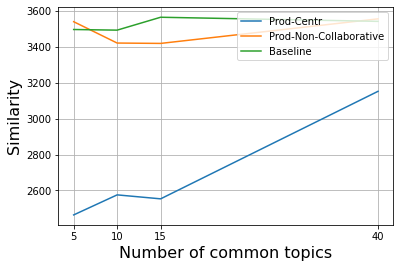

In [21]:
plt.plot(frozen_topics_list, sim_thetas_centralized, label="Prod-Centr")
plt.plot(frozen_topics_list, sim_thetas_non_colab, label="Prod-Non-Collaborative")
plt.plot(frozen_topics_list, sim_thetas_baseline, label="Baseline")
plt.legend(loc="upper right")

plt.xlabel('Number of common topics', fontsize=16)
plt.ylabel('Similarity', fontsize=16)
plt.xticks(frozen_topics_list, [5,10,15,40])
plt.grid()
plt.show()